# <font color=blue>OPTIM/OPTECH Laboratory Learning Session IV: </font>
## <font color=blue>Evolutionary Algorithms (EA)</font>

### `MASTEAM`: Master's degree in Applied Telecommunications and Engineering Management
### `MATT`: Master's degree in Advanced Telecommunication Technologies
### `CoDaS`: Erasmus Mundus master's degree in Communications, Engineering and Data Science
#####  Castelldefels School of Telecommunications and Aerospace Engineering (EETAC)

**<font color=teal>Cristina Cervelló-Pastor (cristina.cervello@upc.edu)</font>**

<div class="alert alert-block alert-info">

<font size="4"><font color=blue><b>PROBLEM:</b></font></font>
<br /><br />

<b>Design a network using Evolutionary Algorithms</b>
<br /> <br />
In this session we will deal with Evolutionary Algorithms to design a network, i.e., decide what links do you have to use to transport a percentage of a set of demands with a maximum cost constraint. Therefore, it is a multiobjective problem with two opposite objective functions.
<br /> <br />
Design the edge capacities of a network of 5 nodes, with 7 potential edges. Each edge could have a capacity of 0 (if not created), 4, 16, or 64 units of 155 Mb/s (or STM-1, STM-4, STM-16, STM-64), to satisfy a given set of demands.
</div>


In [1]:
!pip install Pyomo
!apt-get install -y -qq glpk-utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.7 MB/s eta 0:00:00
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 123622 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package

In [2]:
from pyomo.environ import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import math

import warnings
warnings.filterwarnings("ignore")

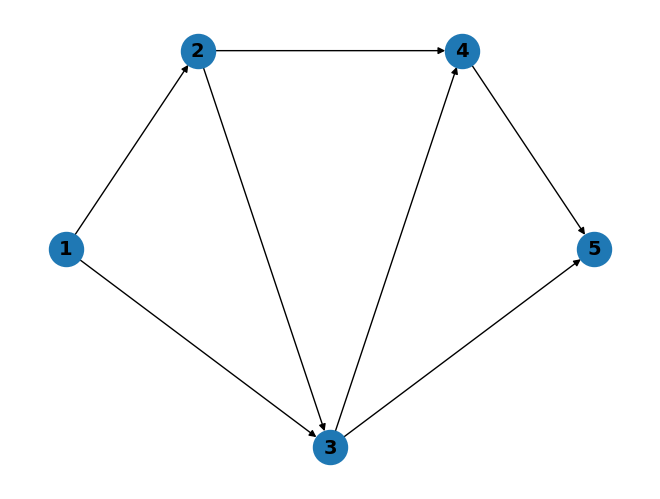

In [3]:
# Graph of the network

G = nx.DiGraph()
N = [1,2,3,4,5]
E = [(1,2),(1,3),(2,3),(2,4),(3,4),(3,5),(4,5)]

G.add_nodes_from(N)
G.add_edges_from(E, capacity=0, cost=0, color='black', weight=1)

CostMatrix = [[0 for i in range(len(N))] for j in range(len(N))]
CapacityMatrix = [[0 for i in range(len(N))] for j in range(len(N))]

#dictionary with the node position
fixed_positions = {1:(0,3),2:(2,6),3:(4,0),4:(6,6),5:(8,3)}
fixed_nodes = fixed_positions.keys()
pos = nx.spring_layout(G, pos=fixed_positions, fixed=fixed_nodes)


nx.draw(G, pos, node_size=600, with_labels=True, font_size=14, font_weight='bold')
plt.show()
plt.close()

In [4]:
# Required demands
# (origin, destination, value)(units of 155 Mb/s: 0,1,4,16,64)

demands = [
            [1,4,1]   #demand 1 (origin, destination, value)
           ,[2,3,4]   #demand 2
           ,[1,5,16]  #demand 3
           ,[4,5,64]  #demand 4
          ]


In [5]:
# Number of individuals per generation
NumIndividuals = 20

# Number of generations
NumGenerations = 15

# Maximum cost of the solution
CostLimit = 15000

# Minimum availability of the solution
AvLimit = 0.5

# Crossover fraction, in Reproduction options, specifies the fraction of the population,
# other than elite children, that are crossover children.
pc = 0.8 # Probability of crossover

# The remaining individuals, other than elite children, are mutation children.
pm = 0.1 # Probability of mutation

# cost of one STM-N module (N = 0, 1, 4, 16, 64)
cost = [0, 500, 1000, 2000, 3000]

# Set of genes for an individual
geneSet = {0,1,2,3,4}

# Edge colors
colors = ['black','blue','green','cyan','red']

# Link Types
links = ['None','STM-1','STM-4','STM-16','STM-64']


In [6]:
""" Class of a Solution of the network design: set of links, cost and availabiliy """

class Solution:
    def __init__(self, individual, cost, availability):
        self.individual = individual
        self.cost = cost
        self.availability = availability


In [7]:
""" Fill network link capacity with the information of an individual (solution)
     0 means no link; 1 means edge of capacity of 155 Mb/s (STM-1);
     2 means 622 Mb/s (4 STM-1 or 1 STM-4); 3 means 2.5 Gb/s (STM-16);
     4 means 10 Gb/s (STM-64)"""

def FillCapacity(G, individual):

    for i in range(len(E)):
        if (individual[i] == 0): G.edges[E[i][0],E[i][1]]['capacity'] = 0
        elif (individual[i] == 1): G.edges[E[i][0],E[i][1]]['capacity'] = 1
        elif (individual[i] == 2): G.edges[E[i][0],E[i][1]]['capacity'] = 4
        elif (individual[i] == 3): G.edges[E[i][0],E[i][1]]['capacity'] = 16
        elif (individual[i] == 4): G.edges[E[i][0],E[i][1]]['capacity'] = 64

        G.edges[E[i][0],E[i][1]]['cost'] = 0 if individual[i] == 0 \
                                               else cost[individual[i]-1]

    for (i,j) in E:
        CapacityMatrix[i-1][j-1] = G.edges[i,j]['capacity']
        CostMatrix[i-1][j-1] = G.edges[i,j]['cost']

In [8]:
""" Total cost of network link capacity """

def Cost(capacity):
    c = 0.0

    for i in range(len(E)):
        c = c + cost[capacity[i]]

    return(c)

In [9]:
""" Compute constrained shorts paths for each demand  """

def ComputeConstraintShortPaths(G, demands):

    import pyomo.environ
    import logging

    logging.getLogger('pyomo.core').setLevel(logging.ERROR)

    model = AbstractModel()

    model.Nodes = Set(initialize=N)
    model.Arcs = Set(dimen=2, initialize=E)

    # Demands
    model.D = Set(initialize=[i for i in range(len(demands))])
    # Source nodes
    model.source = Param(model.D, default=[demands[i][0]\
                                           for i in range(len(demands))])
    # Destination nodes
    model.destination = Param(model.D, default=[demands[i][1] \
                                                for i in range(len(demands))])
    # Traffic demand value
    model.demand = Param(model.D, default=[demands[i][2] \
                                           for i in range(len(demands))])

    # The flow over each edge due to each demand
    model.f = Var(model.Arcs, model.D, within=Binary, initialize=0)

    # Variable x indicates if each edge is used or not;
    # xe=1 edge e is used; xe=0 edge e is not used
    model.x = Var(model.Arcs, within=Binary, initialize=0)

    # Objective Function
    def cost_rule(model):
        return sum((model.x[i,j]*CostMatrix[i-1][j-1]) for (i, j) in model.Arcs)

    model.cost= Objective(rule=cost_rule, sense=minimize)

    # Flow conservation constraint
    def flow_rule(model, k, d):
        inFlow  = sum(model.f[i,j,d] for (i,j) in model.Arcs if j == k)
        if (k == demands[d][0]):
            inFlow = inFlow + 1
        outFlow = sum(model.f[i,j,d] for (i,j) in model.Arcs if i == k)
        if (k == demands[d][1]):
            outFlow = outFlow + 1

        return inFlow == outFlow
    model.flow = Constraint(model.Nodes, model.D, rule=flow_rule)

    # Link capacity constraint
    def limit_rule(model, i, j):
        return sum(model.f[i,j,d]*model.demand[d] for d in model.D) <=\
                    model.x[i, j]*CapacityMatrix[i-1][j-1]
    model.limit = Constraint(model.Arcs, rule=limit_rule)

    # Solve the model

    instance  = model.create_instance()

    opt = SolverFactory('glpk')
    results = opt.solve(instance)

    # Get how many demands have obtained a path
    num=0
    for d in instance.D:
        find=0
        for i in N:
            for j in N:
                if (i,j) in E:
                    if instance.f[i,j,d].value == 1:
                        num = num + 1
                        find = 1;
                if find == 1: break
            if find == 1: break

    return(num/len(demands))


In [10]:
""" Percentage of demands that find path """

def Percentage(G, demands):
    p = 1
    d = demands[:]
    while (True):
        if ( ComputeConstraintShortPaths(G, d) != 0 ):
            return (p)
        else: # no demand of the current list has found a path
            if ( len(d) > 1 ):
                del d[len(d)-1] # remove one demand of the list
                p = len(d) / len(demands)
            else:
                return (0) # no demand has found a path

In [11]:
""" Calculate Cost and Availability of an individual """

def MeasureIndividual(individual):

    solution = Solution(None, None, None)
    Gp = G.copy()
    FillCapacity(Gp, individual)

    solution.individual = individual
    solution.cost = Cost(individual)
    solution.availability = Percentage(Gp, demands)

    return(solution)


In [12]:
""" Create a solution """

def CreateSolution(individual,cost,availability):

    solution = Solution(None, None, None)

    solution.individual = individual
    solution.cost = cost
    solution.availability = availability

    return(solution)


In [13]:
""" Generates random population of individuals """

def InitialPopulation ():

    global CurrentIndividuals, generation

    CurrentIndividuals = []
    generation = 1
    solution = Solution(None, None, None)

    i=1
    while i <= NumIndividuals:
        solution = MeasureIndividual([np.random.randint(0,5) for r in range(len(E))])
        if solution.availability  >= AvLimit and solution.cost <= CostLimit:
            CurrentIndividuals.append(solution)
            i = i+1


In [14]:
""" Obtain the list of dominant individuals """

def Dominance(list):

    ld =[]  # List of identifiers of dominant individuals
    DominantIndividuals = [] # List of dominant individuals



    for i in range(len(list)):
        # compare one individual with the rest of individuals
        dominant = True
        c = list[i].cost
        av = list[i].availability

        for j in range(len(list)):
            if (i==j): continue # not compared with itself

            if ((c > list[j].cost and av == list[j].availability) or \
                (c == list[j].cost and av < list[j].availability) or \
                (c > list[j].cost and av < list[j].availability)):
                dominant = False
                break


        if (dominant == True):
            if list[i] not in DominantIndividuals: DominantIndividuals.append(list[i])
            ld.append(i)

    return (ld, DominantIndividuals)


In [15]:
""" Selection of two parents """

def Parents(len):

    p1 = np.random.randint(0,len)
    while (True):
        p2 = np.random.randint(0,len)
        if p2 != p1: return(p1,p2)

    return(p1,p2)


In [16]:
""" Returns True or False based on a probability """

def Decision(probability):
    return random.random() < probability


In [17]:
""" Cross two parents with certain probability pc """

def CrossParents(p1, p2):

    if Decision(pc):
        child1 = Solution(None, None, None)
        child2 = Solution(None, None, None)

        # One-point crossover
        position = np.random.randint(1,len(E))

        print("Parents", p1.individual, p2.individual)
        print('Cross from gene:', position)

        child1.individual = p1.individual[:]
        child2.individual = p2.individual[:]

        for i in range (position, len(E)):
            g = child1.individual[i]
            child1.individual[i] = child2.individual[i]
            child2.individual[i] = g


        return (True, child1, child2)
    else:
        return (False, [], [])


In [18]:
""" Crossover of all individuals with certain probability pc """

def Crossover(IndividualsToReproduce):

    lc =[]  # List of identifiers of cross individuals
    CrossoverChildren = [] # List of resulting crossover children

    for i in range(math.ceil(len(IndividualsToReproduce)/2)):
        p1, p2  = Parents(len(IndividualsToReproduce)) # Select two parents
        parent1 = IndividualsToReproduce[p1]
        parent2 = IndividualsToReproduce[p2]

        c, child1, child2 = CrossParents(parent1, parent2)

        if c:
            child1 = MeasureIndividual(child1.individual)
            if child1.availability  >= AvLimit and child1.cost <= CostLimit:
                if p1 not in lc: lc.append(p1)
                if child1 not in CrossoverChildren: CrossoverChildren.append(child1)
                print("\n   Child 1", child1.individual)
            else: print("\n   Child 1 does not comply with the constraints\n")

            child2 = MeasureIndividual(child2.individual)
            if child2.availability  >= AvLimit and child2.cost <= CostLimit:
                if p2 not in lc: lc.append(p2)
                if child2 not in CrossoverChildren: CrossoverChildren.append(child2)
                print("   Child 2", child2.individual,"\n")
            else: print("\n   Child 2 does not comply with the constraints\n")


    return(lc, CrossoverChildren)


In [19]:
""" First Mutation of one individual decreasing one gene.
    The smaller the gene, the smaller the capacity of the
    associated edges (and so the infrastructure cost) """

def FirstMutation(parent):

    child = list(parent)
    solution = Solution(None, None, None)
    repeat = True
    # we want to decrease a gene higher than the minimum value (0 in this case)
    while (repeat):
        index = random.randrange(0, len(parent))
        if child[index] != min(geneSet):
            repeat = False
    validGene = False
    while (not validGene):
        newGene = random.sample(geneSet, 1)
        if newGene[0] < child[index]:
            child[index] = newGene[0]
            validGene = True

    solution = MeasureIndividual(child)
    if solution.availability  >= AvLimit  and solution.cost <= CostLimit:
        return (True,child)
    else:
        return (False, [])


In [20]:
""" Second Mutation of one individual increasing one gene.
    Tends to improve the availability of the network by
    increasing the capacity of edges """

def SecondMutation(parent):

    child = list(parent)
    solution = Solution(None, None, None)
    repeat = True
    # we want to increase a gene lower than the maximum value (4 in this case)
    while (repeat):
        index = random.randrange(0, len(parent))
        if child[index] != max(geneSet):
            repeat = False
    validGene = False
    while (not validGene):
        newGene = random.sample(geneSet, 1)
        if newGene[0] > child[index]:
            child[index] = newGene[0]
            validGene = True

    solution = MeasureIndividual(child)
    if solution.availability  >= AvLimit and solution.cost <= CostLimit:
        return (True,child)
    else:
        return (False, [])

In [21]:
""" Mutation of remaining individuals with certain probability """

def Mutation(IndividualsToMutate):

    for i in range(len(IndividualsToMutate)):
        parent = IndividualsToMutate[i].individual
        if Decision(pm):
            validmutate1, ind = FirstMutation(IndividualsToMutate[i].individual)
            if validmutate1:
                IndividualsToMutate[i].individual = ind
            validmutate2, ind = SecondMutation(IndividualsToMutate[i].individual)
            if validmutate2:
                IndividualsToMutate[i].individual = ind
            if (not validmutate1) and (not validmutate2):
                print("individual", IndividualsToMutate[i].individual, "not mutated")
            else:
                print("individual", parent, "mutate to -----> ", ind)
        else:
            print("individual", IndividualsToMutate[i].individual, "not mutated")



In [22]:
""" Plot a population of individuals """

def PlotPopulation(IndividualList, title):

    plt.figure()
    plt.axes()
    plt.xlim((0,30000))
    plt.ylim((0,1))
    x = [IndividualList[i].cost for i in range(len(IndividualList))]
    y = [IndividualList[i].availability for i in range(len(IndividualList))]
    plt.xlabel('Cost', fontsize=12,fontweight='bold')
    plt.ylabel('Availability', fontsize=12, fontweight='bold')
    plt.scatter(x, y, color='red')
    plt.title(title, fontsize= 18, color='blue')
    plt.show()


In [23]:
""" Draw the network related to an individual """

def DrawFinalNetworks(IndividualList):

    for i in range(len(IndividualList)):
        l = [IndividualList[i].individual[e] for e in range(len(E))]
        c = [colors[l[e]] for e in range(len(E))]
        link = [links[l[e]] for e in range(len(E))]
        edge_labels = dict(zip(E, link))
        nx.draw(G, pos, node_size=600, with_labels = True, font_size=14, \
                font_weight='bold', edge_color=c, width=l, label=colors)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.show()



In [24]:
""" Print individuals, their cost and availability for one generation """

def PrintGenerationInfo(generation, ListIndividuals):

    print("\nGENERATION:",generation,"\n")
    for i in range(len(ListIndividuals)):
        print ("Individual:",ListIndividuals[i].individual, \
               "Cost:",ListIndividuals[i].cost, \
               "Availability:",ListIndividuals[i].availability)

In [25]:
def main():

    global CurrentIndividuals, generation, NextIndividuals, GlobalDominantIndividuals
    GlobalDominantIndividuals=[]

    #### INITIAL POPULATION
    InitialPopulation()

    PrintGenerationInfo(generation, CurrentIndividuals)

    PlotPopulation(CurrentIndividuals, "Generation 1")

    ####  REPEAT UNTIL A SOLUTION IS FOUND OR
    ####  A MAXIMUM NUMBER OF GENERATIONS IS ACHIEVED

    while (generation < NumGenerations):

        NextIndividuals=[]
        del NextIndividuals[:]

        ##### SELECTION PROCESS

        #### Select non-dominated solutions of this generation. Elitism.
        DominantIndividuals = []
        ListDominants = []

        ListDominants, DominantIndividuals = Dominance(CurrentIndividuals)

        IndividualsToReproduce = CurrentIndividuals[:]

        # Elite children (non-dominated individuals) go directly to the next generation
        for i in range(len(DominantIndividuals)):
            if CurrentIndividuals[ListDominants[i]] not in NextIndividuals:
                NextIndividuals.append(CurrentIndividuals[ListDominants[i]])
            if CurrentIndividuals[ListDominants[i]] not in GlobalDominantIndividuals:
                GlobalDominantIndividuals.append(CurrentIndividuals[ListDominants[i]])


            IndividualsToReproduce.remove(CurrentIndividuals[ListDominants[i]])


        ### REPRODUCTION PROCESS to generate the new generation

        ### CROSSOVER

        # The crossover probability specifies the fraction of individuals
        # in the next generation, other than elite children,
        # that are created by crossover.

        print("\n\n >>>> CROSSOVER PHASE (with probability", pc, ")\n\n")

        ListCrossover=[]
        CrossoverChildren=[]

        del ListCrossover[:]
        del CrossoverChildren [:]

        ListCrossover, CrossoverChildren = Crossover(IndividualsToReproduce)
        print("\nNumber of Crossover Children:",len(CrossoverChildren),"\n")

        IndividualsToMutate=[]
        del IndividualsToMutate[:]
        IndividualsToMutate = IndividualsToReproduce[:]


        for i in range(len(ListCrossover)):
            IndividualsToMutate.remove(IndividualsToReproduce[ListCrossover[i]])

        for i in range(len(CrossoverChildren)):
            if (len(NextIndividuals)<NumIndividuals):
                NextIndividuals.append(CrossoverChildren[i])


        ### MUTATION PROCESS

        # The remaining individuals that are not crossover children and are
        # not elite children, will be mutated with probability pm

        print("\n\n >>>> MUTATION PHASE (with probability", pm, ")\n\n")

        Mutation(IndividualsToMutate)

        for i in range(len(IndividualsToMutate)):
            if (len(NextIndividuals)<NumIndividuals):
                NextIndividuals.append(IndividualsToMutate[i])

        del CurrentIndividuals[:]

        for i in range(len(NextIndividuals)):
            CurrentIndividuals.append(NextIndividuals[i])

        generation = generation + 1

        PrintGenerationInfo(generation, CurrentIndividuals)

        PlotPopulation(CurrentIndividuals, "Generation %s" % generation)
        print(ListDominants)





GENERATION: 1 

Individual: [4, 1, 3, 4, 1, 1, 0] Cost: 9500.0 Availability: 0.5
Individual: [4, 1, 4, 2, 0, 2, 4] Cost: 11500.0 Availability: 0.5
Individual: [1, 4, 3, 3, 2, 4, 4] Cost: 14500.0 Availability: 1
Individual: [3, 3, 2, 0, 2, 1, 3] Cost: 8500.0 Availability: 0.5
Individual: [2, 1, 4, 2, 1, 4, 2] Cost: 10000.0 Availability: 0.5
Individual: [3, 3, 2, 1, 1, 1, 0] Cost: 6500.0 Availability: 0.5
Individual: [4, 3, 3, 2, 0, 1, 2] Cost: 9500.0 Availability: 0.5
Individual: [4, 0, 3, 3, 4, 0, 2] Cost: 11000.0 Availability: 0.5
Individual: [4, 2, 3, 2, 0, 1, 2] Cost: 8500.0 Availability: 0.5
Individual: [1, 1, 2, 0, 1, 4, 3] Cost: 7500.0 Availability: 0.5
Individual: [3, 2, 4, 4, 2, 3, 1] Cost: 12500.0 Availability: 0.75
Individual: [3, 3, 3, 0, 1, 1, 0] Cost: 7000.0 Availability: 0.5
Individual: [3, 1, 3, 0, 3, 0, 1] Cost: 7000.0 Availability: 0.5
Individual: [2, 3, 2, 0, 1, 3, 3] Cost: 8500.0 Availability: 0.5
Individual: [4, 1, 4, 3, 1, 3, 4] Cost: 14000.0 Availability: 1
Indiv

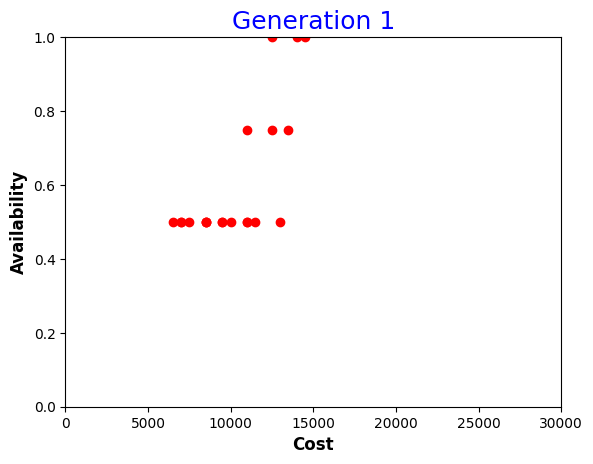



 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [4, 2, 3, 2, 0, 1, 2] [4, 3, 3, 2, 0, 1, 2]
Cross from gene: 4

   Child 1 [4, 2, 3, 2, 0, 1, 2]
   Child 2 [4, 3, 3, 2, 0, 1, 2] 

Parents [4, 1, 2, 1, 3, 2, 4] [4, 1, 3, 4, 1, 1, 0]
Cross from gene: 1

   Child 1 [4, 1, 3, 4, 1, 1, 0]
   Child 2 [4, 1, 2, 1, 3, 2, 4] 

Parents [1, 1, 2, 0, 1, 4, 3] [4, 1, 4, 2, 0, 2, 4]
Cross from gene: 6

   Child 1 [1, 1, 2, 0, 1, 4, 4]
   Child 2 [4, 1, 4, 2, 0, 2, 3] 

Parents [4, 1, 2, 1, 3, 2, 4] [4, 0, 3, 3, 4, 0, 2]
Cross from gene: 2

   Child 1 [4, 1, 3, 3, 4, 0, 2]
   Child 2 [4, 0, 2, 1, 3, 2, 4] 

Parents [3, 2, 4, 4, 2, 3, 1] [3, 3, 2, 0, 2, 1, 3]
Cross from gene: 1

   Child 1 [3, 3, 2, 0, 2, 1, 3]
   Child 2 [3, 2, 4, 4, 2, 3, 1] 


Number of Crossover Children: 10 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [1, 4, 3, 3, 2, 4, 4] not mutated
individual [2, 1, 4, 2, 1, 4, 2] not mutated
individual [3, 3, 3, 0, 1, 1, 0] not mutated
individual [3, 1, 3, 0, 3, 0, 

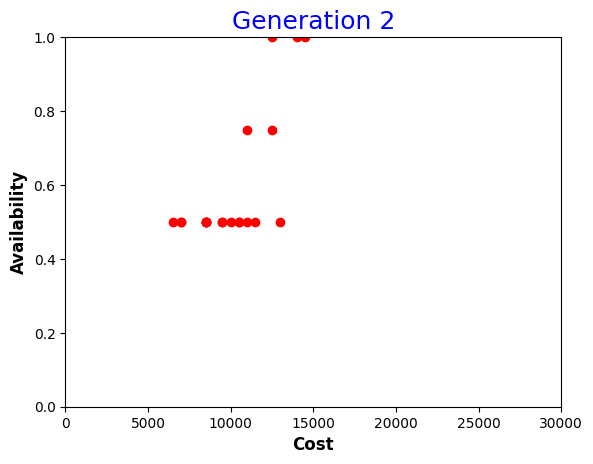

[5, 16, 17]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [4, 3, 3, 2, 0, 1, 2] [3, 2, 4, 4, 2, 3, 1]
Cross from gene: 1

   Child 1 [4, 2, 4, 4, 2, 3, 1]
   Child 2 [3, 3, 3, 2, 0, 1, 2] 

Parents [3, 3, 2, 0, 2, 1, 3] [4, 0, 2, 1, 3, 2, 4]
Cross from gene: 4

   Child 1 [3, 3, 2, 0, 3, 2, 4]
   Child 2 [4, 0, 2, 1, 2, 1, 3] 

Parents [1, 4, 3, 3, 2, 4, 4] [4, 1, 4, 2, 0, 2, 3]
Cross from gene: 2

   Child 1 [1, 4, 4, 2, 0, 2, 3]
   Child 2 [4, 1, 3, 3, 2, 4, 4] 

Parents [4, 0, 2, 1, 3, 2, 4] [3, 2, 4, 4, 2, 3, 1]
Cross from gene: 1

   Child 1 [4, 2, 4, 4, 2, 3, 1]
   Child 2 [3, 0, 2, 1, 3, 2, 4] 

Parents [4, 1, 4, 2, 0, 2, 3] [4, 1, 3, 4, 1, 1, 0]
Cross from gene: 1

   Child 1 [4, 1, 3, 4, 1, 1, 0]
   Child 2 [4, 1, 4, 2, 0, 2, 3] 

Parents [4, 2, 3, 2, 0, 1, 2] [4, 1, 2, 1, 3, 2, 4]
Cross from gene: 2

   Child 1 [4, 2, 2, 1, 3, 2, 4]
   Child 2 [4, 1, 3, 2, 0, 1, 2] 

Parents [4, 1, 3, 4, 1, 1, 0] [4, 1, 4, 2, 0, 2, 3]
Cross from gene: 2

   Child 1 [4, 1, 4, 2, 0,

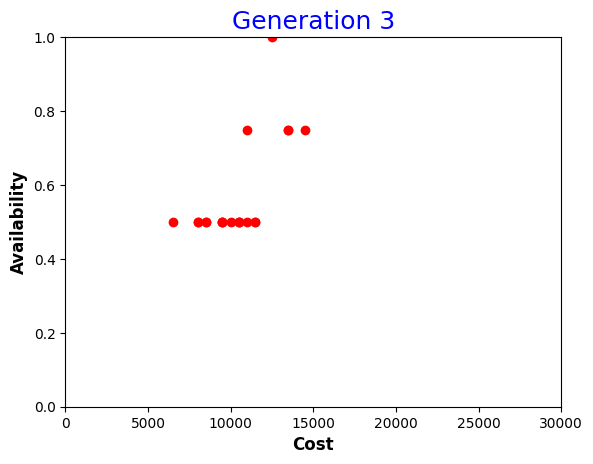

[0, 1, 2]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [4, 1, 3, 4, 1, 1, 0] [4, 2, 4, 4, 2, 3, 1]
Cross from gene: 2

   Child 1 [4, 1, 4, 4, 2, 3, 1]
   Child 2 [4, 2, 3, 4, 1, 1, 0] 

Parents [4, 0, 2, 1, 2, 1, 3] [3, 3, 3, 2, 0, 1, 2]
Cross from gene: 1

   Child 1 [4, 3, 3, 2, 0, 1, 2]
   Child 2 [3, 0, 2, 1, 2, 1, 3] 

Parents [4, 0, 2, 1, 2, 1, 3] [4, 1, 3, 2, 0, 1, 2]
Cross from gene: 3

   Child 1 [4, 0, 2, 2, 0, 1, 2]
   Child 2 [4, 1, 3, 1, 2, 1, 3] 

Parents [3, 0, 2, 1, 3, 2, 4] [2, 1, 4, 2, 1, 4, 2]
Cross from gene: 2

   Child 1 [3, 0, 4, 2, 1, 4, 2]
   Child 2 [2, 1, 2, 1, 3, 2, 4] 

Parents [1, 4, 4, 2, 0, 2, 3] [4, 2, 4, 4, 2, 3, 1]
Cross from gene: 1

   Child 1 [1, 2, 4, 4, 2, 3, 1]
   Child 2 [4, 4, 4, 2, 0, 2, 3] 

Parents [3, 3, 3, 2, 0, 1, 2] [4, 1, 3, 3, 2, 4, 4]
Cross from gene: 5

   Child 1 [3, 3, 3, 2, 0, 4, 4]
   Child 2 [4, 1, 3, 3, 2, 1, 2] 

Parents [4, 1, 3, 3, 2, 4, 4] [4, 1, 3, 4, 1, 1, 0]
Cross from gene: 2

   Child 1 [4, 1, 3, 4, 1, 1

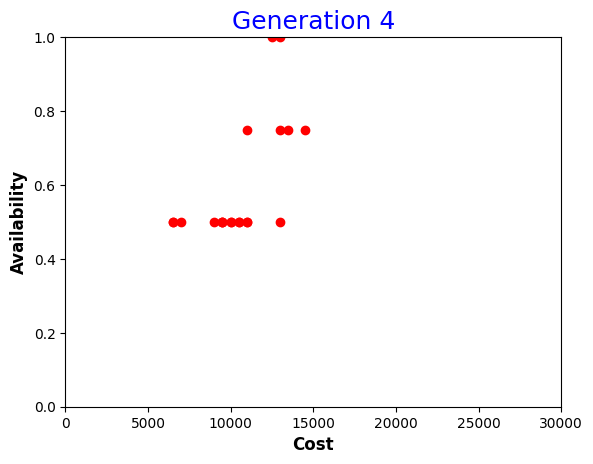

[0, 1, 2]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [3, 3, 3, 2, 0, 4, 4] [4, 1, 3, 3, 2, 1, 2]
Cross from gene: 5

   Child 1 [3, 3, 3, 2, 0, 1, 2]
   Child 2 [4, 1, 3, 3, 2, 4, 4] 

Parents [4, 1, 3, 1, 2, 1, 3] [2, 1, 2, 1, 3, 2, 4]
Cross from gene: 4

   Child 1 [4, 1, 3, 1, 3, 2, 4]
   Child 2 [2, 1, 2, 1, 2, 1, 3] 

Parents [3, 0, 4, 2, 1, 4, 2] [4, 1, 3, 1, 2, 1, 3]
Cross from gene: 5

   Child 1 [3, 0, 4, 2, 1, 1, 3]
   Child 2 [4, 1, 3, 1, 2, 4, 2] 

Parents [4, 3, 3, 2, 0, 1, 2] [3, 0, 2, 1, 2, 1, 3]
Cross from gene: 1

   Child 1 [4, 0, 2, 1, 2, 1, 3]
   Child 2 [3, 3, 3, 2, 0, 1, 2] 

Parents [4, 1, 3, 1, 2, 1, 3] [4, 1, 3, 4, 1, 1, 0]
Cross from gene: 1

   Child 1 [4, 1, 3, 4, 1, 1, 0]
   Child 2 [4, 1, 3, 1, 2, 1, 3] 

Parents [4, 3, 3, 2, 0, 1, 2] [4, 1, 3, 3, 2, 4, 4]
Cross from gene: 1

   Child 1 [4, 1, 3, 3, 2, 4, 4]
   Child 2 [4, 3, 3, 2, 0, 1, 2] 

Parents [4, 2, 4, 4, 2, 3, 1] [4, 1, 3, 3, 2, 1, 2]
Cross from gene: 3

   Child 1 [4, 2, 4, 3, 2, 1

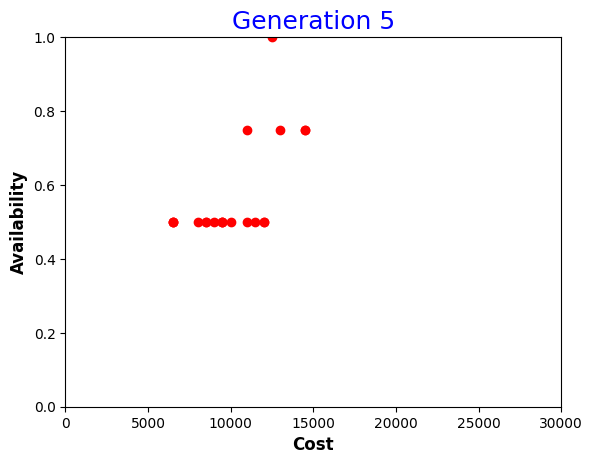

[0, 1, 2, 7]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [4, 1, 3, 4, 2, 3, 1] [4, 2, 3, 4, 1, 1, 0]
Cross from gene: 3

   Child 1 [4, 1, 3, 4, 1, 1, 0]
   Child 2 [4, 2, 3, 4, 2, 3, 1] 

Parents [4, 1, 3, 4, 2, 3, 1] [4, 1, 3, 3, 2, 4, 4]
Cross from gene: 6

   Child 1 [4, 1, 3, 4, 2, 3, 4]
   Child 2 [4, 1, 3, 3, 2, 4, 1] 

Parents [3, 3, 3, 2, 0, 1, 2] [4, 1, 3, 1, 2, 4, 2]
Cross from gene: 5

   Child 1 [3, 3, 3, 2, 0, 4, 2]
   Child 2 [4, 1, 3, 1, 2, 1, 2] 

Parents [4, 1, 3, 4, 1, 1, 0] [3, 3, 3, 2, 0, 1, 2]
Cross from gene: 2

   Child 1 [4, 1, 3, 2, 0, 1, 2]
   Child 2 [3, 3, 3, 4, 1, 1, 0] 

Parents [4, 1, 4, 4, 2, 3, 1] [4, 1, 3, 4, 1, 1, 0]
Cross from gene: 5

   Child 1 [4, 1, 4, 4, 2, 1, 0]
   Child 2 [4, 1, 3, 4, 1, 3, 1] 

Parents [4, 1, 3, 1, 3, 2, 4] [4, 1, 3, 1, 2, 1, 3]
Cross from gene: 4

   Child 1 [4, 1, 3, 1, 2, 1, 3]
   Child 2 [4, 1, 3, 1, 3, 2, 4] 


Number of Crossover Children: 12 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [

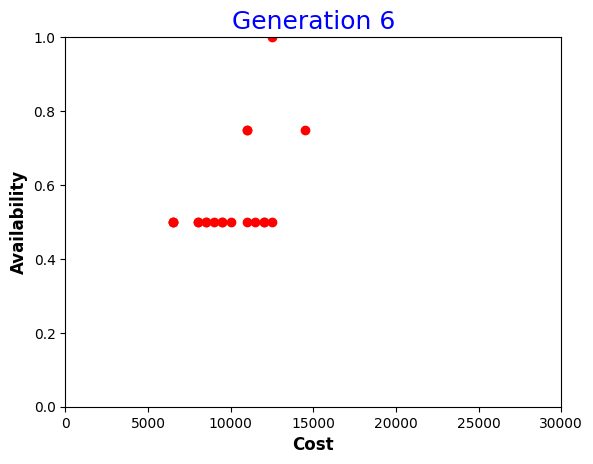

[0, 1, 2, 3, 7]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [4, 3, 3, 2, 0, 1, 0] [4, 1, 3, 4, 1, 3, 1]
Cross from gene: 3

   Child 1 [4, 3, 3, 4, 1, 3, 1]
   Child 2 [4, 1, 3, 2, 0, 1, 0] 

Parents [4, 1, 3, 3, 2, 4, 1] [4, 0, 2, 1, 2, 1, 3]
Cross from gene: 1

   Child 1 [4, 0, 2, 1, 2, 1, 3]
   Child 2 [4, 1, 3, 3, 2, 4, 1] 

Parents [4, 1, 4, 4, 2, 1, 0] [4, 0, 2, 1, 2, 1, 3]
Cross from gene: 5

   Child 1 [4, 1, 4, 4, 2, 1, 3]
   Child 2 [4, 0, 2, 1, 2, 1, 0] 

Parents [4, 1, 3, 4, 2, 3, 4] [3, 0, 4, 2, 1, 4, 0]
Cross from gene: 1

   Child 1 [4, 0, 4, 2, 1, 4, 0]
   Child 2 [3, 1, 3, 4, 2, 3, 4] 

Parents [4, 1, 3, 1, 2, 1, 2] [4, 1, 3, 1, 3, 2, 4]
Cross from gene: 1

   Child 1 [4, 1, 3, 1, 3, 2, 4]
   Child 2 [4, 1, 3, 1, 2, 1, 2] 

Parents [4, 1, 3, 2, 0, 1, 2] [4, 3, 3, 2, 0, 1, 0]
Cross from gene: 5

   Child 1 [4, 1, 3, 2, 0, 1, 0]
   Child 2 [4, 3, 3, 2, 0, 1, 2] 


Number of Crossover Children: 12 



 >>>> MUTATION PHASE (with probability 0.1 )


individua

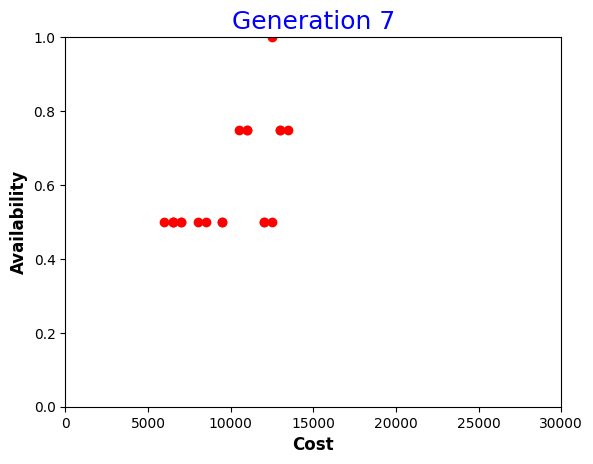

[0, 1, 2, 3, 4, 9]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [4, 1, 3, 2, 0, 1, 0] [4, 1, 3, 3, 2, 4, 1]
Cross from gene: 1

   Child 1 [4, 1, 3, 3, 2, 4, 1]
   Child 2 [4, 1, 3, 2, 0, 1, 0] 

Parents [3, 1, 3, 4, 2, 3, 4] [3, 3, 2, 1, 1, 1, 0]
Cross from gene: 3

   Child 1 [3, 1, 3, 1, 1, 1, 0]
   Child 2 [3, 3, 2, 4, 2, 3, 4] 

Parents [4, 3, 3, 2, 0, 1, 2] [4, 2, 3, 4, 2, 3, 1]
Cross from gene: 2

   Child 1 [4, 3, 3, 4, 2, 3, 1]
   Child 2 [4, 2, 3, 2, 0, 1, 2] 

Parents [4, 3, 3, 4, 1, 3, 1] [4, 0, 2, 2, 0, 1, 2]
Cross from gene: 1

   Child 1 [4, 0, 2, 2, 0, 1, 2]
   Child 2 [4, 3, 3, 4, 1, 3, 1] 

Parents [4, 1, 3, 2, 0, 1, 0] [4, 1, 3, 2, 0, 1, 0]
Cross from gene: 4

   Child 1 [4, 1, 3, 2, 0, 1, 0]
   Child 2 [4, 1, 3, 2, 0, 1, 0] 

Parents [4, 1, 3, 2, 0, 1, 0] [4, 2, 3, 4, 2, 3, 1]
Cross from gene: 2

   Child 1 [4, 1, 3, 4, 2, 3, 1]
   Child 2 [4, 2, 3, 2, 0, 1, 0] 

Parents [4, 1, 3, 1, 3, 2, 4] [4, 0, 2, 1, 2, 1, 3]
Cross from gene: 3

   Child 1 [4, 1, 3

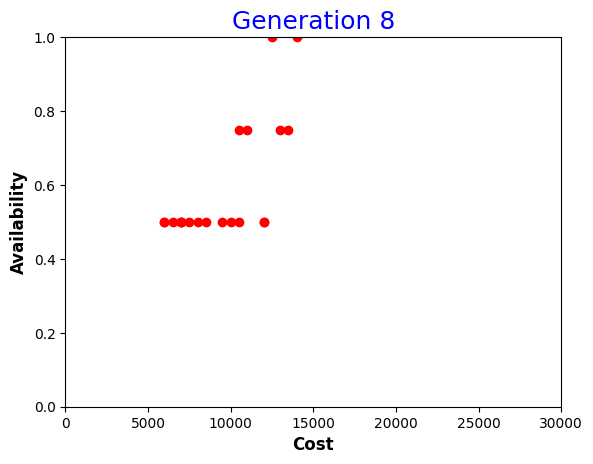

[2, 11, 12]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [4, 1, 3, 2, 0, 1, 0] [4, 1, 3, 1, 2, 1, 3]
Cross from gene: 5

   Child 1 [4, 1, 3, 2, 0, 1, 3]
   Child 2 [4, 1, 3, 1, 2, 1, 0] 

Parents [4, 3, 3, 4, 2, 3, 1] [4, 1, 3, 2, 0, 1, 0]
Cross from gene: 3

   Child 1 [4, 3, 3, 2, 0, 1, 0]
   Child 2 [4, 1, 3, 4, 2, 3, 1] 

Parents [4, 3, 3, 4, 1, 3, 1] [4, 1, 3, 3, 2, 4, 1]
Cross from gene: 3

   Child 1 [4, 3, 3, 3, 2, 4, 1]
   Child 2 [4, 1, 3, 4, 1, 3, 1] 

Parents [4, 2, 3, 2, 0, 1, 0] [4, 1, 3, 2, 0, 1, 2]
Cross from gene: 6

   Child 1 [4, 2, 3, 2, 0, 1, 2]
   Child 2 [4, 1, 3, 2, 0, 1, 0] 

Parents [4, 1, 3, 4, 2, 3, 1] [4, 1, 3, 2, 0, 1, 0]
Cross from gene: 6

   Child 1 [4, 1, 3, 4, 2, 3, 0]
   Child 2 [4, 1, 3, 2, 0, 1, 1] 

Parents [4, 3, 3, 4, 1, 3, 1] [3, 3, 2, 4, 2, 3, 4]
Cross from gene: 5

   Child 1 does not comply with the constraints

   Child 2 [3, 3, 2, 4, 2, 3, 1] 

Parents [4, 1, 3, 1, 2, 1, 3] [4, 0, 2, 1, 3, 2, 4]
Cross from gene: 6

   Child 1

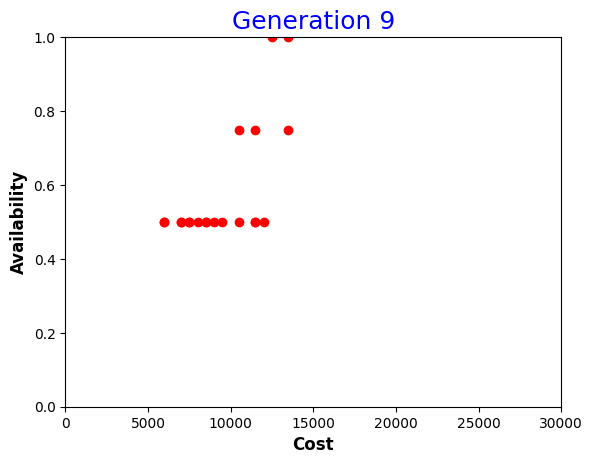

[0, 1, 2, 5]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [4, 1, 3, 2, 0, 1, 3] [4, 1, 3, 1, 2, 1, 0]
Cross from gene: 1

   Child 1 [4, 1, 3, 1, 2, 1, 0]
   Child 2 [4, 1, 3, 2, 0, 1, 3] 

Parents [4, 1, 3, 1, 2, 1, 4] [1, 3, 4, 3, 2, 3, 4]
Cross from gene: 5

   Child 1 [4, 1, 3, 1, 2, 3, 4]
   Child 2 [1, 3, 4, 3, 2, 1, 4] 

Parents [4, 1, 3, 4, 1, 3, 1] [4, 1, 3, 2, 0, 1, 0]
Cross from gene: 1

   Child 1 [4, 1, 3, 2, 0, 1, 0]
   Child 2 [4, 1, 3, 4, 1, 3, 1] 

Parents [4, 0, 2, 1, 3, 2, 1] [4, 2, 3, 2, 0, 1, 2]
Cross from gene: 6

   Child 1 [4, 0, 2, 1, 3, 2, 2]
   Child 2 [4, 2, 3, 2, 0, 1, 1] 

Parents [4, 1, 3, 2, 0, 1, 0] [4, 1, 3, 2, 0, 1, 1]
Cross from gene: 6

   Child 1 [4, 1, 3, 2, 0, 1, 1]
   Child 2 [4, 1, 3, 2, 0, 1, 0] 

Parents [4, 1, 3, 2, 0, 1, 0] [4, 2, 3, 2, 0, 1, 2]
Cross from gene: 5

   Child 1 [4, 1, 3, 2, 0, 1, 2]
   Child 2 [4, 2, 3, 2, 0, 1, 0] 

Parents [4, 3, 3, 2, 0, 1, 0] [4, 2, 3, 2, 0, 1, 2]
Cross from gene: 4

   Child 1 [4, 3, 3, 2, 0

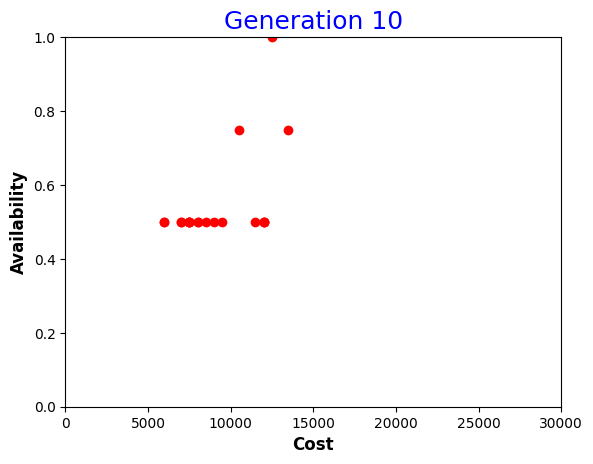

[0, 1, 2, 3]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [4, 3, 3, 2, 0, 1, 2] [4, 1, 3, 1, 2, 1, 0]
Cross from gene: 6

   Child 1 [4, 3, 3, 2, 0, 1, 0]
   Child 2 [4, 1, 3, 1, 2, 1, 2] 

Parents [4, 1, 3, 2, 0, 1, 0] [4, 2, 3, 2, 0, 1, 0]
Cross from gene: 4

   Child 1 [4, 1, 3, 2, 0, 1, 0]
   Child 2 [4, 2, 3, 2, 0, 1, 0] 

Parents [4, 1, 3, 4, 2, 3, 1] [4, 1, 3, 2, 0, 1, 3]
Cross from gene: 1

   Child 1 [4, 1, 3, 2, 0, 1, 3]
   Child 2 [4, 1, 3, 4, 2, 3, 1] 

Parents [4, 1, 3, 1, 2, 1, 0] [4, 3, 3, 3, 2, 4, 1]
Cross from gene: 2

   Child 1 [4, 1, 3, 3, 2, 4, 1]
   Child 2 [4, 3, 3, 1, 2, 1, 0] 

Parents [4, 1, 3, 2, 0, 1, 0] [4, 1, 3, 2, 0, 1, 0]
Cross from gene: 1

   Child 1 [4, 1, 3, 2, 0, 1, 0]
   Child 2 [4, 1, 3, 2, 0, 1, 0] 

Parents [4, 1, 3, 2, 0, 1, 3] [4, 1, 3, 2, 0, 1, 0]
Cross from gene: 3

   Child 1 [4, 1, 3, 2, 0, 1, 0]
   Child 2 [4, 1, 3, 2, 0, 1, 3] 

Parents [4, 1, 3, 2, 0, 1, 1] [4, 0, 2, 1, 3, 2, 2]
Cross from gene: 2

   Child 1 [4, 1, 2, 1, 3

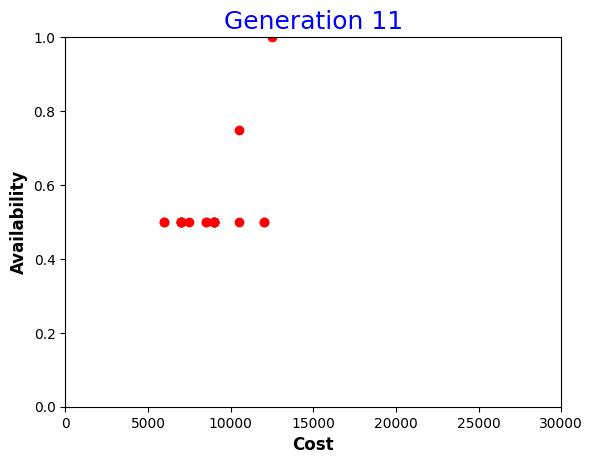

[0, 1, 2, 3]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [4, 1, 3, 2, 0, 1, 0] [4, 1, 3, 2, 0, 1, 3]
Cross from gene: 3

   Child 1 [4, 1, 3, 2, 0, 1, 3]
   Child 2 [4, 1, 3, 2, 0, 1, 0] 

Parents [1, 3, 4, 3, 2, 1, 0] [4, 2, 3, 2, 0, 1, 0]
Cross from gene: 3

   Child 1 [1, 3, 4, 2, 0, 1, 0]
   Child 2 [4, 2, 3, 3, 2, 1, 0] 

Parents [4, 1, 3, 1, 2, 1, 4] [4, 1, 3, 2, 0, 1, 0]
Cross from gene: 6

   Child 1 [4, 1, 3, 1, 2, 1, 0]
   Child 2 [4, 1, 3, 2, 0, 1, 4] 

Parents [4, 0, 3, 2, 0, 1, 1] [4, 1, 3, 2, 0, 1, 0]
Cross from gene: 6

   Child 1 [4, 0, 3, 2, 0, 1, 0]
   Child 2 [4, 1, 3, 2, 0, 1, 1] 


Number of Crossover Children: 8 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [4, 3, 3, 2, 0, 1, 0] not mutated
individual [4, 1, 3, 1, 2, 1, 2] not mutated
individual [4, 1, 3, 4, 2, 3, 1] not mutated
individual [4, 1, 3, 3, 2, 4, 1] not mutated
individual [4, 3, 3, 1, 2, 1, 0] not mutated
individual [4, 1, 3, 2, 0, 1, 0] not mutated
individual [4, 1, 3, 2,

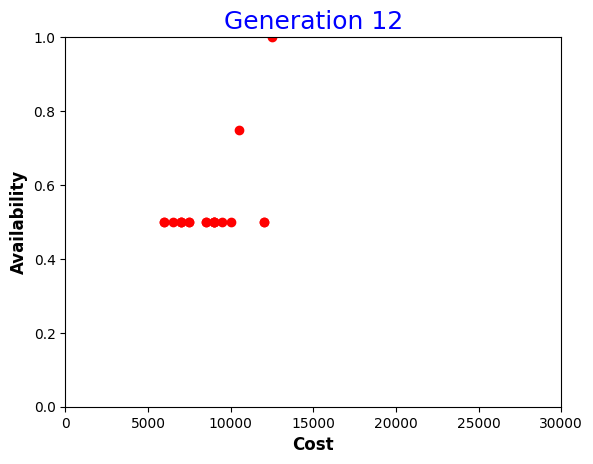

[0, 1, 2, 3]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [4, 0, 3, 2, 0, 1, 0] [4, 3, 3, 1, 2, 1, 0]
Cross from gene: 4

   Child 1 [4, 0, 3, 2, 2, 1, 0]
   Child 2 [4, 3, 3, 1, 0, 1, 0] 

Parents [4, 1, 3, 3, 2, 4, 1] [4, 1, 3, 2, 0, 1, 3]
Cross from gene: 3

   Child 1 [4, 1, 3, 2, 0, 1, 3]
   Child 2 [4, 1, 3, 3, 2, 4, 1] 

Parents [4, 1, 3, 3, 2, 4, 1] [4, 2, 3, 3, 2, 1, 0]
Cross from gene: 5

   Child 1 [4, 1, 3, 3, 2, 1, 0]
   Child 2 [4, 2, 3, 3, 2, 4, 1] 

Parents [4, 3, 3, 2, 0, 1, 0] [4, 1, 3, 1, 2, 1, 0]
Cross from gene: 1

   Child 1 [4, 1, 3, 1, 2, 1, 0]
   Child 2 [4, 3, 3, 2, 0, 1, 0] 

Parents [4, 1, 3, 3, 2, 4, 1] [4, 1, 3, 2, 0, 1, 4]
Cross from gene: 6

   Child 1 [4, 1, 3, 3, 2, 4, 4]
   Child 2 [4, 1, 3, 2, 0, 1, 1] 


Number of Crossover Children: 10 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [4, 1, 3, 2, 0, 1, 0] mutate to ----->  [4, 0, 4, 2, 0, 1, 0]
individual [1, 3, 4, 2, 0, 1, 0] not mutated
individual [4, 1, 3, 2, 0, 1, 1] n

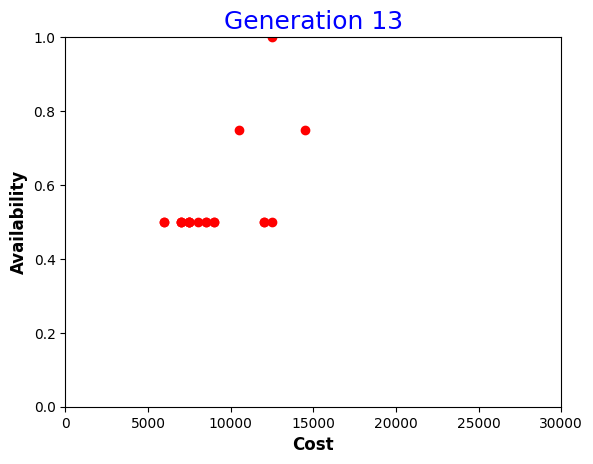

[0, 1, 2, 3]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [4, 1, 3, 4, 2, 3, 1] [4, 3, 3, 2, 0, 1, 0]
Cross from gene: 2

   Child 1 [4, 1, 3, 2, 0, 1, 0]
   Child 2 [4, 3, 3, 4, 2, 3, 1] 

Parents [4, 0, 3, 2, 2, 1, 0] [4, 1, 3, 2, 0, 1, 1]
Cross from gene: 6

   Child 1 [4, 0, 3, 2, 2, 1, 1]
   Child 2 [4, 1, 3, 2, 0, 1, 0] 

Parents [4, 1, 3, 2, 0, 1, 1] [4, 1, 3, 4, 2, 3, 1]
Cross from gene: 5

   Child 1 [4, 1, 3, 2, 0, 3, 1]
   Child 2 [4, 1, 3, 4, 2, 1, 1] 

Parents [4, 0, 4, 2, 0, 1, 0] [4, 3, 3, 2, 0, 1, 0]
Cross from gene: 1

   Child 1 [4, 3, 3, 2, 0, 1, 0]
   Child 2 [4, 0, 4, 2, 0, 1, 0] 

Parents [4, 2, 3, 3, 2, 4, 1] [4, 1, 3, 2, 0, 1, 1]
Cross from gene: 6

   Child 1 [4, 2, 3, 3, 2, 4, 1]
   Child 2 [4, 1, 3, 2, 0, 1, 1] 

Parents [4, 1, 3, 3, 2, 1, 0] [4, 2, 3, 3, 2, 4, 1]
Cross from gene: 6

   Child 1 [4, 1, 3, 3, 2, 1, 1]
   Child 2 [4, 2, 3, 3, 2, 4, 0] 

Parents [4, 1, 3, 3, 2, 4, 1] [4, 1, 3, 2, 0, 1, 0]
Cross from gene: 6

   Child 1 [4, 1, 3, 3, 2

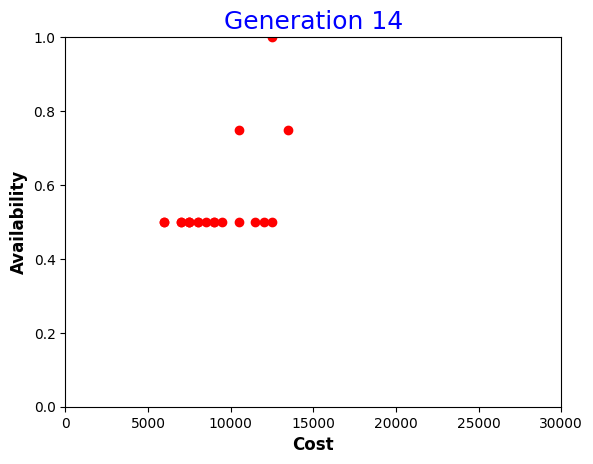

[0, 1, 2, 3]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [4, 1, 3, 2, 0, 1, 0] [4, 2, 3, 3, 2, 4, 1]
Cross from gene: 1

   Child 1 [4, 2, 3, 3, 2, 4, 1]
   Child 2 [4, 1, 3, 2, 0, 1, 0] 

Parents [4, 3, 3, 4, 2, 3, 1] [4, 1, 3, 4, 2, 1, 1]
Cross from gene: 1

   Child 1 [4, 1, 3, 4, 2, 1, 1]
   Child 2 [4, 3, 3, 4, 2, 3, 1] 

Parents [4, 1, 3, 2, 0, 1, 1] [4, 3, 3, 2, 0, 1, 0]
Cross from gene: 3

   Child 1 [4, 1, 3, 2, 0, 1, 0]
   Child 2 [4, 3, 3, 2, 0, 1, 1] 

Parents [4, 1, 3, 3, 2, 1, 1] [4, 3, 3, 4, 2, 3, 1]
Cross from gene: 1

   Child 1 [4, 3, 3, 4, 2, 3, 1]
   Child 2 [4, 1, 3, 3, 2, 1, 1] 

Parents [4, 1, 3, 2, 0, 3, 1] [4, 1, 3, 2, 0, 1, 1]
Cross from gene: 2

   Child 1 [4, 1, 3, 2, 0, 1, 1]
   Child 2 [4, 1, 3, 2, 0, 3, 1] 


Number of Crossover Children: 10 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [4, 0, 3, 2, 2, 1, 1] not mutated
individual [4, 1, 3, 2, 0, 1, 0] mutate to ----->  [4, 1, 3, 3, 0, 1, 0]
individual [4, 0, 4, 2, 0, 1, 0] n

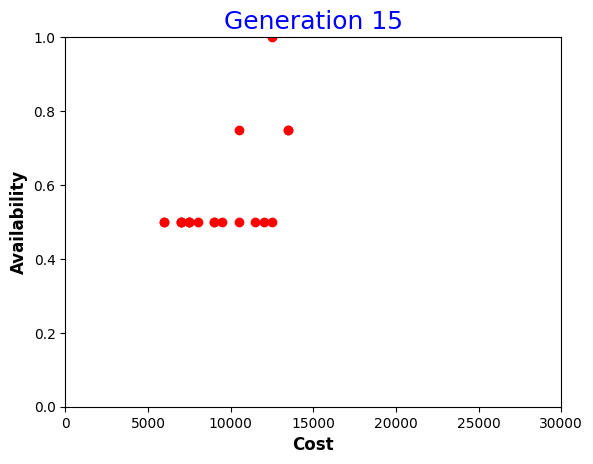

[0, 1, 2, 3]


In [ ]:
if __name__ == '__main__':
    main()


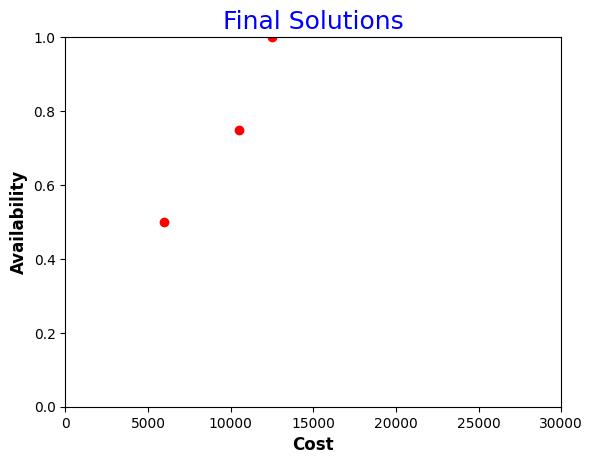

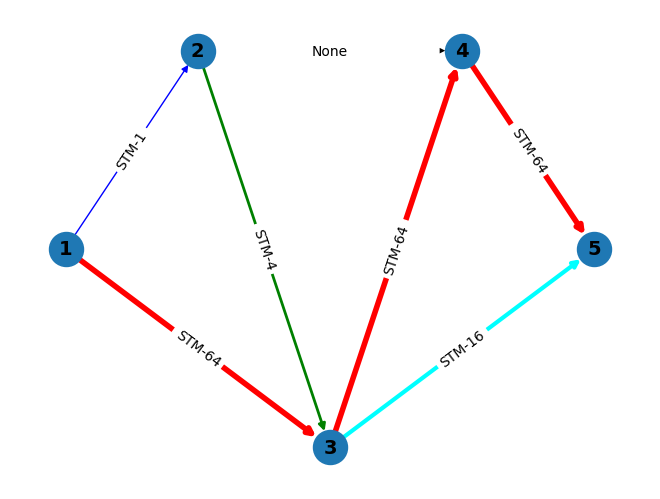

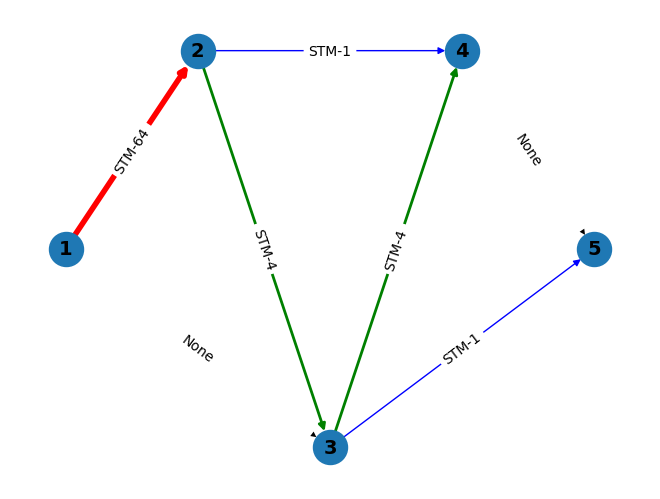

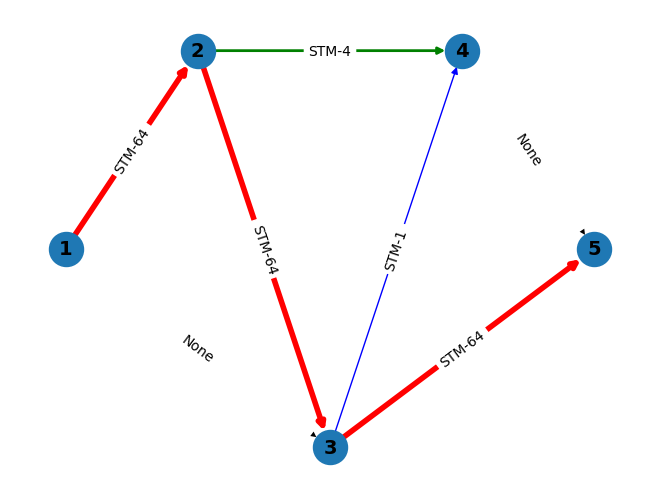

In [ ]:
# To plot a list of individuals (final solutions, so non-dominated) create a list,
# using the function CreateSolution(individual, cost, availability)

# EXAMPLE (Put YOUR non-dominated solutions, adding your individuals, cost and availability!):
# Consider that the solution is:
# Individual 1: [1,1,2,1,0,0,2] with cost 3500 and availability 0.5
# Individual 2: [2, 4, 2, 1, 4, 0, 3] with cost 10500 and availability 0.75

DominantIndividuals=[]

sol = CreateSolution([1, 4, 2, 0, 4, 3, 4], 12500.0, 1)
DominantIndividuals.append(sol)

sol = CreateSolution([4, 0, 2, 1, 2, 1, 0], 6000.0, 0.5)
DominantIndividuals.append(sol)

sol = CreateSolution([4, 0, 4, 2, 1, 4, 0], 10500.0, 0.75)
DominantIndividuals.append(sol)

PlotPopulation(DominantIndividuals,'Final Solutions')
DrawFinalNetworks(DominantIndividuals)

<div class="alert alert-block  alert-success">
<font size="4"><font color=green><b>EXERCISES</b></font></font>
</div>

-----------------------------------------------------------------------------------------------------------------------

### <font color=blue><b>EXERCISE 1</b></font>.-


#### Execute the program and analyse the results of $\underline{\text{one generation with mutated individuals}}$ to answer the following questions:

(a) How many individuals are in a generation?

(b) Let consider the first individual of this generation. What represents the information of this individual?

(c) How many individuals are crossed? (crossover)

(d) Explain one example of crossover of your execution.

(e) How many individuals are mutated?

(f) Explain one example of mutation of your execution, and what represents over the network.

(g) Determine what individuals are dominated and what are non-dominated, and explain why.


# Answer:

a) In the generation 14, there are 20 individuals at the beginning.

b) First individual: Individual: [1, 4, 2, 0, 4, 3, 4] Cost: 12500.0 Availability: 1. the link states are represented in its genes (0-4), which represents the kinks to each node. the total cost and link availability of it is also denoted.

c) 10 individuals are crossed over to produce 10 crossover children

d) Parents [4, 1, 3, 2, 0, 1, 0] [4, 2, 3, 3, 2, 4, 1]

Cross from gene: 1

   Child 1 [4, 2, 3, 3, 2, 4, 1]
   
   Child 2 [4, 1, 3, 2, 0, 1, 0]

Here, the crossover point is at gene 1. So, the information of the parents' including and after gene 1 are exchanged to produce 2 new children.

e) 1 Individual is mutated in generation 14

f) individual [4, 1, 3, 2, 0, 1, 0] mutate to ----->  [4, 1, 3, 3, 0, 1, 0]

one gene is randomly changed to a different one. This is done on the children which are not elite and are not crossover children.

g) Non-Dominated Individuals:
These are the individuals that are not dominated by any other individual in the list. They are the ones that have the best trade-off between cost and availability. Non dominated individuals have better or equal metrics compared to others and are not outperformed.


Dominated Individuals:
These individuals are those that can be outperformed by at least one other individual. They have either a higher cost for the same availability or lower availability for the same cost. Dominated individuals are those that have at least one counterpart that performs better across the objectives considered.


-----------------------------------------------------------------------------------------------------------------------

### <font color=blue><b>EXERCISE 2</b></font>.-

#### Run all the generations and determine what are the solutions of the Pareto Front. Which traffic demands have been served successfully?

The solutions of the pareto front is (12500.0, 1), (6000.0, 0.5), (10500.0, 0.75).

demands = [
            [1,4,1]   
           ,[2,3,4]  
           ,[1,5,16]  
           ,[4,5,64]
          ]

From the solution, all the demands are satisfied.

-----------------------------------------------------------------------------------------------------------------------

### <font color=blue><b>EXERCISE 3</b></font>.-

#### Change the value of the crossover probability (pc) and explain which is the influence of this parameter to obtain the solution of the problem, considering pc=0.2 and pc=0.8.

In [ ]:
pc = 0.8


GENERATION: 1 

Individual: [0, 1, 3, 4, 1, 1, 0] Cost: 6500.0 Availability: 0.5
Individual: [3, 4, 3, 4, 0, 3, 2] Cost: 13000.0 Availability: 0.75
Individual: [0, 1, 2, 4, 2, 4, 0] Cost: 8500.0 Availability: 0.5
Individual: [2, 0, 3, 2, 2, 0, 3] Cost: 7000.0 Availability: 0.5
Individual: [1, 4, 3, 3, 1, 0, 4] Cost: 11000.0 Availability: 0.5
Individual: [4, 2, 3, 3, 4, 3, 0] Cost: 13000.0 Availability: 0.5
Individual: [0, 3, 4, 1, 4, 0, 3] Cost: 10500.0 Availability: 0.5
Individual: [0, 4, 4, 3, 4, 3, 2] Cost: 14000.0 Availability: 0.75
Individual: [2, 2, 2, 3, 3, 1, 0] Cost: 7500.0 Availability: 0.5
Individual: [3, 4, 3, 3, 3, 0, 2] Cost: 12000.0 Availability: 0.5
Individual: [4, 2, 4, 4, 3, 2, 2] Cost: 14000.0 Availability: 0.5
Individual: [1, 1, 3, 2, 2, 3, 3] Cost: 9000.0 Availability: 0.5
Individual: [4, 4, 4, 3, 1, 1, 4] Cost: 15000.0 Availability: 0.75
Individual: [3, 0, 2, 4, 4, 4, 1] Cost: 12500.0 Availability: 0.5
Individual: [2, 3, 2, 4, 1, 0, 0] Cost: 7500.0 Availability: 

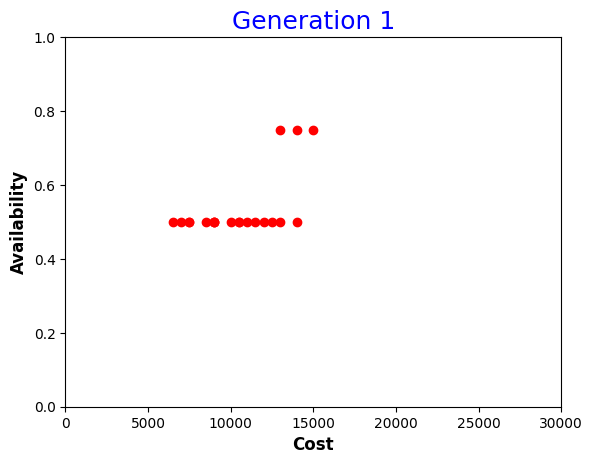



 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [4, 4, 4, 3, 1, 1, 4] [0, 1, 2, 4, 2, 4, 0]
Cross from gene: 2

   Child 1 [4, 4, 2, 4, 2, 4, 0]
   Child 2 [0, 1, 4, 3, 1, 1, 4] 

Parents [3, 0, 2, 4, 4, 4, 1] [4, 2, 3, 3, 4, 3, 0]
Cross from gene: 5

   Child 1 [3, 0, 2, 4, 4, 3, 0]
   Child 2 [4, 2, 3, 3, 4, 4, 1] 

Parents [0, 4, 4, 3, 4, 3, 2] [3, 2, 4, 3, 3, 1, 2]
Cross from gene: 4

   Child 1 [0, 4, 4, 3, 3, 1, 2]
   Child 2 [3, 2, 4, 3, 4, 3, 2] 

Parents [1, 0, 3, 1, 3, 2, 4] [2, 0, 3, 2, 2, 0, 3]
Cross from gene: 5

   Child 1 [1, 0, 3, 1, 3, 0, 3]
   Child 2 [2, 0, 3, 2, 2, 2, 4] 

Parents [4, 2, 4, 4, 3, 2, 2] [1, 4, 4, 4, 0, 1, 1]
Cross from gene: 2

   Child 1 [4, 2, 4, 4, 0, 1, 1]
   Child 2 [1, 4, 4, 4, 3, 2, 2] 


Number of Crossover Children: 10 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [1, 4, 3, 3, 1, 0, 4] not mutated
individual [0, 3, 4, 1, 4, 0, 3] not mutated
individual [2, 2, 2, 3, 3, 1, 0] not mutated
individual [3, 4, 3, 3, 3, 0, 

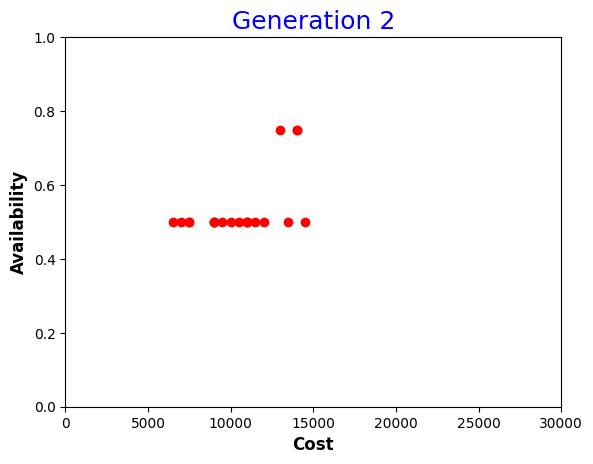

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [2, 0, 3, 2, 2, 2, 4] [1, 0, 3, 1, 3, 0, 3]
Cross from gene: 6

   Child 1 [2, 0, 3, 2, 2, 2, 3]
   Child 2 [1, 0, 3, 1, 3, 0, 4] 

Parents [2, 0, 3, 2, 2, 2, 4] [3, 2, 4, 3, 4, 3, 2]
Cross from gene: 2

   Child 1 [2, 0, 4, 3, 4, 3, 2]
   Child 2 [3, 2, 3, 2, 2, 2, 4] 

Parents [0, 4, 4, 3, 3, 1, 2] [2, 3, 4, 0, 3, 0, 3]
Cross from gene: 3

   Child 1 [0, 4, 4, 0, 3, 0, 3]
   Child 2 [2, 3, 4, 3, 3, 1, 2] 

Parents [1, 1, 3, 2, 2, 3, 3] [4, 2, 4, 4, 0, 1, 1]
Cross from gene: 2

   Child 1 [1, 1, 4, 4, 0, 1, 1]
   Child 2 [4, 2, 3, 2, 2, 3, 3] 

Parents [4, 2, 3, 3, 4, 4, 1] [4, 2, 4, 4, 0, 1, 1]
Cross from gene: 3

   Child 1 [4, 2, 3, 4, 0, 1, 1]

   Child 2 does not comply with the constraints

Parents [0, 3, 4, 1, 4, 0, 3] [0, 1, 4, 3, 1, 1, 4]
Cross from gene: 6

   Child 1 [0, 3, 4, 1, 4, 0, 4]
   Child 2 [0, 1, 4, 3, 1, 1, 3] 

Parents [2, 0, 3, 2, 2, 2, 4] [4, 2, 3, 3, 4, 4, 1]
Cross from gene: 6

   Child 1 [2, 0

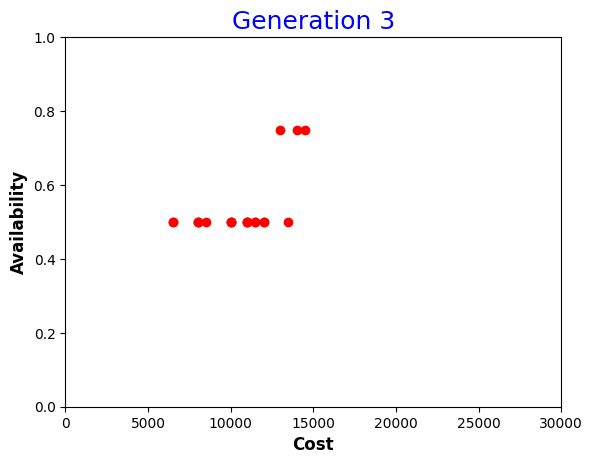

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 1, 4, 4, 0, 1, 1] [0, 4, 4, 0, 3, 0, 3]
Cross from gene: 6

   Child 1 [1, 1, 4, 4, 0, 1, 3]
   Child 2 [0, 4, 4, 0, 3, 0, 1] 

Parents [3, 2, 3, 2, 2, 2, 4] [1, 4, 3, 3, 1, 0, 4]
Cross from gene: 6

   Child 1 [3, 2, 3, 2, 2, 2, 4]
   Child 2 [1, 4, 3, 3, 1, 0, 4] 

Parents [0, 3, 4, 1, 4, 0, 4] [3, 0, 2, 4, 4, 3, 0]
Cross from gene: 6

   Child 1 [0, 3, 4, 1, 4, 0, 0]
   Child 2 [3, 0, 2, 4, 4, 3, 4] 

Parents [4, 2, 3, 4, 0, 1, 1] [0, 3, 4, 1, 4, 0, 4]
Cross from gene: 1

   Child 1 [4, 3, 4, 1, 4, 0, 4]

   Child 2 does not comply with the constraints

Parents [4, 2, 3, 4, 0, 1, 1] [1, 1, 4, 4, 0, 1, 1]
Cross from gene: 4

   Child 1 [4, 2, 3, 4, 0, 1, 1]
   Child 2 [1, 1, 4, 4, 0, 1, 1] 

Parents [1, 4, 4, 4, 3, 2, 2] [3, 0, 2, 4, 4, 3, 0]
Cross from gene: 5

   Child 1 [1, 4, 4, 4, 3, 3, 0]
   Child 2 [3, 0, 2, 4, 4, 2, 2] 

Parents [3, 2, 3, 2, 2, 2, 4] [1, 4, 3, 3, 1, 0, 4]
Cross from gene: 1

   Child 1 [3, 4

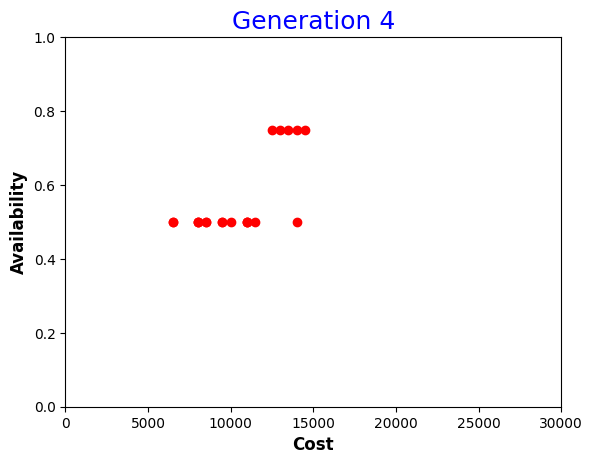

[0, 1, 13]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [2, 3, 4, 3, 1, 0, 4] [3, 0, 2, 4, 4, 3, 4]
Cross from gene: 4

   Child 1 does not comply with the constraints

   Child 2 [3, 0, 2, 4, 1, 0, 4] 

Parents [1, 4, 3, 3, 4, 4, 1] [4, 2, 3, 4, 0, 1, 1]
Cross from gene: 6

   Child 1 [1, 4, 3, 3, 4, 4, 1]
   Child 2 [4, 2, 3, 4, 0, 1, 1] 

Parents [1, 1, 4, 4, 0, 1, 1] [1, 1, 4, 4, 0, 1, 3]
Cross from gene: 5

   Child 1 [1, 1, 4, 4, 0, 1, 3]
   Child 2 [1, 1, 4, 4, 0, 1, 1] 

Parents [1, 0, 3, 1, 3, 0, 4] [1, 4, 3, 3, 4, 4, 1]
Cross from gene: 6

   Child 1 [1, 0, 3, 1, 3, 0, 1]

   Child 2 does not comply with the constraints

Parents [3, 2, 3, 2, 2, 2, 4] [0, 4, 4, 0, 3, 0, 1]
Cross from gene: 2

   Child 1 [3, 2, 4, 0, 3, 0, 1]
   Child 2 [0, 4, 3, 2, 2, 2, 4] 

Parents [1, 1, 4, 4, 0, 1, 3] [3, 2, 3, 2, 2, 2, 4]
Cross from gene: 3

   Child 1 [1, 1, 4, 2, 2, 2, 4]
   Child 2 [3, 2, 3, 4, 0, 1, 3] 

Parents [3, 0, 2, 4, 4, 2, 2] [1, 1, 4, 4, 0, 1, 1]
Cross from gene:

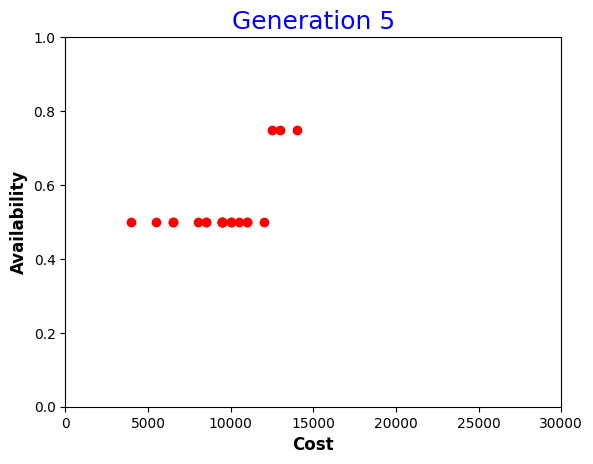

[0, 2, 14]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [2, 0, 3, 2, 2, 2, 1] [1, 1, 4, 4, 3, 0, 4]
Cross from gene: 1

   Child 1 [2, 1, 4, 4, 3, 0, 4]
   Child 2 [1, 0, 3, 2, 2, 2, 1] 

Parents [1, 1, 4, 4, 0, 1, 1] [1, 4, 3, 3, 1, 0, 4]
Cross from gene: 2

   Child 1 [1, 1, 3, 3, 1, 0, 4]
   Child 2 [1, 4, 4, 4, 0, 1, 1] 

Parents [1, 1, 4, 2, 2, 2, 4] [1, 0, 3, 1, 3, 0, 1]
Cross from gene: 1

   Child 1 [1, 0, 3, 1, 3, 0, 1]
   Child 2 [1, 1, 4, 2, 2, 2, 4] 

Parents [3, 2, 3, 4, 0, 1, 3] [1, 4, 3, 3, 1, 0, 4]
Cross from gene: 2

   Child 1 [3, 2, 3, 3, 1, 0, 4]
   Child 2 [1, 4, 3, 4, 0, 1, 3] 

Parents [3, 2, 3, 4, 0, 1, 3] [1, 4, 3, 3, 1, 0, 4]
Cross from gene: 6

   Child 1 [3, 2, 3, 4, 0, 1, 4]
   Child 2 [1, 4, 3, 3, 1, 0, 3] 

Parents [3, 2, 4, 0, 3, 0, 1] [0, 4, 3, 2, 2, 2, 4]
Cross from gene: 5

   Child 1 [3, 2, 4, 0, 3, 2, 4]
   Child 2 [0, 4, 3, 2, 2, 0, 1] 

Parents [3, 1, 4, 4, 0, 1, 1] [1, 0, 2, 4, 4, 2, 2]
Cross from gene: 4

   Child 1 [3, 1, 4, 4, 4, 

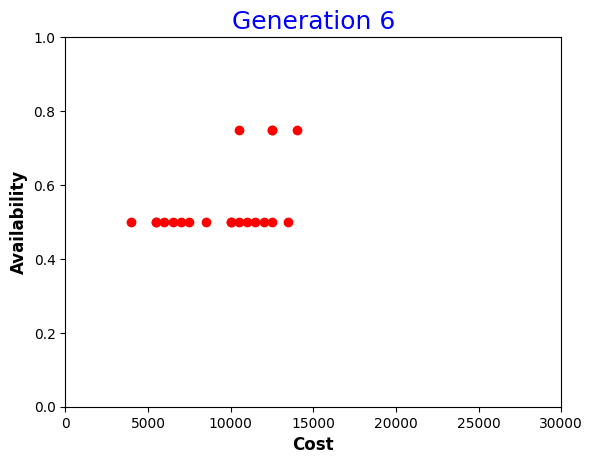

[2, 16]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [3, 0, 2, 4, 1, 0, 1] [3, 1, 4, 4, 4, 2, 2]
Cross from gene: 2

   Child 1 [3, 0, 4, 4, 4, 2, 2]
   Child 2 [3, 1, 2, 4, 1, 0, 1] 

Parents [1, 4, 3, 3, 4, 4, 1] [3, 0, 2, 4, 1, 0, 1]
Cross from gene: 2

   Child 1 [1, 4, 2, 4, 1, 0, 1]
   Child 2 [3, 0, 3, 3, 4, 4, 1] 

Parents [0, 4, 3, 2, 2, 0, 1] [1, 4, 4, 4, 0, 1, 1]
Cross from gene: 1

   Child 1 does not comply with the constraints

   Child 2 [1, 4, 3, 2, 2, 0, 1] 

Parents [1, 4, 3, 3, 4, 4, 1] [4, 2, 3, 4, 0, 1, 4]
Cross from gene: 4

   Child 1 [1, 4, 3, 3, 0, 1, 4]

   Child 2 does not comply with the constraints

Parents [3, 0, 2, 4, 1, 0, 1] [2, 1, 4, 4, 3, 0, 4]
Cross from gene: 6

   Child 1 [3, 0, 2, 4, 1, 0, 4]
   Child 2 [2, 1, 4, 4, 3, 0, 1] 

Parents [2, 1, 4, 4, 3, 0, 4] [3, 0, 2, 4, 1, 0, 1]
Cross from gene: 5

   Child 1 [2, 1, 4, 4, 3, 0, 1]
   Child 2 [3, 0, 2, 4, 1, 0, 4] 

Parents [4, 2, 3, 4, 0, 1, 4] [1, 4, 3, 4, 0, 1, 3]
Cross from gene: 4


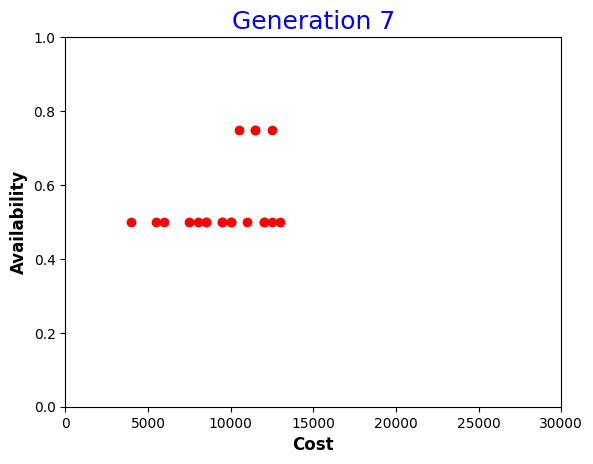

[1, 8]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 4, 3, 4, 0, 1, 4] [4, 2, 3, 4, 0, 1, 3]
Cross from gene: 4

   Child 1 [1, 4, 3, 4, 0, 1, 3]
   Child 2 [4, 2, 3, 4, 0, 1, 4] 

Parents [2, 1, 4, 4, 3, 0, 1] [2, 1, 4, 4, 3, 0, 1]
Cross from gene: 4

   Child 1 [2, 1, 4, 4, 3, 0, 1]
   Child 2 [2, 1, 4, 4, 3, 0, 1] 

Parents [3, 0, 3, 3, 4, 4, 1] [1, 0, 3, 1, 3, 0, 1]
Cross from gene: 5

   Child 1 [3, 0, 3, 3, 4, 0, 1]
   Child 2 [1, 0, 3, 1, 3, 4, 1] 

Parents [1, 0, 3, 1, 3, 0, 1] [1, 4, 3, 3, 0, 1, 4]
Cross from gene: 1

   Child 1 [1, 4, 3, 3, 0, 1, 4]
   Child 2 [1, 0, 3, 1, 3, 0, 1] 

Parents [2, 1, 4, 4, 3, 0, 1] [3, 4, 3, 3, 1, 0, 4]
Cross from gene: 3

   Child 1 [2, 1, 4, 3, 1, 0, 4]
   Child 2 [3, 4, 3, 4, 3, 0, 1] 

Parents [1, 4, 3, 4, 0, 1, 4] [3, 4, 3, 3, 1, 0, 4]
Cross from gene: 6

   Child 1 [1, 4, 3, 4, 0, 1, 4]
   Child 2 [3, 4, 3, 3, 1, 0, 4] 

Parents [3, 0, 3, 3, 4, 4, 1] [1, 4, 2, 4, 1, 0, 1]
Cross from gene: 4

   Child 1 [3, 0, 3, 3, 1, 0, 1

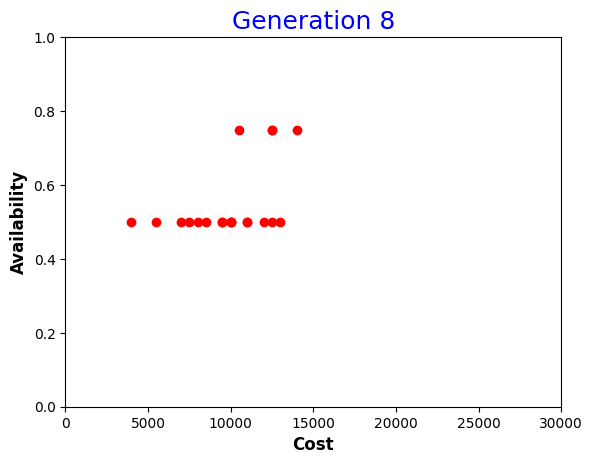

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 0, 3, 1, 3, 0, 1] [2, 1, 4, 4, 3, 0, 1]
Cross from gene: 6

   Child 1 [1, 0, 3, 1, 3, 0, 1]
   Child 2 [2, 1, 4, 4, 3, 0, 1] 

Parents [1, 0, 3, 1, 3, 4, 1] [3, 0, 4, 4, 4, 2, 2]
Cross from gene: 6

   Child 1 [1, 0, 3, 1, 3, 4, 2]
   Child 2 [3, 0, 4, 4, 4, 2, 1] 

Parents [1, 4, 3, 4, 0, 1, 4] [1, 0, 3, 1, 3, 0, 1]
Cross from gene: 5

   Child 1 [1, 4, 3, 4, 0, 0, 1]
   Child 2 [1, 0, 3, 1, 3, 1, 4] 

Parents [1, 4, 3, 4, 0, 1, 3] [2, 1, 4, 4, 3, 0, 1]
Cross from gene: 1

   Child 1 [1, 1, 4, 4, 3, 0, 1]
   Child 2 [2, 4, 3, 4, 0, 1, 3] 

Parents [1, 4, 3, 3, 0, 1, 4] [2, 1, 4, 4, 3, 0, 1]
Cross from gene: 5

   Child 1 [1, 4, 3, 3, 0, 0, 1]
   Child 2 [2, 1, 4, 4, 3, 1, 4] 

Parents [1, 4, 3, 3, 0, 1, 4] [2, 1, 4, 4, 3, 0, 1]
Cross from gene: 3

   Child 1 [1, 4, 3, 4, 3, 0, 1]
   Child 2 [2, 1, 4, 3, 0, 1, 4] 


Number of Crossover Children: 12 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [4, 2, 

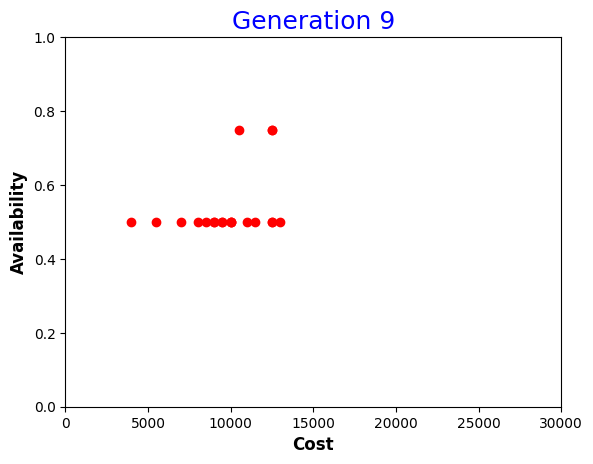

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [2, 1, 4, 4, 3, 1, 4] [3, 4, 3, 4, 3, 0, 1]
Cross from gene: 1

   Child 1 [2, 4, 3, 4, 3, 0, 1]
   Child 2 [3, 1, 4, 4, 3, 1, 4] 

Parents [1, 4, 3, 4, 0, 0, 1] [3, 0, 3, 3, 4, 0, 1]
Cross from gene: 3

   Child 1 [1, 4, 3, 3, 4, 0, 1]
   Child 2 [3, 0, 3, 4, 0, 0, 1] 

Parents [1, 4, 3, 4, 0, 0, 1] [4, 2, 3, 4, 1, 0, 4]
Cross from gene: 6

   Child 1 [1, 4, 3, 4, 0, 0, 4]
   Child 2 [4, 2, 3, 4, 1, 0, 1] 

Parents [1, 4, 3, 4, 3, 0, 1] [1, 1, 4, 4, 3, 0, 1]
Cross from gene: 1

   Child 1 [1, 1, 4, 4, 3, 0, 1]
   Child 2 [1, 4, 3, 4, 3, 0, 1] 

Parents [3, 4, 3, 4, 3, 0, 1] [1, 0, 3, 1, 3, 4, 2]
Cross from gene: 5

   Child 1 does not comply with the constraints

   Child 2 [1, 0, 3, 1, 3, 0, 1] 

Parents [2, 1, 4, 4, 3, 0, 1] [3, 0, 3, 3, 1, 0, 1]
Cross from gene: 1

   Child 1 [2, 0, 3, 3, 1, 0, 1]
   Child 2 [3, 1, 4, 4, 3, 0, 1] 

Parents [3, 0, 3, 3, 1, 0, 1] [4, 2, 3, 4, 1, 0, 4]
Cross from gene: 6

   Child 1 [3, 

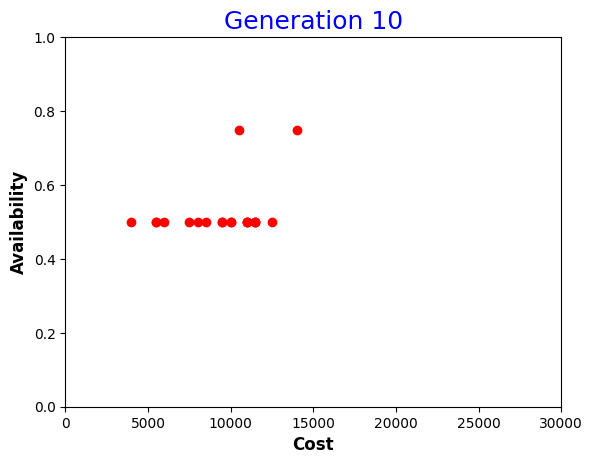

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [3, 0, 4, 4, 4, 2, 1] [1, 0, 3, 1, 3, 0, 1]
Cross from gene: 6

   Child 1 [3, 0, 4, 4, 4, 2, 1]
   Child 2 [1, 0, 3, 1, 3, 0, 1] 

Parents [1, 0, 3, 1, 3, 0, 1] [1, 4, 3, 4, 3, 0, 1]
Cross from gene: 3

   Child 1 [1, 0, 3, 4, 3, 0, 1]
   Child 2 [1, 4, 3, 1, 3, 0, 1] 

Parents [4, 2, 3, 4, 1, 0, 1] [3, 0, 3, 4, 0, 0, 1]
Cross from gene: 2

   Child 1 [4, 2, 3, 4, 0, 0, 1]
   Child 2 [3, 0, 3, 4, 1, 0, 1] 

Parents [1, 0, 3, 1, 3, 1, 4] [3, 1, 4, 4, 3, 1, 4]
Cross from gene: 4

   Child 1 [1, 0, 3, 1, 3, 1, 4]
   Child 2 [3, 1, 4, 4, 3, 1, 4] 

Parents [1, 4, 3, 3, 0, 0, 1] [1, 1, 4, 4, 3, 0, 1]
Cross from gene: 1

   Child 1 [1, 1, 4, 4, 3, 0, 1]
   Child 2 [1, 4, 3, 3, 0, 0, 1] 


Number of Crossover Children: 10 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [2, 4, 3, 4, 3, 0, 1] not mutated
individual [1, 4, 3, 3, 4, 0, 1] not mutated
individual [1, 4, 3, 4, 0, 0, 4] not mutated
individual [4, 2, 3, 4,

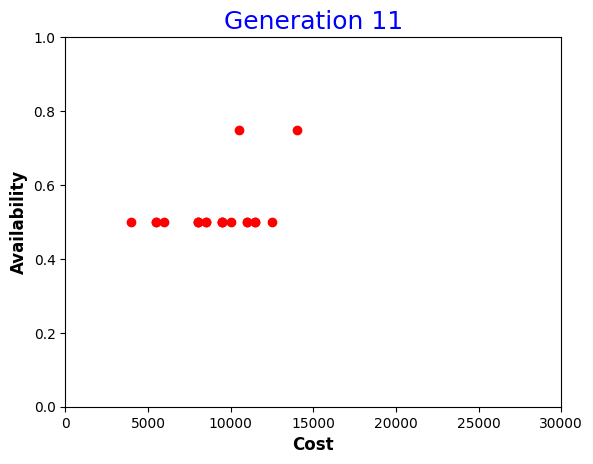

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [3, 0, 4, 4, 4, 2, 1] [1, 1, 4, 4, 3, 0, 1]
Cross from gene: 2

   Child 1 [3, 0, 4, 4, 3, 0, 1]
   Child 2 [1, 1, 4, 4, 4, 2, 1] 

Parents [3, 1, 4, 4, 3, 1, 4] [1, 4, 3, 3, 0, 0, 1]
Cross from gene: 6

   Child 1 [3, 1, 4, 4, 3, 1, 1]
   Child 2 [1, 4, 3, 3, 0, 0, 4] 

Parents [2, 0, 3, 3, 1, 0, 1] [4, 2, 3, 4, 0, 0, 1]
Cross from gene: 4

   Child 1 [2, 0, 3, 3, 0, 0, 1]
   Child 2 [4, 2, 3, 4, 1, 0, 1] 

Parents [1, 1, 4, 4, 3, 0, 1] [1, 4, 3, 3, 4, 0, 1]
Cross from gene: 4

   Child 1 [1, 1, 4, 4, 4, 0, 1]
   Child 2 [1, 4, 3, 3, 3, 0, 1] 

Parents [3, 1, 4, 4, 3, 0, 1] [1, 0, 3, 1, 3, 1, 4]
Cross from gene: 1

   Child 1 [3, 0, 3, 1, 3, 1, 4]
   Child 2 [1, 1, 4, 4, 3, 0, 1] 


Number of Crossover Children: 10 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [1, 0, 3, 1, 3, 0, 1] not mutated
individual [1, 0, 3, 4, 3, 0, 1] not mutated
individual [1, 4, 3, 1, 3, 0, 1] mutate to ----->  [0, 4, 3, 3, 3, 0

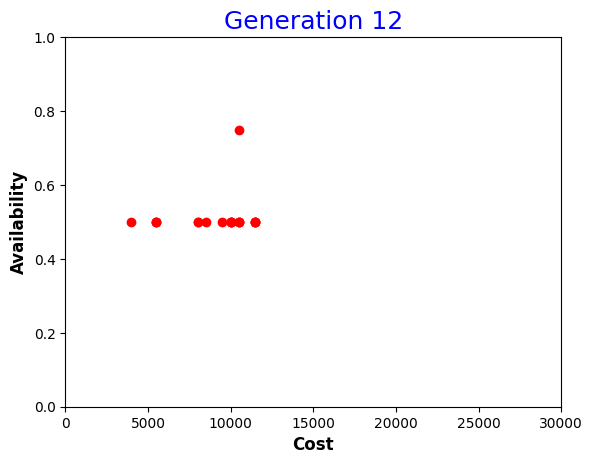

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 0, 3, 1, 3, 1, 1] [1, 1, 4, 4, 4, 2, 1]
Cross from gene: 1

   Child 1 [1, 1, 4, 4, 4, 2, 1]
   Child 2 [1, 0, 3, 1, 3, 1, 1] 

Parents [1, 0, 3, 1, 3, 0, 1] [3, 0, 3, 1, 3, 1, 4]
Cross from gene: 6

   Child 1 [1, 0, 3, 1, 3, 0, 4]
   Child 2 [3, 0, 3, 1, 3, 1, 1] 

Parents [2, 0, 3, 3, 0, 0, 1] [3, 0, 3, 4, 1, 0, 1]
Cross from gene: 6

   Child 1 [2, 0, 3, 3, 0, 0, 1]
   Child 2 [3, 0, 3, 4, 1, 0, 1] 

Parents [2, 0, 3, 3, 0, 0, 1] [3, 0, 3, 4, 1, 0, 1]
Cross from gene: 2

   Child 1 [2, 0, 3, 4, 1, 0, 1]
   Child 2 [3, 0, 3, 3, 0, 0, 1] 

Parents [3, 1, 4, 4, 3, 1, 1] [2, 4, 3, 4, 3, 0, 1]
Cross from gene: 6

   Child 1 [3, 1, 4, 4, 3, 1, 1]
   Child 2 [2, 4, 3, 4, 3, 0, 1] 

Parents [0, 4, 3, 3, 3, 0, 1] [4, 2, 4, 3, 1, 0, 1]
Cross from gene: 4

   Child 1 [0, 4, 3, 3, 1, 0, 1]
   Child 2 [4, 2, 4, 3, 3, 0, 1] 

Parents [1, 4, 3, 3, 0, 0, 4] [1, 0, 3, 1, 3, 0, 1]
Cross from gene: 6

   Child 1 [1, 4, 3, 3, 0, 0, 1

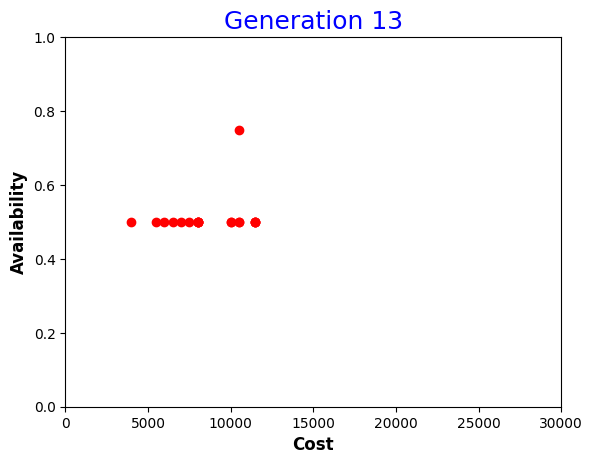

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 0, 3, 1, 3, 1, 1] [1, 4, 4, 0, 3, 0, 1]
Cross from gene: 2

   Child 1 [1, 0, 4, 0, 3, 0, 1]
   Child 2 [1, 4, 3, 1, 3, 1, 1] 

Parents [1, 1, 4, 4, 4, 2, 1] [2, 4, 3, 4, 3, 0, 1]
Cross from gene: 5

   Child 1 [1, 1, 4, 4, 4, 0, 1]
   Child 2 [2, 4, 3, 4, 3, 2, 1] 

Parents [3, 0, 3, 1, 3, 1, 1] [4, 2, 3, 4, 1, 0, 1]
Cross from gene: 6

   Child 1 [3, 0, 3, 1, 3, 1, 1]
   Child 2 [4, 2, 3, 4, 1, 0, 1] 

Parents [2, 4, 3, 4, 3, 0, 1] [3, 1, 4, 4, 3, 1, 1]
Cross from gene: 2

   Child 1 [2, 4, 4, 4, 3, 1, 1]
   Child 2 [3, 1, 3, 4, 3, 0, 1] 

Parents [2, 0, 3, 4, 1, 0, 1] [1, 0, 3, 1, 3, 1, 1]
Cross from gene: 6

   Child 1 [2, 0, 3, 4, 1, 0, 1]
   Child 2 [1, 0, 3, 1, 3, 1, 1] 

Parents [2, 4, 3, 4, 3, 0, 1] [3, 0, 3, 4, 1, 0, 1]
Cross from gene: 1

   Child 1 [2, 0, 3, 4, 1, 0, 1]
   Child 2 [3, 4, 3, 4, 3, 0, 1] 

Parents [3, 0, 3, 4, 1, 0, 1] [1, 1, 4, 4, 4, 2, 1]
Cross from gene: 2

   Child 1 [3, 0, 4, 4, 4, 2, 1

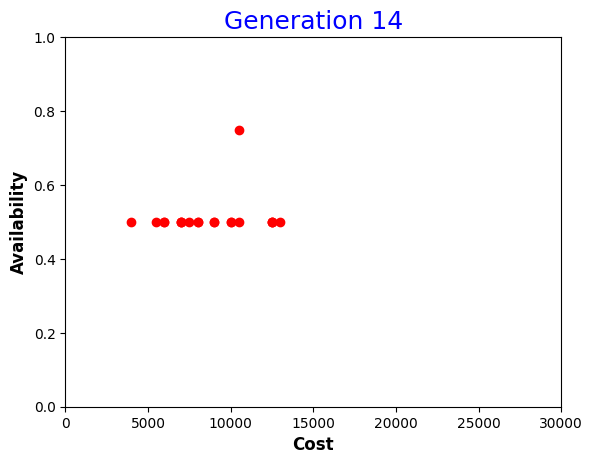

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [2, 4, 4, 4, 3, 1, 1] [3, 0, 4, 4, 4, 2, 1]
Cross from gene: 6

   Child 1 [2, 4, 4, 4, 3, 1, 1]
   Child 2 [3, 0, 4, 4, 4, 2, 1] 

Parents [2, 0, 3, 4, 1, 0, 1] [2, 4, 3, 4, 3, 2, 1]
Cross from gene: 3

   Child 1 [2, 0, 3, 4, 3, 2, 1]
   Child 2 [2, 4, 3, 4, 1, 0, 1] 

Parents [2, 0, 3, 4, 1, 0, 1] [1, 4, 3, 1, 3, 1, 1]
Cross from gene: 3

   Child 1 [2, 0, 3, 1, 3, 1, 1]
   Child 2 [1, 4, 3, 4, 1, 0, 1] 

Parents [1, 0, 3, 1, 3, 1, 1] [2, 0, 3, 3, 0, 0, 1]
Cross from gene: 4

   Child 1 [1, 0, 3, 1, 0, 0, 1]
   Child 2 [2, 0, 3, 3, 3, 1, 1] 

Parents [1, 0, 3, 1, 3, 1, 1] [3, 0, 4, 4, 4, 2, 1]
Cross from gene: 6

   Child 1 [1, 0, 3, 1, 3, 1, 1]
   Child 2 [3, 0, 4, 4, 4, 2, 1] 

Parents [2, 4, 3, 4, 3, 2, 1] [3, 0, 3, 1, 3, 1, 1]
Cross from gene: 1

   Child 1 [2, 0, 3, 1, 3, 1, 1]
   Child 2 [3, 4, 3, 4, 3, 2, 1] 


Number of Crossover Children: 12 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [1, 0, 

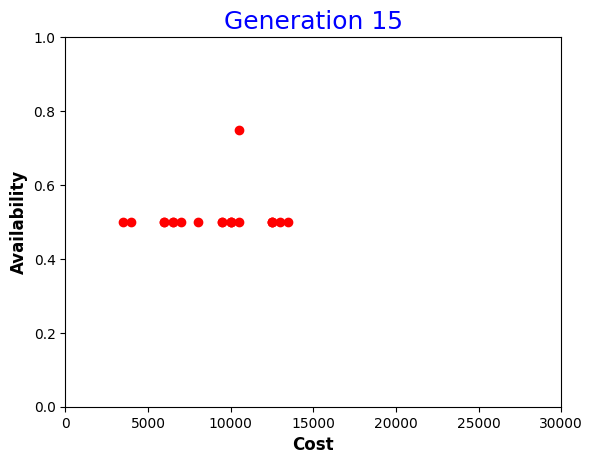

[0, 1]


In [ ]:
if __name__ == '__main__':
    main()


With pc=0.8

Cost: 4000.0 Availability: 0.5

Cost: 10500.0 Availability: 0.75


GENERATION: 1 

Individual: [1, 1, 3, 3, 1, 2, 0] Cost: 6500.0 Availability: 0.5
Individual: [1, 1, 4, 3, 4, 0, 4] Cost: 12000.0 Availability: 0.5
Individual: [0, 3, 3, 4, 2, 1, 0] Cost: 8500.0 Availability: 0.5
Individual: [4, 1, 2, 0, 2, 1, 2] Cost: 7000.0 Availability: 0.5
Individual: [2, 4, 3, 4, 2, 0, 0] Cost: 10000.0 Availability: 0.5
Individual: [1, 0, 4, 0, 2, 4, 3] Cost: 9500.0 Availability: 0.5
Individual: [3, 4, 2, 1, 3, 3, 1] Cost: 11000.0 Availability: 0.75
Individual: [0, 3, 2, 2, 2, 1, 3] Cost: 7500.0 Availability: 0.5
Individual: [0, 4, 4, 1, 3, 4, 0] Cost: 11500.0 Availability: 0.75
Individual: [3, 2, 3, 1, 4, 4, 4] Cost: 14500.0 Availability: 0.5
Individual: [0, 4, 4, 0, 1, 3, 1] Cost: 9000.0 Availability: 0.75
Individual: [1, 4, 2, 4, 2, 3, 3] Cost: 12500.0 Availability: 0.75
Individual: [3, 2, 2, 0, 1, 3, 0] Cost: 6500.0 Availability: 0.5
Individual: [3, 4, 4, 2, 3, 2, 1] Cost: 12500.0 Availability: 0.5
Individual: [0, 1, 4, 2, 1, 2, 3] Cost: 8000.0 Availability: 0

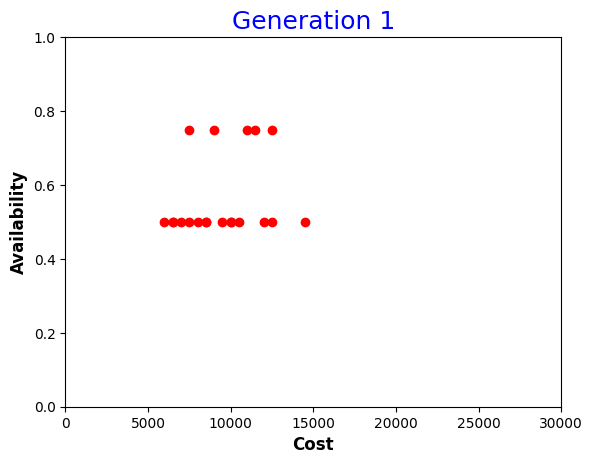



 >>>> CROSSOVER PHASE (with probability 0.2 )


Parents [1, 0, 4, 0, 2, 4, 3] [1, 1, 3, 3, 1, 2, 0]
Cross from gene: 6

   Child 1 [1, 0, 4, 0, 2, 4, 0]
   Child 2 [1, 1, 3, 3, 1, 2, 3] 


Number of Crossover Children: 2 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [1, 1, 4, 3, 4, 0, 4] not mutated
individual [0, 3, 3, 4, 2, 1, 0] not mutated
individual [4, 1, 2, 0, 2, 1, 2] not mutated
individual [2, 4, 3, 4, 2, 0, 0] not mutated
individual [3, 4, 2, 1, 3, 3, 1] not mutated
individual [0, 3, 2, 2, 2, 1, 3] not mutated
individual [0, 4, 4, 1, 3, 4, 0] not mutated
individual [3, 2, 3, 1, 4, 4, 4] not mutated
individual [0, 4, 4, 0, 1, 3, 1] mutate to ----->  [0, 2, 4, 0, 3, 3, 1]
individual [1, 4, 2, 4, 2, 3, 3] not mutated
individual [3, 2, 2, 0, 1, 3, 0] mutate to ----->  [1, 2, 2, 0, 1, 4, 0]
individual [3, 4, 4, 2, 3, 2, 1] not mutated
individual [0, 1, 4, 2, 1, 2, 3] not mutated
individual [3, 4, 2, 0, 1, 1, 4] not mutated
individual [4, 2, 2, 3, 3, 1, 2] not mut

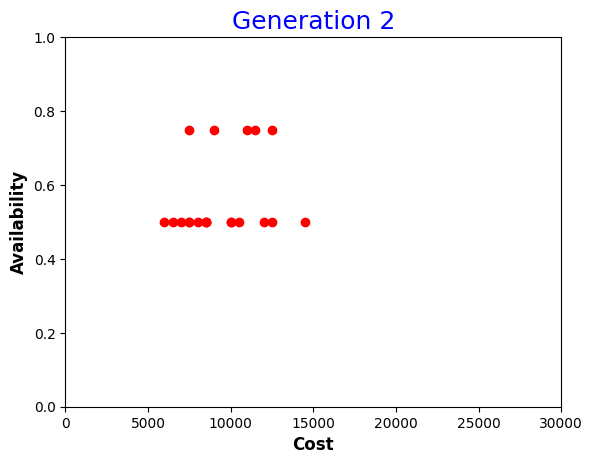

[16, 17]


 >>>> CROSSOVER PHASE (with probability 0.2 )


Parents [0, 2, 4, 0, 3, 3, 1] [3, 4, 2, 0, 1, 1, 4]
Cross from gene: 3

   Child 1 [0, 2, 4, 0, 1, 1, 4]
   Child 2 [3, 4, 2, 0, 3, 3, 1] 

Parents [0, 3, 2, 2, 2, 1, 3] [3, 4, 4, 2, 3, 2, 1]
Cross from gene: 2

   Child 1 [0, 3, 4, 2, 3, 2, 1]
   Child 2 [3, 4, 2, 2, 2, 1, 3] 

Parents [1, 0, 4, 0, 2, 4, 0] [1, 1, 3, 3, 1, 2, 3]
Cross from gene: 3

   Child 1 [1, 0, 4, 3, 1, 2, 3]
   Child 2 [1, 1, 3, 0, 2, 4, 0] 


Number of Crossover Children: 6 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [1, 1, 4, 3, 4, 0, 4] not mutated
individual [0, 3, 3, 4, 2, 1, 0] mutate to ----->  [0, 4, 3, 4, 2, 1, 0]
individual [4, 1, 2, 0, 2, 1, 2] not mutated
individual [2, 4, 3, 4, 2, 0, 0] not mutated
individual [3, 4, 2, 1, 3, 3, 1] not mutated
individual [0, 4, 4, 1, 3, 4, 0] not mutated
individual [3, 2, 3, 1, 4, 4, 4] not mutated
individual [1, 4, 2, 4, 2, 3, 3] not mutated
individual [1, 2, 2, 0, 1, 4, 0] not mutated
indi

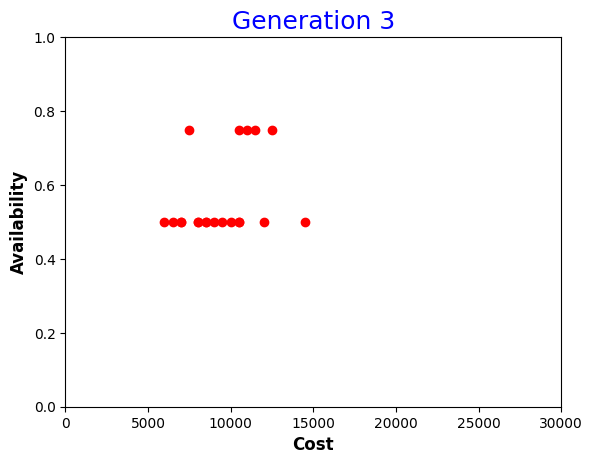

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.2 )


Parents [2, 4, 3, 4, 2, 0, 0] [0, 3, 4, 2, 3, 2, 1]
Cross from gene: 2

   Child 1 [2, 4, 4, 2, 3, 2, 1]
   Child 2 [0, 3, 3, 4, 2, 0, 0] 

Parents [1, 4, 2, 4, 2, 3, 3] [0, 4, 4, 1, 3, 4, 0]
Cross from gene: 3

   Child 1 [1, 4, 2, 1, 3, 4, 0]
   Child 2 [0, 4, 4, 4, 2, 3, 3] 


Number of Crossover Children: 4 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [0, 2, 4, 0, 1, 1, 4] not mutated
individual [3, 4, 2, 0, 3, 3, 1] not mutated
individual [3, 4, 2, 2, 2, 1, 3] not mutated
individual [1, 0, 4, 3, 1, 2, 3] not mutated
individual [1, 1, 3, 0, 2, 4, 0] not mutated
individual [1, 1, 4, 3, 4, 0, 4] not mutated
individual [0, 4, 3, 4, 2, 1, 0] not mutated
individual [4, 1, 2, 0, 2, 1, 2] not mutated
individual [3, 4, 2, 1, 3, 3, 1] not mutated
individual [3, 2, 3, 1, 4, 4, 4] not mutated
individual [1, 2, 2, 0, 1, 4, 0] not mutated
individual [0, 1, 4, 2, 1, 2, 3] not mutated
individual [4, 2, 2, 3, 3, 1, 2] not mu

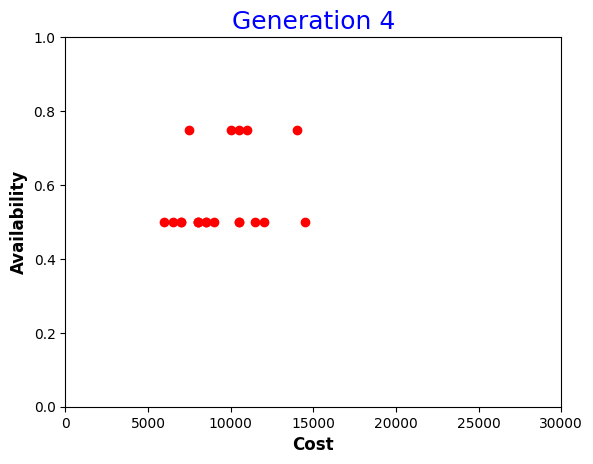

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.2 )


Parents [0, 4, 4, 4, 2, 3, 3] [3, 4, 2, 2, 2, 1, 3]
Cross from gene: 2

   Child 1 [0, 4, 2, 2, 2, 1, 3]

   Child 2 does not comply with the constraints

Parents [3, 4, 2, 0, 3, 3, 1] [3, 4, 2, 2, 2, 1, 3]
Cross from gene: 1

   Child 1 [3, 4, 2, 2, 2, 1, 3]
   Child 2 [3, 4, 2, 0, 3, 3, 1] 

Parents [2, 1, 2, 3, 4, 1, 1] [1, 1, 3, 0, 2, 4, 0]
Cross from gene: 4

   Child 1 [2, 1, 2, 3, 2, 4, 0]
   Child 2 [1, 1, 3, 0, 4, 1, 1] 


Number of Crossover Children: 5 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [2, 4, 4, 2, 3, 2, 1] mutate to ----->  [2, 4, 4, 3, 3, 2, 1]
individual [0, 3, 3, 4, 2, 0, 0] mutate to ----->  [0, 1, 4, 4, 2, 0, 0]
individual [1, 4, 2, 1, 3, 4, 0] not mutated
individual [0, 2, 4, 0, 1, 1, 4] not mutated
individual [1, 0, 4, 3, 1, 2, 3] not mutated
individual [1, 1, 4, 3, 4, 0, 4] mutate to ----->  [3, 1, 4, 3, 4, 0, 4]
individual [0, 4, 3, 4, 2, 1, 0] not mutated
individual [4, 1, 2, 0, 2

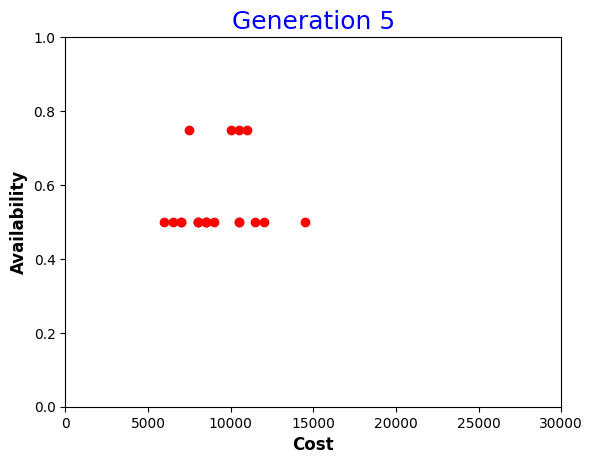

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.2 )


Parents [0, 2, 4, 0, 1, 1, 4] [3, 1, 4, 3, 4, 0, 4]
Cross from gene: 6

   Child 1 [0, 2, 4, 0, 1, 1, 4]
   Child 2 [3, 1, 4, 3, 4, 0, 4] 

Parents [0, 2, 4, 0, 1, 1, 4] [3, 4, 2, 2, 2, 1, 3]
Cross from gene: 1

   Child 1 [0, 4, 2, 2, 2, 1, 3]
   Child 2 [3, 2, 4, 0, 1, 1, 4] 

Parents [0, 4, 3, 4, 2, 1, 0] [3, 4, 2, 1, 3, 3, 1]
Cross from gene: 2

   Child 1 [0, 4, 2, 1, 3, 3, 1]
   Child 2 [3, 4, 3, 4, 2, 1, 0] 

Parents [0, 2, 4, 0, 1, 1, 4] [2, 4, 4, 3, 3, 2, 1]
Cross from gene: 2

   Child 1 [0, 2, 4, 3, 3, 2, 1]
   Child 2 [2, 4, 4, 0, 1, 1, 4] 

Parents [3, 2, 3, 1, 4, 4, 4] [0, 4, 3, 4, 2, 1, 0]
Cross from gene: 4

   Child 1 [3, 2, 3, 1, 2, 1, 0]

   Child 2 does not comply with the constraints


Number of Crossover Children: 9 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [0, 4, 2, 2, 2, 1, 3] not mutated
individual [3, 4, 2, 0, 3, 3, 1] not mutated
individual [2, 1, 2, 3, 2, 4, 0] not mutated
individua

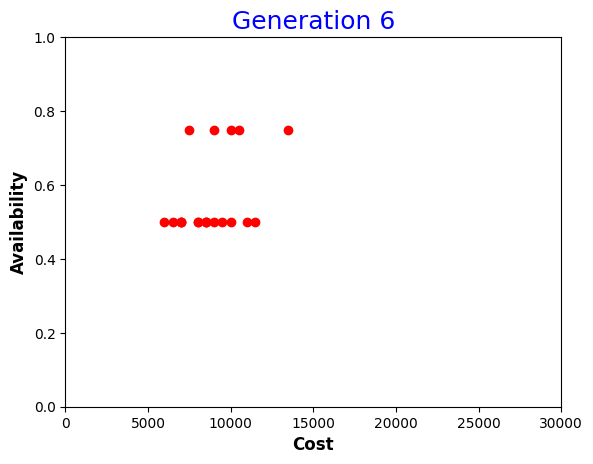

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.2 )


Parents [0, 4, 2, 1, 3, 3, 1] [0, 1, 4, 4, 2, 0, 0]
Cross from gene: 3

   Child 1 [0, 4, 2, 4, 2, 0, 0]
   Child 2 [0, 1, 4, 1, 3, 3, 1] 

Parents [0, 4, 2, 2, 3, 4, 0] [1, 2, 2, 0, 1, 4, 0]
Cross from gene: 2

   Child 1 [0, 4, 2, 0, 1, 4, 0]
   Child 2 [1, 2, 2, 2, 3, 4, 0] 


Number of Crossover Children: 4 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [0, 2, 4, 0, 1, 1, 4] not mutated
individual [3, 1, 4, 3, 4, 0, 4] not mutated
individual [0, 4, 2, 2, 2, 1, 3] not mutated
individual [3, 2, 4, 0, 1, 1, 4] not mutated
individual [3, 4, 3, 4, 2, 1, 0] not mutated
individual [0, 2, 4, 3, 3, 2, 1] not mutated
individual [2, 4, 4, 0, 1, 1, 4] not mutated
individual [3, 2, 3, 1, 2, 1, 0] not mutated
individual [0, 4, 2, 2, 2, 1, 3] not mutated
individual [3, 4, 2, 0, 3, 3, 1] not mutated
individual [2, 1, 2, 3, 2, 4, 0] not mutated
individual [1, 1, 3, 0, 4, 1, 1] not mutated
individual [1, 0, 4, 3, 1, 2, 3] not mu

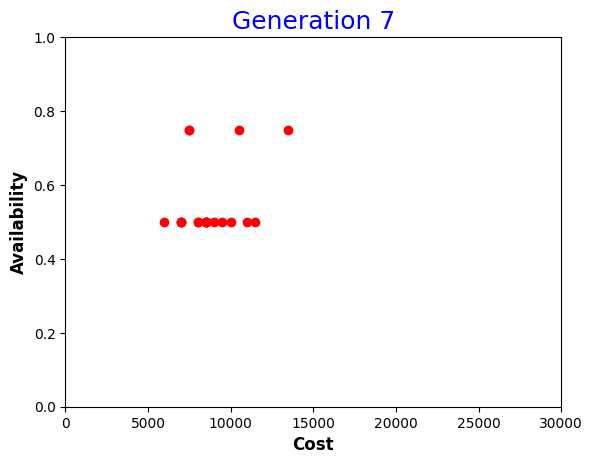

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.2 )


Parents [0, 4, 2, 2, 2, 1, 3] [0, 4, 2, 2, 2, 1, 3]
Cross from gene: 6

   Child 1 [0, 4, 2, 2, 2, 1, 3]
   Child 2 [0, 4, 2, 2, 2, 1, 3] 

Parents [0, 4, 2, 2, 2, 1, 3] [0, 2, 4, 3, 3, 2, 1]
Cross from gene: 5

   Child 1 [0, 4, 2, 2, 2, 2, 1]
   Child 2 [0, 2, 4, 3, 3, 1, 3] 


Number of Crossover Children: 4 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [0, 4, 2, 4, 2, 0, 0] not mutated
individual [0, 1, 4, 1, 3, 3, 1] not mutated
individual [1, 2, 2, 2, 3, 4, 0] not mutated
individual [0, 2, 4, 0, 1, 1, 4] not mutated
individual [3, 1, 4, 3, 4, 0, 4] not mutated
individual [3, 2, 4, 0, 1, 1, 4] not mutated
individual [3, 4, 3, 4, 2, 1, 0] not mutated
individual [2, 4, 4, 0, 1, 1, 4] mutate to ----->  [2, 4, 4, 0, 1, 1, 2]
individual [3, 2, 3, 1, 2, 1, 0] mutate to ----->  [3, 2, 2, 1, 2, 2, 0]
individual [3, 4, 2, 0, 3, 3, 1] not mutated
individual [2, 1, 2, 3, 2, 4, 0] not mutated
individual [1, 1, 3, 0, 4, 1

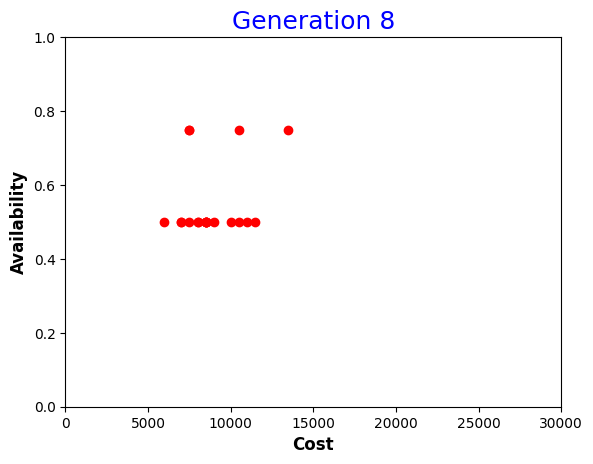

[0, 1, 4]


 >>>> CROSSOVER PHASE (with probability 0.2 )


Parents [3, 4, 2, 0, 3, 3, 1] [2, 1, 2, 3, 2, 4, 0]
Cross from gene: 1

   Child 1 [3, 1, 2, 3, 2, 4, 0]
   Child 2 [2, 4, 2, 0, 3, 3, 1] 

Parents [0, 2, 4, 3, 3, 1, 3] [0, 4, 2, 4, 2, 0, 0]
Cross from gene: 2

   Child 1 [0, 2, 2, 4, 2, 0, 0]
   Child 2 [0, 4, 4, 3, 3, 1, 3] 

Parents [0, 2, 4, 3, 3, 1, 3] [0, 4, 2, 2, 2, 2, 1]
Cross from gene: 4

   Child 1 [0, 2, 4, 3, 2, 2, 1]
   Child 2 [0, 4, 2, 2, 3, 1, 3] 


Number of Crossover Children: 6 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [0, 4, 2, 2, 2, 1, 3] not mutated
individual [0, 4, 2, 2, 2, 1, 3] mutate to ----->  [3, 4, 2, 1, 2, 1, 3]
individual [0, 1, 4, 1, 3, 3, 1] not mutated
individual [1, 2, 2, 2, 3, 4, 0] not mutated
individual [0, 2, 4, 0, 1, 1, 4] not mutated
individual [3, 1, 4, 3, 4, 0, 4] mutate to ----->  [3, 1, 4, 4, 1, 0, 4]
individual [3, 2, 4, 0, 1, 1, 4] not mutated
individual [3, 4, 3, 4, 2, 1, 0] not mutated
individual [2, 4, 4,

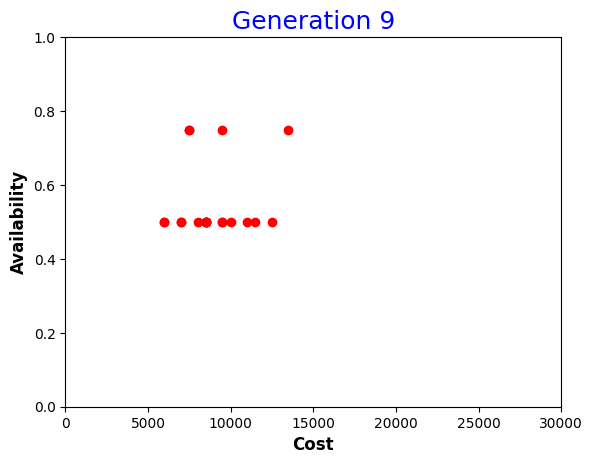

[0, 1, 2]


 >>>> CROSSOVER PHASE (with probability 0.2 )


Parents [0, 1, 4, 1, 3, 3, 1] [2, 4, 4, 0, 1, 1, 2]
Cross from gene: 3

   Child 1 [0, 1, 4, 0, 1, 1, 2]
   Child 2 [2, 4, 4, 1, 3, 3, 1] 

Parents [2, 4, 2, 0, 3, 3, 1] [1, 1, 3, 0, 4, 1, 1]
Cross from gene: 6

   Child 1 [2, 4, 2, 0, 3, 3, 1]
   Child 2 [1, 1, 3, 0, 4, 1, 1] 


Number of Crossover Children: 4 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [3, 1, 2, 3, 2, 4, 0] not mutated
individual [0, 4, 4, 3, 3, 1, 3] not mutated
individual [0, 2, 4, 3, 2, 2, 1] not mutated
individual [0, 4, 2, 2, 3, 1, 3] not mutated
individual [0, 4, 2, 2, 2, 1, 3] not mutated
individual [3, 4, 2, 1, 2, 1, 3] mutate to ----->  [3, 0, 2, 1, 4, 1, 3]
individual [1, 2, 2, 2, 3, 4, 0] not mutated
individual [0, 2, 4, 0, 1, 1, 4] not mutated
individual [3, 1, 4, 4, 1, 0, 4] not mutated
individual [3, 2, 4, 0, 1, 1, 4] not mutated
individual [3, 4, 3, 4, 2, 1, 0] not mutated
individual [3, 2, 2, 1, 2, 2, 0] mutate to ----->  [3

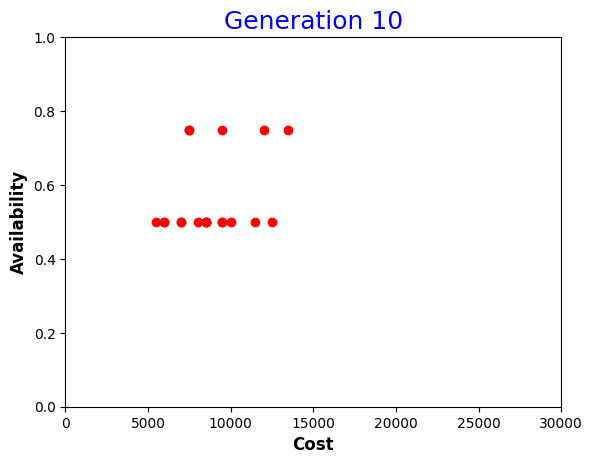

[0, 1, 2, 5]


 >>>> CROSSOVER PHASE (with probability 0.2 )


Parents [3, 0, 2, 1, 4, 1, 3] [1, 1, 3, 0, 4, 1, 1]
Cross from gene: 6

   Child 1 [3, 0, 2, 1, 4, 1, 1]
   Child 2 [1, 1, 3, 0, 4, 1, 3] 


Number of Crossover Children: 2 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [4, 1, 2, 1, 2, 0, 0] not mutated
individual [0, 2, 2, 4, 2, 0, 0] not mutated
individual [2, 4, 4, 1, 3, 3, 1] not mutated
individual [2, 4, 2, 0, 3, 3, 1] not mutated
individual [3, 1, 2, 3, 2, 4, 0] not mutated
individual [0, 4, 4, 3, 3, 1, 3] not mutated
individual [0, 2, 4, 3, 2, 2, 1] not mutated
individual [0, 4, 2, 2, 3, 1, 3] not mutated
individual [0, 4, 2, 2, 2, 1, 3] not mutated
individual [1, 2, 2, 2, 3, 4, 0] not mutated
individual [0, 2, 4, 0, 1, 1, 4] not mutated
individual [3, 1, 4, 4, 1, 0, 4] not mutated
individual [3, 2, 4, 0, 1, 1, 4] not mutated
individual [3, 4, 3, 4, 2, 1, 0] not mutated
individual [3, 2, 2, 1, 2, 2, 3] not mutated

GENERATION: 11 

Individual: [2, 3, 2

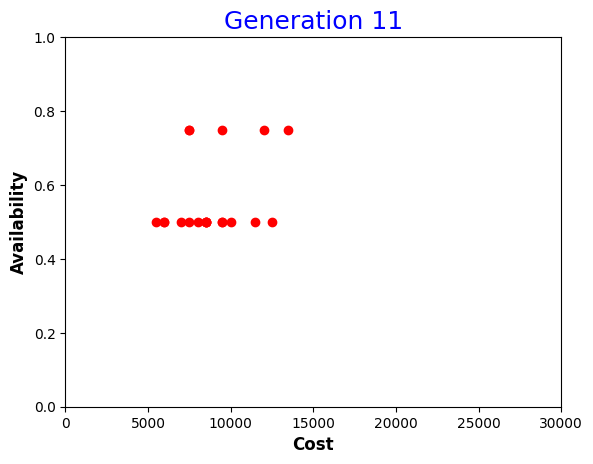

[0, 2, 4]


 >>>> CROSSOVER PHASE (with probability 0.2 )


Parents [0, 4, 2, 2, 2, 1, 3] [2, 4, 4, 1, 3, 3, 1]
Cross from gene: 3

   Child 1 [0, 4, 2, 1, 3, 3, 1]
   Child 2 [2, 4, 4, 2, 2, 1, 3] 

Parents [2, 4, 2, 0, 3, 3, 1] [3, 4, 3, 4, 2, 1, 0]
Cross from gene: 3

   Child 1 [2, 4, 2, 4, 2, 1, 0]
   Child 2 [3, 4, 3, 0, 3, 3, 1] 


Number of Crossover Children: 4 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [3, 0, 2, 1, 4, 1, 1] not mutated
individual [1, 1, 3, 0, 4, 1, 3] not mutated
individual [4, 1, 2, 1, 2, 0, 0] not mutated
individual [0, 2, 2, 4, 2, 0, 0] not mutated
individual [3, 1, 2, 3, 2, 4, 0] not mutated
individual [0, 4, 4, 3, 3, 1, 3] not mutated
individual [0, 2, 4, 3, 2, 2, 1] not mutated
individual [0, 4, 2, 2, 3, 1, 3] not mutated
individual [1, 2, 2, 2, 3, 4, 0] not mutated
individual [0, 2, 4, 0, 1, 1, 4] not mutated
individual [3, 1, 4, 4, 1, 0, 4] not mutated
individual [3, 2, 4, 0, 1, 1, 4] not mutated
individual [3, 2, 2, 1, 2, 2, 3] not

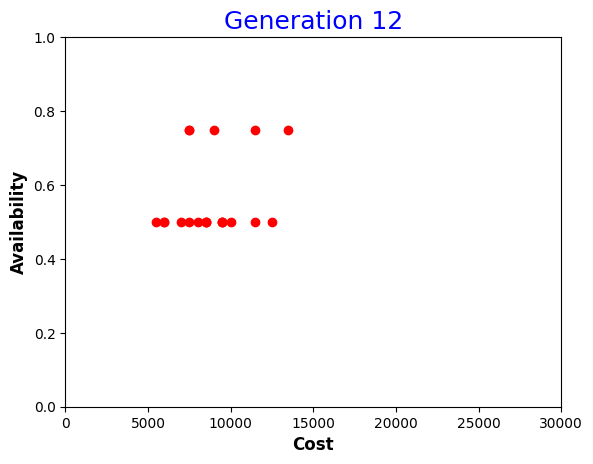

[0, 1, 2]


 >>>> CROSSOVER PHASE (with probability 0.2 )


Parents [0, 2, 4, 0, 1, 1, 4] [3, 2, 2, 1, 2, 2, 3]
Cross from gene: 5

   Child 1 [0, 2, 4, 0, 1, 2, 3]
   Child 2 [3, 2, 2, 1, 2, 1, 4] 

Parents [0, 2, 2, 4, 2, 0, 0] [3, 1, 2, 3, 2, 4, 0]
Cross from gene: 6

   Child 1 [0, 2, 2, 4, 2, 0, 0]
   Child 2 [3, 1, 2, 3, 2, 4, 0] 


Number of Crossover Children: 4 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [0, 4, 2, 1, 3, 3, 1] not mutated
individual [2, 4, 4, 2, 2, 1, 3] not mutated
individual [2, 4, 2, 4, 2, 1, 0] not mutated
individual [3, 4, 3, 0, 3, 3, 1] not mutated
individual [3, 0, 2, 1, 4, 1, 1] not mutated
individual [1, 1, 3, 0, 4, 1, 3] not mutated
individual [4, 1, 2, 1, 2, 0, 0] not mutated
individual [0, 4, 4, 3, 3, 1, 3] not mutated
individual [0, 2, 4, 3, 2, 2, 1] not mutated
individual [0, 4, 2, 2, 3, 1, 3] not mutated
individual [1, 2, 2, 2, 3, 4, 0] not mutated
individual [3, 1, 4, 4, 1, 0, 4] not mutated
individual [3, 2, 4, 0, 1, 1, 4] not

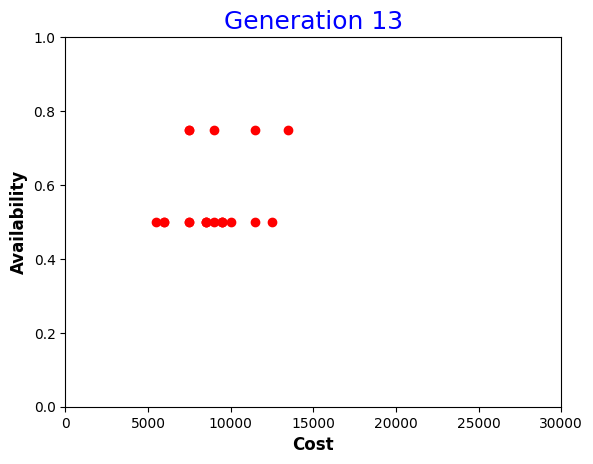

[0, 1, 2]


 >>>> CROSSOVER PHASE (with probability 0.2 )


Parents [3, 1, 2, 3, 2, 4, 0] [1, 2, 2, 2, 3, 4, 0]
Cross from gene: 1

   Child 1 [3, 2, 2, 2, 3, 4, 0]
   Child 2 [1, 1, 2, 3, 2, 4, 0] 

Parents [0, 4, 2, 2, 3, 1, 3] [0, 4, 2, 1, 3, 3, 1]
Cross from gene: 4

   Child 1 [0, 4, 2, 2, 3, 3, 1]
   Child 2 [0, 4, 2, 1, 3, 1, 3] 


Number of Crossover Children: 4 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [0, 2, 4, 0, 1, 2, 3] not mutated
individual [3, 2, 2, 1, 2, 1, 4] not mutated
individual [0, 2, 2, 4, 2, 0, 0] not mutated
individual [2, 4, 4, 2, 2, 1, 3] not mutated
individual [2, 4, 2, 4, 2, 1, 0] not mutated
individual [3, 4, 3, 0, 3, 3, 1] not mutated
individual [3, 0, 2, 1, 4, 1, 1] not mutated
individual [1, 1, 3, 0, 4, 1, 3] not mutated
individual [4, 1, 2, 1, 2, 0, 0] not mutated
individual [0, 4, 4, 3, 3, 1, 3] not mutated
individual [0, 2, 4, 3, 2, 2, 1] not mutated
individual [3, 1, 4, 4, 1, 0, 4] not mutated
individual [3, 2, 4, 0, 1, 1, 4] not

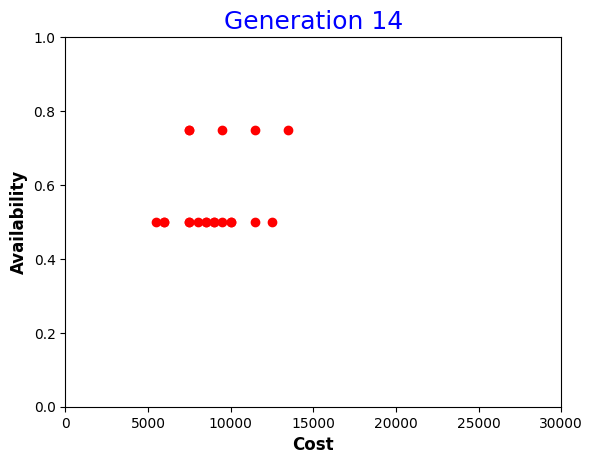

[0, 1, 2]


 >>>> CROSSOVER PHASE (with probability 0.2 )


Parents [3, 0, 2, 1, 4, 1, 1] [3, 1, 4, 4, 1, 0, 4]
Cross from gene: 6

   Child 1 [3, 0, 2, 1, 4, 1, 4]
   Child 2 [3, 1, 4, 4, 1, 0, 1] 

Parents [0, 2, 4, 0, 1, 2, 3] [3, 2, 4, 0, 1, 1, 4]
Cross from gene: 4

   Child 1 [0, 2, 4, 0, 1, 1, 4]
   Child 2 [3, 2, 4, 0, 1, 2, 3] 


Number of Crossover Children: 4 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [3, 2, 2, 2, 3, 4, 0] not mutated
individual [1, 1, 2, 3, 2, 4, 0] not mutated
individual [0, 4, 2, 2, 3, 3, 1] not mutated
individual [0, 4, 2, 1, 3, 1, 3] not mutated
individual [3, 2, 2, 1, 2, 1, 4] not mutated
individual [0, 2, 2, 4, 2, 0, 0] mutate to ----->  [0, 2, 2, 4, 2, 2, 0]
individual [2, 4, 4, 2, 2, 1, 3] not mutated
individual [2, 4, 2, 4, 2, 1, 0] not mutated
individual [3, 4, 3, 0, 3, 3, 1] not mutated
individual [1, 1, 3, 0, 4, 1, 3] not mutated
individual [4, 1, 2, 1, 2, 0, 0] not mutated
individual [0, 4, 4, 3, 3, 1, 3] not mutated
individu

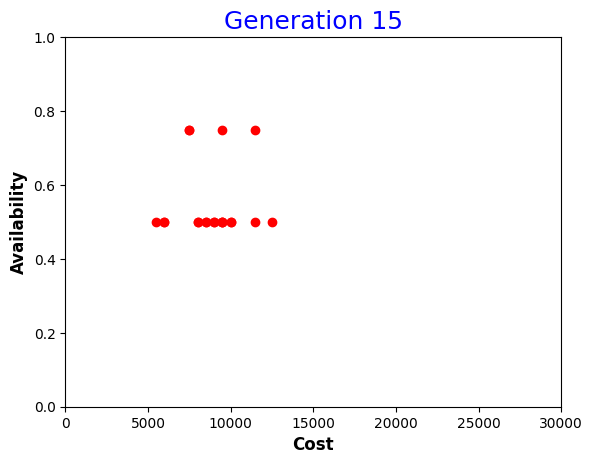

[0, 1, 2]


In [ ]:
pc=0.2
if __name__ == '__main__':
    main()


With pc=0.2

Cost: 7500.0 Availability: 0.75

Cost: 5500.0 Availability: 0.5

From the solutions, it seems that the solutions do not differ that much. The solutions both have one better than the other.

But if we run more generations of the experiment, we will find that the pc=0.2 performs worse. It is because we are not able to explore all the possible solutions as the crossover is less. While for 0.8, this is higher and we can explore much more possible solution space.

-----------------------------------------------------------------------------------------------------------------------

### <font color=blue><b>EXERCISE 4</b></font>.-

#### Analyse what is the influence of the constraints of the problem, i.e., the maximum cost (CostLimit) and the minimum availability (AvLimit) defined as a parameters. What happens if the CostLimit is decreased or the AvLimit is increased?

Lowering the CostLimit restricts the available solutions, potentially leading to fewer feasible paths for meeting demands. This may result in unsatisfied demands if no valid paths remain under the tighter cost constraint.

Raising the AvLimit excludes paths with lower availability, which can improve the overall quality of the selected paths. However, it may also lead to a reduced number of valid paths, making it more challenging to satisfy all demands, especially if the original paths were marginally below the new threshold.

Adjusting one constraint affects the balance between cost and availability. Stricter cost limits may force the selection of less optimal paths in terms of availability, while higher availability limits can drive up costs, impacting overall feasibility and demand satisfaction.

In [32]:
pc = 0.8

# Decreasing cost limit and increasing AvLimit

# Maximum cost of the solution
CostLimit = 13000

# Minimum availability of the solution
AvLimit = 0.7


GENERATION: 1 

Individual: [3, 2, 2, 3, 2, 3, 3] Cost: 11000.0 Availability: 0.75
Individual: [1, 4, 2, 3, 0, 4, 0] Cost: 9500.0 Availability: 0.75
Individual: [2, 3, 2, 1, 3, 1, 4] Cost: 10000.0 Availability: 0.75
Individual: [3, 3, 2, 3, 2, 1, 3] Cost: 10500.0 Availability: 0.75
Individual: [0, 4, 4, 0, 2, 3, 1] Cost: 9500.0 Availability: 0.75
Individual: [3, 4, 3, 2, 1, 3, 1] Cost: 11000.0 Availability: 0.75
Individual: [2, 4, 3, 0, 2, 4, 3] Cost: 12000.0 Availability: 0.75
Individual: [3, 3, 2, 4, 1, 3, 1] Cost: 11000.0 Availability: 0.75
Individual: [2, 4, 3, 2, 2, 3, 3] Cost: 12000.0 Availability: 0.75
Individual: [4, 1, 3, 3, 2, 2, 3] Cost: 11500.0 Availability: 0.75
Individual: [3, 3, 2, 4, 2, 3, 1] Cost: 11500.0 Availability: 0.75
Individual: [4, 0, 2, 4, 4, 0, 4] Cost: 13000.0 Availability: 0.75
Individual: [1, 4, 3, 2, 0, 4, 3] Cost: 11500.0 Availability: 0.75
Individual: [2, 4, 3, 3, 3, 4, 0] Cost: 13000.0 Availability: 0.75
Individual: [0, 4, 4, 3, 2, 3, 0] Cost: 11000.0

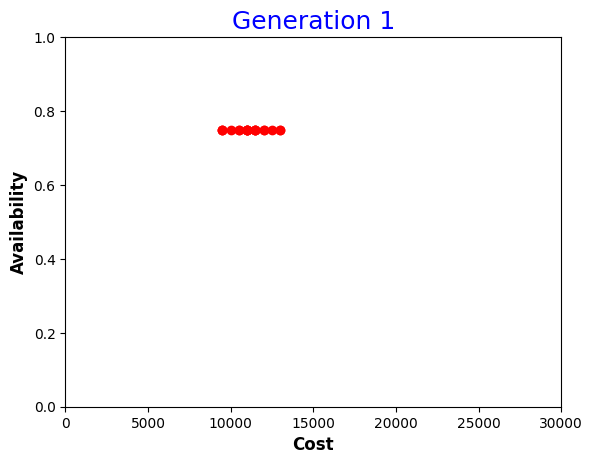



 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [4, 3, 2, 1, 2, 4, 0] [2, 4, 3, 0, 2, 4, 3]
Cross from gene: 1

   Child 1 does not comply with the constraints

   Child 2 [2, 3, 2, 1, 2, 4, 0] 

Parents [3, 3, 2, 4, 2, 3, 1] [2, 3, 4, 2, 4, 1, 3]
Cross from gene: 1

   Child 1 does not comply with the constraints

   Child 2 [2, 3, 2, 4, 2, 3, 1] 

Parents [3, 4, 3, 2, 1, 3, 1] [3, 2, 2, 3, 2, 3, 3]
Cross from gene: 6

   Child 1 [3, 4, 3, 2, 1, 3, 3]

   Child 2 does not comply with the constraints

Parents [3, 3, 2, 3, 2, 1, 3] [2, 4, 3, 0, 2, 4, 3]
Cross from gene: 3

   Child 1 does not comply with the constraints


   Child 2 does not comply with the constraints

Parents [4, 1, 3, 3, 2, 2, 3] [2, 4, 4, 0, 2, 4, 0]
Cross from gene: 2

   Child 1 [4, 1, 4, 0, 2, 4, 0]

   Child 2 does not comply with the constraints

Parents [3, 3, 2, 4, 1, 3, 1] [2, 4, 3, 3, 3, 4, 0]
Cross from gene: 1

   Child 1 does not comply with the constraints

   Child 2 [2, 3, 2, 4, 1, 3, 1] 

P

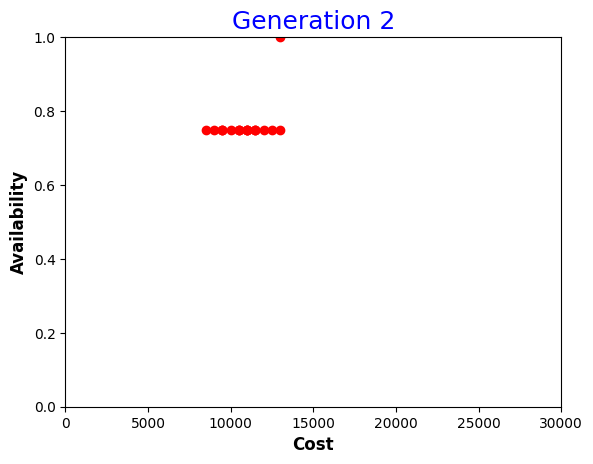

[1, 4, 17]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [2, 3, 2, 4, 1, 3, 1] [4, 0, 2, 4, 4, 0, 4]
Cross from gene: 6

   Child 1 [2, 3, 2, 4, 1, 3, 4]

   Child 2 does not comply with the constraints

Parents [0, 4, 4, 0, 2, 4, 1] [3, 3, 2, 1, 4, 2, 3]
Cross from gene: 2

   Child 1 [0, 4, 2, 1, 4, 2, 3]
   Child 2 [3, 3, 4, 0, 2, 4, 1] 

Parents [0, 4, 4, 3, 2, 3, 0] [1, 4, 3, 2, 0, 4, 3]
Cross from gene: 2

   Child 1 does not comply with the constraints

   Child 2 [1, 4, 4, 3, 2, 3, 0] 

Parents [3, 3, 2, 4, 2, 3, 1] [3, 1, 2, 4, 2, 1, 3]
Cross from gene: 3

   Child 1 [3, 3, 2, 4, 2, 1, 3]

   Child 2 does not comply with the constraints

Parents [3, 4, 3, 2, 1, 3, 3] [4, 1, 4, 0, 2, 4, 0]
Cross from gene: 4

   Child 1 [3, 4, 3, 2, 2, 4, 0]
   Child 2 [4, 1, 4, 0, 1, 3, 3] 

Parents [0, 4, 4, 0, 2, 4, 1] [3, 2, 2, 3, 2, 3, 3]
Cross from gene: 5

   Child 1 [0, 4, 4, 0, 2, 3, 3]

   Child 2 does not comply with the constraints

Parents [2, 3, 2, 1, 3, 1, 3] [2, 3, 2

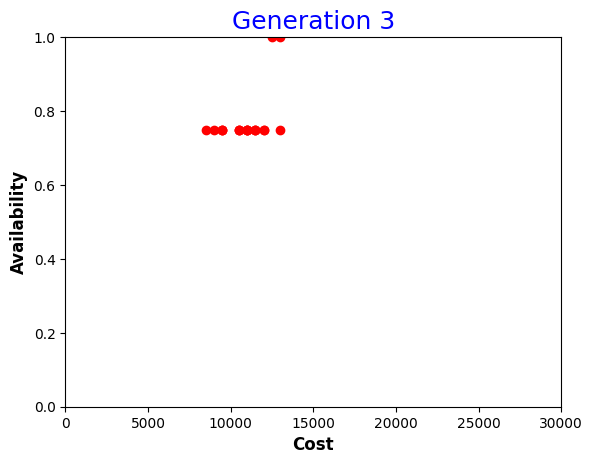

[3, 8]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [2, 3, 2, 1, 3, 3, 1] [3, 3, 2, 4, 1, 3, 1]
Cross from gene: 3

   Child 1 [2, 3, 2, 4, 1, 3, 1]
   Child 2 [3, 3, 2, 1, 3, 3, 1] 

Parents [3, 3, 2, 4, 1, 3, 1] [2, 4, 3, 0, 2, 4, 4]
Cross from gene: 6

   Child 1 does not comply with the constraints

   Child 2 [2, 4, 3, 0, 2, 4, 1] 

Parents [4, 1, 4, 0, 1, 3, 3] [1, 4, 2, 3, 0, 4, 0]
Cross from gene: 6

   Child 1 [4, 1, 4, 0, 1, 3, 0]
   Child 2 [1, 4, 2, 3, 0, 4, 3] 

Parents [3, 3, 2, 4, 2, 1, 3] [4, 1, 2, 3, 2, 0, 3]
Cross from gene: 2

   Child 1 [3, 3, 2, 3, 2, 0, 3]
   Child 2 [4, 1, 2, 4, 2, 1, 3] 

Parents [4, 1, 4, 0, 1, 3, 3] [3, 3, 2, 4, 2, 1, 3]
Cross from gene: 4

   Child 1 does not comply with the constraints

   Child 2 [3, 3, 2, 4, 1, 3, 3] 

Parents [3, 4, 3, 2, 2, 4, 0] [3, 3, 2, 4, 2, 1, 3]
Cross from gene: 2

   Child 1 [3, 4, 2, 4, 2, 1, 3]
   Child 2 [3, 3, 3, 2, 2, 4, 0] 


Number of Crossover Children: 10 



 >>>> MUTATION PHASE (with probab

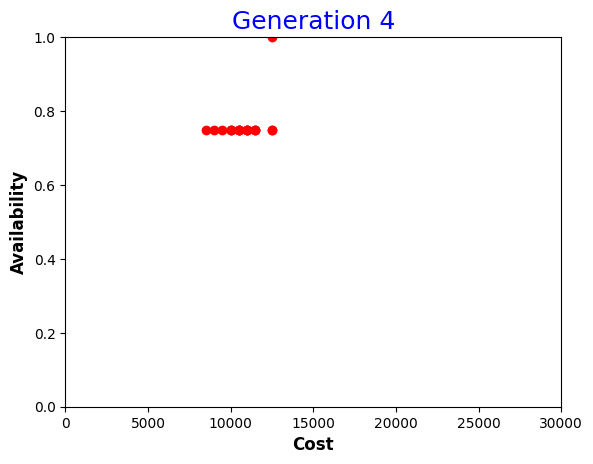

[0, 2]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [4, 1, 2, 4, 2, 1, 3] [1, 4, 4, 3, 2, 3, 0]
Cross from gene: 4

   Child 1 does not comply with the constraints


   Child 2 does not comply with the constraints

Parents [3, 3, 2, 3, 2, 0, 3] [2, 3, 2, 4, 1, 3, 1]
Cross from gene: 2

   Child 1 [3, 3, 2, 4, 1, 3, 1]

   Child 2 does not comply with the constraints

Parents [4, 1, 2, 4, 2, 1, 3] [2, 3, 2, 4, 1, 3, 1]
Cross from gene: 5

   Child 1 does not comply with the constraints


   Child 2 does not comply with the constraints

Parents [3, 3, 2, 4, 1, 3, 3] [3, 3, 2, 1, 3, 3, 1]
Cross from gene: 1

   Child 1 [3, 3, 2, 1, 3, 3, 1]
   Child 2 [3, 3, 2, 4, 1, 3, 3] 

Parents [4, 3, 2, 3, 2, 3, 1] [3, 3, 4, 0, 2, 4, 1]
Cross from gene: 5

   Child 1 [4, 3, 2, 3, 2, 4, 1]
   Child 2 [3, 3, 4, 0, 2, 3, 1] 

Parents [3, 3, 2, 1, 3, 3, 1] [3, 3, 3, 2, 2, 4, 0]
Cross from gene: 5

   Child 1 [3, 3, 2, 1, 3, 4, 0]
   Child 2 [3, 3, 3, 2, 2, 3, 1] 

Parents [3, 3, 4, 0, 2, 4,

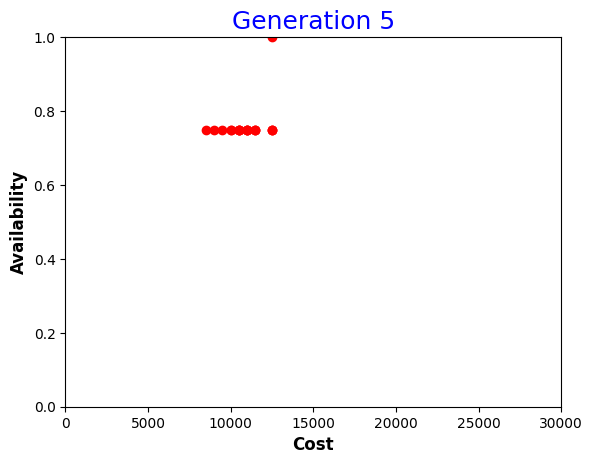

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 4, 4, 3, 2, 3, 0] [4, 1, 2, 4, 2, 1, 3]
Cross from gene: 1

   Child 1 does not comply with the constraints


   Child 2 does not comply with the constraints

Parents [0, 4, 4, 1, 2, 3, 1] [0, 4, 2, 1, 4, 2, 3]
Cross from gene: 3

   Child 1 [0, 4, 4, 1, 4, 2, 3]
   Child 2 [0, 4, 2, 1, 2, 3, 1] 

Parents [3, 3, 3, 2, 2, 3, 1] [0, 4, 2, 1, 4, 2, 3]
Cross from gene: 3

   Child 1 [3, 3, 3, 1, 4, 2, 3]
   Child 2 [0, 4, 2, 2, 2, 3, 1] 

Parents [4, 3, 2, 3, 2, 4, 1] [1, 4, 2, 3, 2, 4, 1]
Cross from gene: 1

   Child 1 does not comply with the constraints

   Child 2 [1, 3, 2, 3, 2, 4, 1] 

Parents [3, 3, 4, 0, 2, 3, 1] [4, 1, 4, 0, 1, 3, 0]
Cross from gene: 2

   Child 1 [3, 3, 4, 0, 1, 3, 0]
   Child 2 [4, 1, 4, 0, 2, 3, 1] 

Parents [1, 4, 4, 3, 2, 3, 0] [4, 3, 2, 3, 2, 4, 1]
Cross from gene: 2

   Child 1 [1, 4, 2, 3, 2, 4, 1]
   Child 2 [4, 3, 4, 3, 2, 3, 0] 

Parents [2, 3, 2, 4, 1, 3, 3] [3, 3, 2, 4, 1, 3, 3]
Cros

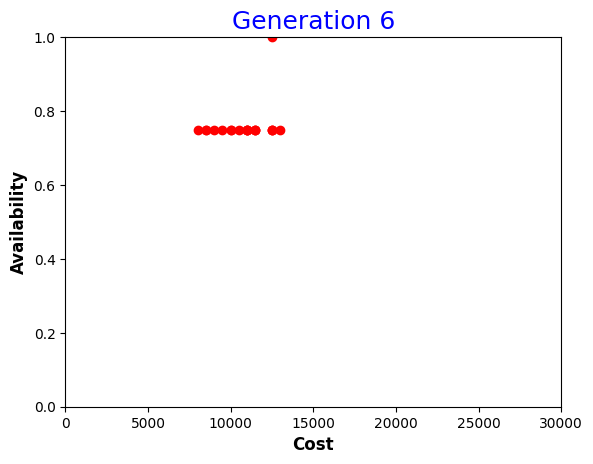

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [3, 3, 4, 0, 1, 3, 0] [2, 3, 2, 4, 1, 3, 3]
Cross from gene: 3

   Child 1 does not comply with the constraints


   Child 2 does not comply with the constraints

Parents [4, 1, 4, 0, 2, 3, 1] [0, 4, 4, 1, 4, 2, 3]
Cross from gene: 2

   Child 1 [4, 1, 4, 1, 4, 2, 3]
   Child 2 [0, 4, 4, 0, 2, 3, 1] 

Parents [3, 4, 3, 0, 2, 4, 1] [3, 3, 4, 1, 2, 3, 1]
Cross from gene: 1

   Child 1 [3, 3, 4, 1, 2, 3, 1]
   Child 2 [3, 4, 3, 0, 2, 4, 1] 

Parents [3, 3, 2, 4, 1, 3, 3] [2, 3, 2, 1, 2, 4, 0]
Cross from gene: 1

   Child 1 [3, 3, 2, 1, 2, 4, 0]
   Child 2 [2, 3, 2, 4, 1, 3, 3] 

Parents [2, 3, 2, 4, 1, 3, 3] [3, 3, 4, 1, 2, 3, 1]
Cross from gene: 1

   Child 1 [2, 3, 4, 1, 2, 3, 1]
   Child 2 [3, 3, 2, 4, 1, 3, 3] 

Parents [3, 3, 2, 4, 1, 3, 1] [2, 3, 2, 4, 1, 3, 3]
Cross from gene: 6

   Child 1 [3, 3, 2, 4, 1, 3, 3]
   Child 2 [2, 3, 2, 4, 1, 3, 1] 

Parents [2, 3, 2, 1, 2, 4, 0] [3, 3, 4, 1, 2, 3, 1]
Cross from gene: 4



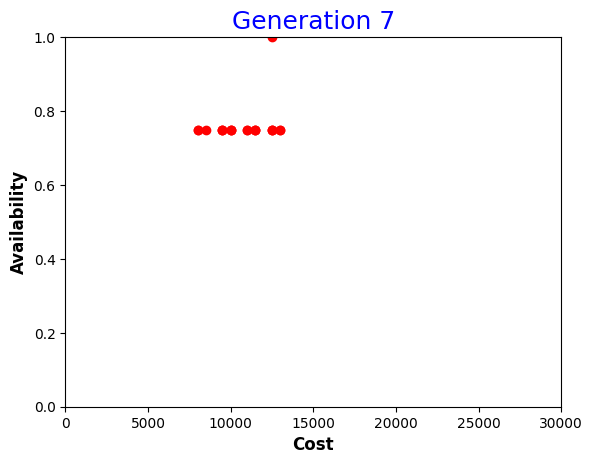

[1, 3]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [4, 3, 4, 3, 2, 3, 0] [3, 3, 4, 0, 1, 3, 0]
Cross from gene: 1

   Child 1 [4, 3, 4, 0, 1, 3, 0]
   Child 2 [3, 3, 4, 3, 2, 3, 0] 

Parents [2, 3, 2, 4, 1, 3, 3] [3, 3, 4, 1, 2, 4, 0]
Cross from gene: 6

   Child 1 [2, 3, 2, 4, 1, 3, 0]

   Child 2 does not comply with the constraints

Parents [3, 3, 4, 0, 1, 3, 0] [1, 4, 2, 3, 2, 4, 1]
Cross from gene: 4

   Child 1 [3, 3, 4, 0, 2, 4, 1]
   Child 2 [1, 4, 2, 3, 1, 3, 0] 

Parents [3, 3, 4, 1, 2, 4, 0] [3, 4, 3, 0, 2, 4, 1]
Cross from gene: 4

   Child 1 [3, 3, 4, 1, 2, 4, 1]
   Child 2 [3, 4, 3, 0, 2, 4, 0] 

Parents [3, 3, 2, 1, 2, 4, 0] [0, 4, 2, 2, 2, 3, 1]
Cross from gene: 2

   Child 1 [3, 3, 2, 2, 2, 3, 1]
   Child 2 [0, 4, 2, 1, 2, 4, 0] 

Parents [3, 4, 3, 0, 2, 4, 1] [1, 3, 2, 3, 2, 4, 1]
Cross from gene: 1

   Child 1 [3, 3, 2, 3, 2, 4, 1]
   Child 2 [1, 4, 3, 0, 2, 4, 1] 

Parents [3, 3, 2, 4, 1, 3, 3] [2, 3, 2, 4, 1, 3, 1]
Cross from gene: 3

   Child 1 [3, 3

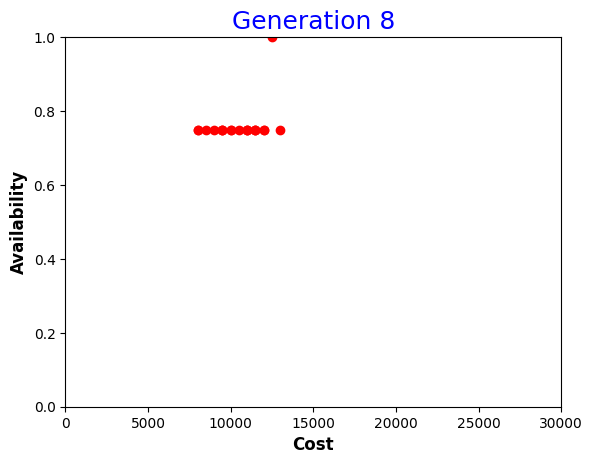

[0, 1, 12]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [2, 3, 4, 1, 2, 3, 1] [4, 1, 4, 1, 4, 2, 3]
Cross from gene: 2

   Child 1 [2, 3, 4, 1, 4, 2, 3]
   Child 2 [4, 1, 4, 1, 2, 3, 1] 

Parents [3, 3, 4, 1, 2, 3, 1] [2, 3, 2, 4, 1, 3, 0]
Cross from gene: 3

   Child 1 [3, 3, 4, 4, 1, 3, 0]
   Child 2 [2, 3, 2, 1, 2, 3, 1] 

Parents [2, 3, 4, 1, 2, 3, 1] [3, 3, 2, 4, 1, 3, 1]
Cross from gene: 2

   Child 1 [2, 3, 2, 4, 1, 3, 1]
   Child 2 [3, 3, 4, 1, 2, 3, 1] 

Parents [3, 3, 2, 4, 1, 3, 1] [1, 4, 2, 3, 1, 3, 0]
Cross from gene: 2

   Child 1 [3, 3, 2, 3, 1, 3, 0]
   Child 2 [1, 4, 2, 4, 1, 3, 1] 

Parents [3, 3, 4, 3, 2, 3, 0] [3, 3, 4, 1, 2, 4, 1]
Cross from gene: 5

   Child 1 does not comply with the constraints

   Child 2 [3, 3, 4, 1, 2, 3, 0] 

Parents [1, 4, 2, 3, 1, 3, 0] [3, 3, 2, 3, 2, 4, 1]
Cross from gene: 2

   Child 1 [1, 4, 2, 3, 2, 4, 1]
   Child 2 [3, 3, 2, 3, 1, 3, 0] 

Parents [3, 4, 3, 0, 2, 4, 0] [0, 4, 2, 1, 2, 4, 0]
Cross from gene: 5

   Child 1 

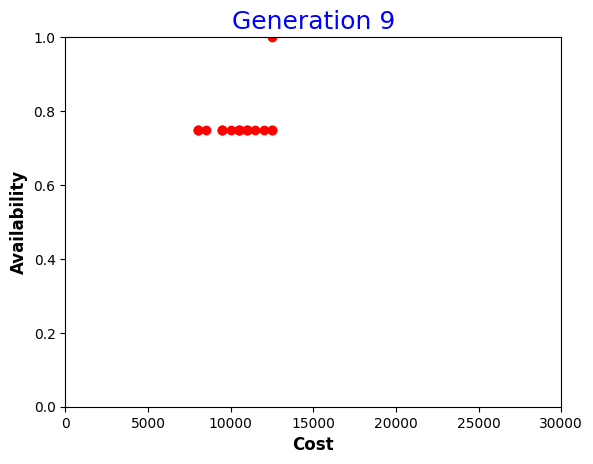

[0, 1, 2]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 4, 2, 3, 2, 4, 1] [2, 3, 4, 1, 4, 2, 3]
Cross from gene: 2

   Child 1 [1, 4, 4, 1, 4, 2, 3]
   Child 2 [2, 3, 2, 3, 2, 4, 1] 

Parents [3, 3, 4, 3, 2, 3, 0] [3, 3, 4, 1, 2, 3, 0]
Cross from gene: 5

   Child 1 [3, 3, 4, 3, 2, 3, 0]
   Child 2 [3, 3, 4, 1, 2, 3, 0] 

Parents [3, 3, 4, 1, 2, 3, 0] [3, 3, 4, 3, 2, 3, 0]
Cross from gene: 1

   Child 1 [3, 3, 4, 3, 2, 3, 0]
   Child 2 [3, 3, 4, 1, 2, 3, 0] 

Parents [2, 3, 2, 4, 1, 3, 1] [1, 3, 4, 4, 2, 4, 1]
Cross from gene: 4

   Child 1 [2, 3, 2, 4, 2, 4, 1]
   Child 2 [1, 3, 4, 4, 1, 3, 1] 

Parents [4, 3, 4, 0, 1, 3, 0] [3, 3, 4, 3, 2, 3, 0]
Cross from gene: 4

   Child 1 [4, 3, 4, 0, 2, 3, 0]
   Child 2 [3, 3, 4, 3, 1, 3, 0] 

Parents [3, 3, 4, 4, 1, 3, 0] [1, 3, 4, 4, 2, 4, 1]
Cross from gene: 5

   Child 1 does not comply with the constraints

   Child 2 [1, 3, 4, 4, 2, 3, 0] 


Number of Crossover Children: 11 



 >>>> MUTATION PHASE (with probability 0.1 )



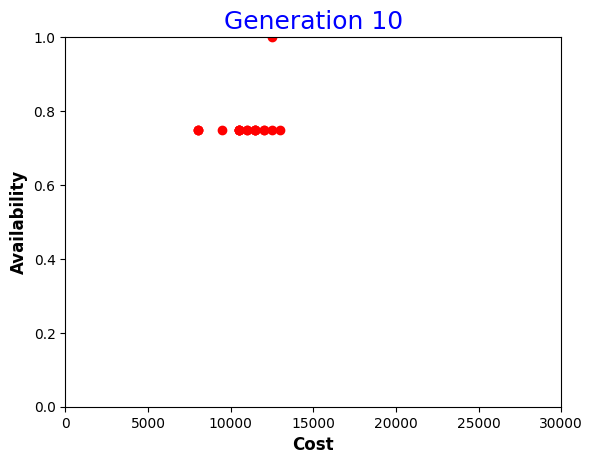

[0, 1, 2, 6]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [3, 3, 4, 3, 2, 3, 0] [3, 3, 4, 3, 2, 3, 0]
Cross from gene: 1

   Child 1 [3, 3, 4, 3, 2, 3, 0]
   Child 2 [3, 3, 4, 3, 2, 3, 0] 

Parents [1, 3, 4, 4, 2, 3, 0] [3, 3, 4, 1, 2, 3, 0]
Cross from gene: 2

   Child 1 [1, 3, 4, 1, 2, 3, 0]
   Child 2 [3, 3, 4, 4, 2, 3, 0] 

Parents [3, 3, 2, 3, 1, 3, 0] [3, 3, 4, 1, 2, 3, 0]
Cross from gene: 2

   Child 1 [3, 3, 4, 1, 2, 3, 0]
   Child 2 [3, 3, 2, 3, 1, 3, 0] 

Parents [3, 3, 4, 4, 1, 3, 0] [2, 3, 2, 3, 2, 4, 1]
Cross from gene: 3

   Child 1 does not comply with the constraints

   Child 2 [2, 3, 2, 4, 1, 3, 0] 

Parents [3, 3, 4, 3, 1, 3, 0] [3, 3, 4, 1, 2, 3, 0]
Cross from gene: 6

   Child 1 [3, 3, 4, 3, 1, 3, 0]
   Child 2 [3, 3, 4, 1, 2, 3, 0] 

Parents [2, 3, 2, 3, 2, 4, 1] [3, 3, 4, 1, 2, 3, 1]
Cross from gene: 6

   Child 1 [2, 3, 2, 3, 2, 4, 1]
   Child 2 [3, 3, 4, 1, 2, 3, 1] 

Parents [1, 3, 4, 4, 1, 3, 1] [2, 3, 2, 4, 2, 4, 1]
Cross from gene: 5

   Child 

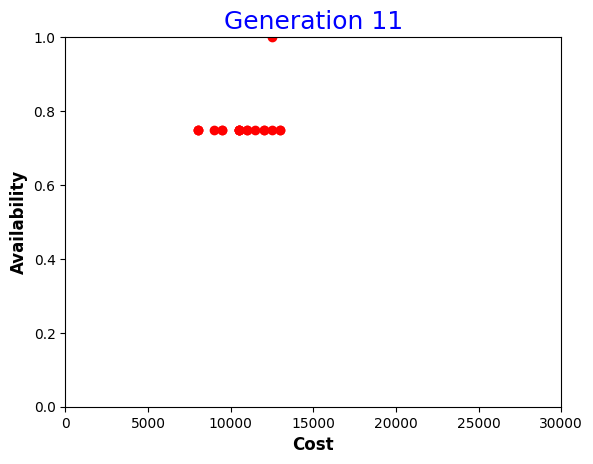

[0, 1, 2, 3]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 3, 4, 1, 2, 3, 0] [3, 3, 4, 3, 1, 3, 0]
Cross from gene: 3

   Child 1 [1, 3, 4, 3, 1, 3, 0]
   Child 2 [3, 3, 4, 1, 2, 3, 0] 

Parents [3, 3, 4, 1, 2, 3, 1] [3, 3, 4, 3, 2, 3, 0]
Cross from gene: 6

   Child 1 [3, 3, 4, 1, 2, 3, 0]
   Child 2 [3, 3, 4, 3, 2, 3, 1] 

Parents [3, 3, 4, 3, 2, 3, 0] [3, 3, 4, 1, 2, 3, 0]
Cross from gene: 6

   Child 1 [3, 3, 4, 3, 2, 3, 0]
   Child 2 [3, 3, 4, 1, 2, 3, 0] 

Parents [3, 3, 4, 1, 2, 3, 0] [4, 3, 4, 0, 2, 3, 0]
Cross from gene: 1

   Child 1 [3, 3, 4, 0, 2, 3, 0]
   Child 2 [4, 3, 4, 1, 2, 3, 0] 

Parents [4, 3, 4, 0, 2, 3, 0] [3, 3, 4, 1, 2, 3, 1]
Cross from gene: 3

   Child 1 [4, 3, 4, 1, 2, 3, 1]
   Child 2 [3, 3, 4, 0, 2, 3, 0] 

Parents [3, 3, 4, 3, 2, 3, 0] [3, 3, 4, 4, 2, 3, 0]
Cross from gene: 4

   Child 1 [3, 3, 4, 3, 2, 3, 0]
   Child 2 [3, 3, 4, 4, 2, 3, 0] 

Parents [3, 3, 4, 4, 2, 3, 0] [3, 3, 4, 1, 2, 3, 0]
Cross from gene: 1

   Child 1 [3, 3, 4, 1, 2

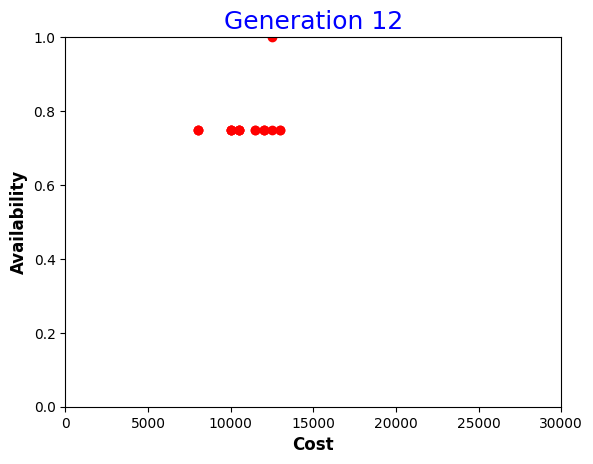

[0, 1, 2, 3]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [3, 3, 2, 3, 2, 4, 1] [3, 3, 4, 1, 2, 3, 0]
Cross from gene: 3

   Child 1 [3, 3, 2, 1, 2, 3, 0]

   Child 2 does not comply with the constraints

Parents [3, 3, 4, 0, 2, 3, 0] [3, 3, 4, 1, 2, 3, 0]
Cross from gene: 3

   Child 1 [3, 3, 4, 1, 2, 3, 0]
   Child 2 [3, 3, 4, 0, 2, 3, 0] 

Parents [4, 3, 4, 1, 2, 3, 0] [3, 3, 4, 1, 2, 3, 0]
Cross from gene: 4

   Child 1 [4, 3, 4, 1, 2, 3, 0]
   Child 2 [3, 3, 4, 1, 2, 3, 0] 

Parents [3, 3, 4, 3, 2, 3, 0] [3, 3, 4, 1, 2, 3, 0]
Cross from gene: 5

   Child 1 [3, 3, 4, 3, 2, 3, 0]
   Child 2 [3, 3, 4, 1, 2, 3, 0] 

Parents [3, 3, 4, 3, 2, 3, 1] [3, 3, 4, 1, 2, 3, 0]
Cross from gene: 4

   Child 1 [3, 3, 4, 3, 2, 3, 0]
   Child 2 [3, 3, 4, 1, 2, 3, 1] 

Parents [3, 3, 4, 4, 2, 3, 0] [3, 3, 4, 1, 2, 3, 0]
Cross from gene: 3

   Child 1 [3, 3, 4, 1, 2, 3, 0]
   Child 2 [3, 3, 4, 4, 2, 3, 0] 

Parents [4, 3, 4, 1, 2, 3, 1] [3, 3, 4, 3, 2, 3, 0]
Cross from gene: 2

   Child 1

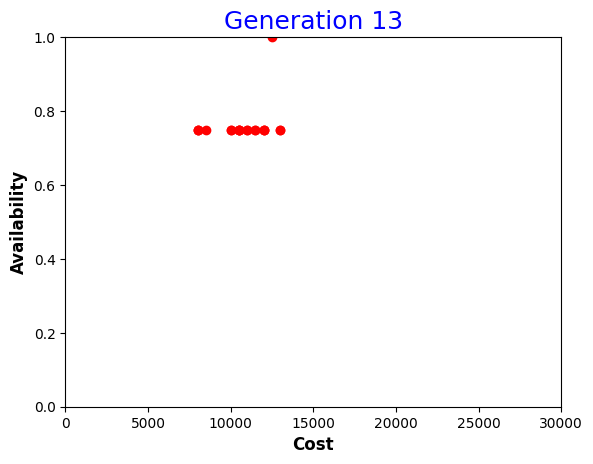

[0, 1, 2, 3]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [3, 3, 4, 1, 2, 3, 0] [4, 3, 4, 1, 2, 3, 0]
Cross from gene: 3

   Child 1 [3, 3, 4, 1, 2, 3, 0]
   Child 2 [4, 3, 4, 1, 2, 3, 0] 

Parents [3, 3, 4, 1, 2, 3, 0] [3, 3, 4, 1, 2, 3, 1]
Cross from gene: 2

   Child 1 [3, 3, 4, 1, 2, 3, 1]
   Child 2 [3, 3, 4, 1, 2, 3, 0] 

Parents [4, 3, 4, 1, 2, 3, 1] [3, 3, 4, 1, 2, 3, 1]
Cross from gene: 5

   Child 1 [4, 3, 4, 1, 2, 3, 1]
   Child 2 [3, 3, 4, 1, 2, 3, 1] 

Parents [3, 3, 4, 0, 2, 3, 0] [3, 3, 4, 1, 2, 3, 1]
Cross from gene: 5

   Child 1 [3, 3, 4, 0, 2, 3, 1]
   Child 2 [3, 3, 4, 1, 2, 3, 0] 

Parents [3, 3, 4, 1, 2, 3, 1] [3, 3, 2, 3, 2, 4, 1]
Cross from gene: 5

   Child 1 [3, 3, 4, 1, 2, 4, 1]
   Child 2 [3, 3, 2, 3, 2, 3, 1] 

Parents [4, 3, 4, 3, 2, 3, 0] [3, 3, 4, 3, 2, 3, 0]
Cross from gene: 1

   Child 1 [4, 3, 4, 3, 2, 3, 0]
   Child 2 [3, 3, 4, 3, 2, 3, 0] 

Parents [3, 3, 4, 1, 2, 3, 0] [4, 3, 4, 1, 2, 3, 0]
Cross from gene: 3

   Child 1 [3, 3, 4, 1, 2

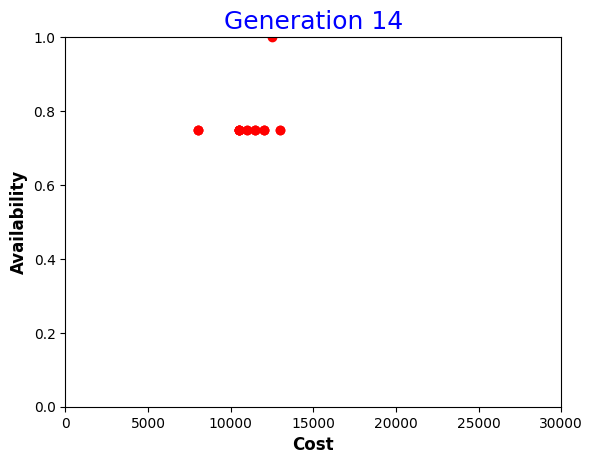

[0, 1, 2, 3]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [3, 3, 4, 1, 2, 3, 0] [3, 3, 4, 1, 2, 3, 0]
Cross from gene: 1

   Child 1 [3, 3, 4, 1, 2, 3, 0]
   Child 2 [3, 3, 4, 1, 2, 3, 0] 

Parents [3, 3, 4, 1, 2, 3, 0] [4, 3, 4, 1, 2, 3, 1]
Cross from gene: 5

   Child 1 [3, 3, 4, 1, 2, 3, 1]
   Child 2 [4, 3, 4, 1, 2, 3, 0] 

Parents [3, 3, 4, 1, 2, 3, 1] [4, 3, 4, 1, 2, 3, 1]
Cross from gene: 4

   Child 1 [3, 3, 4, 1, 2, 3, 1]
   Child 2 [4, 3, 4, 1, 2, 3, 1] 

Parents [3, 3, 4, 0, 2, 3, 1] [4, 3, 4, 1, 2, 3, 0]
Cross from gene: 1

   Child 1 [3, 3, 4, 1, 2, 3, 0]
   Child 2 [4, 3, 4, 0, 2, 3, 1] 

Parents [3, 3, 4, 1, 2, 3, 0] [3, 3, 4, 4, 2, 3, 0]
Cross from gene: 2

   Child 1 [3, 3, 4, 4, 2, 3, 0]
   Child 2 [3, 3, 4, 1, 2, 3, 0] 

Parents [3, 3, 2, 3, 2, 4, 1] [3, 3, 4, 1, 2, 3, 0]
Cross from gene: 1

   Child 1 [3, 3, 4, 1, 2, 3, 0]
   Child 2 [3, 3, 2, 3, 2, 4, 1] 

Parents [3, 3, 2, 3, 2, 4, 1] [3, 3, 4, 1, 2, 4, 1]
Cross from gene: 5

   Child 1 [3, 3, 2, 3, 2

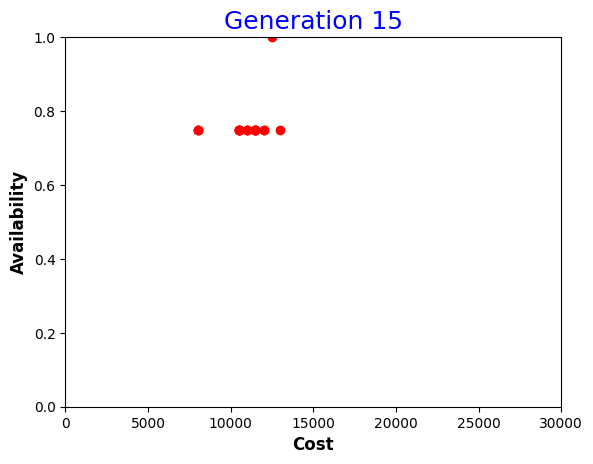

[0, 1, 2, 3]


In [33]:
if __name__ == '__main__':
    main()


In [36]:
# Maximum cost of the solution
CostLimit = 15000

# Minimum availability of the solution
AvLimit = 0.8


GENERATION: 1 

Individual: [3, 3, 3, 2, 3, 4, 4] Cost: 15000.0 Availability: 1
Individual: [3, 1, 4, 0, 4, 3, 4] Cost: 13500.0 Availability: 1
Individual: [1, 3, 2, 2, 0, 3, 4] Cost: 9500.0 Availability: 1
Individual: [1, 4, 2, 3, 1, 4, 4] Cost: 13000.0 Availability: 1
Individual: [3, 4, 2, 0, 1, 3, 4] Cost: 11500.0 Availability: 1
Individual: [2, 3, 2, 2, 2, 4, 4] Cost: 12000.0 Availability: 1
Individual: [2, 4, 3, 1, 3, 3, 4] Cost: 13500.0 Availability: 1
Individual: [4, 4, 3, 2, 0, 3, 4] Cost: 14000.0 Availability: 1
Individual: [3, 3, 3, 1, 4, 3, 4] Cost: 14500.0 Availability: 1
Individual: [3, 4, 2, 0, 2, 4, 4] Cost: 13000.0 Availability: 1
Individual: [4, 3, 4, 0, 2, 4, 4] Cost: 15000.0 Availability: 1
Individual: [1, 3, 3, 2, 1, 4, 4] Cost: 12000.0 Availability: 1
Individual: [1, 3, 2, 3, 3, 4, 4] Cost: 13500.0 Availability: 1
Individual: [4, 3, 3, 2, 2, 4, 4] Cost: 15000.0 Availability: 1
Individual: [1, 4, 2, 0, 1, 3, 4] Cost: 10000.0 Availability: 1
Individual: [1, 3, 3, 3,

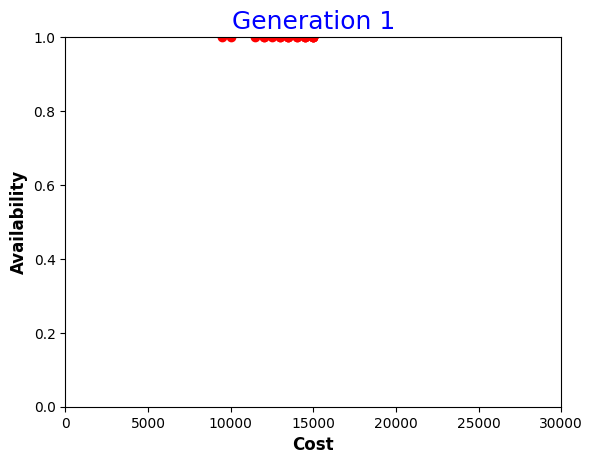



 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 3, 3, 2, 1, 4, 4] [4, 3, 3, 2, 2, 4, 4]
Cross from gene: 2

   Child 1 [1, 3, 3, 2, 2, 4, 4]
   Child 2 [4, 3, 3, 2, 1, 4, 4] 

Parents [2, 4, 2, 1, 4, 4, 4] [4, 3, 3, 2, 2, 4, 4]
Cross from gene: 1

   Child 1 [2, 3, 3, 2, 2, 4, 4]

   Child 2 does not comply with the constraints

Parents [3, 3, 3, 1, 4, 3, 4] [1, 3, 3, 3, 2, 3, 4]
Cross from gene: 1

   Child 1 [3, 3, 3, 3, 2, 3, 4]
   Child 2 [1, 3, 3, 1, 4, 3, 4] 

Parents [1, 3, 2, 3, 3, 4, 4] [4, 3, 3, 2, 2, 4, 4]
Cross from gene: 3

   Child 1 [1, 3, 2, 2, 2, 4, 4]

   Child 2 does not comply with the constraints

Parents [4, 3, 3, 2, 2, 4, 4] [2, 3, 2, 2, 2, 4, 4]
Cross from gene: 5

   Child 1 [4, 3, 3, 2, 2, 4, 4]
   Child 2 [2, 3, 2, 2, 2, 4, 4] 

Parents [3, 4, 2, 0, 2, 4, 4] [2, 4, 3, 1, 3, 3, 4]
Cross from gene: 5

   Child 1 [3, 4, 2, 0, 2, 3, 4]
   Child 2 [2, 4, 3, 1, 3, 4, 4] 

Parents [4, 4, 3, 2, 0, 3, 4] [1, 3, 2, 3, 3, 4, 4]
Cross from gene: 1

   Child

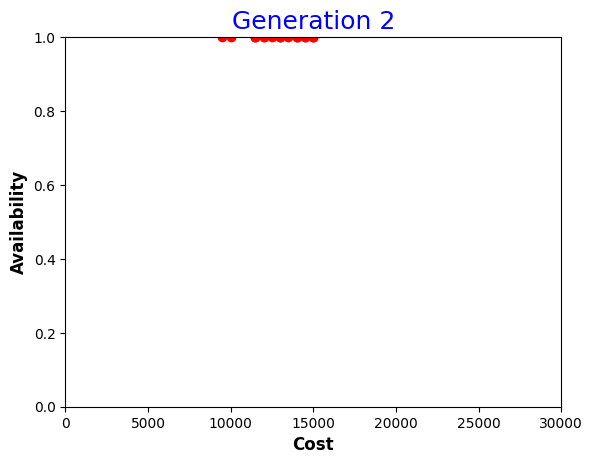

[2]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 3, 3, 2, 2, 4, 4] [1, 4, 2, 0, 1, 3, 4]
Cross from gene: 4

   Child 1 [1, 3, 3, 2, 1, 3, 4]
   Child 2 [1, 4, 2, 0, 2, 4, 4] 

Parents [1, 3, 3, 1, 4, 3, 4] [1, 4, 3, 2, 0, 3, 4]
Cross from gene: 5

   Child 1 [1, 3, 3, 1, 4, 3, 4]
   Child 2 [1, 4, 3, 2, 0, 3, 4] 

Parents [2, 4, 3, 1, 3, 4, 4] [1, 3, 3, 1, 4, 3, 4]
Cross from gene: 3

   Child 1 [2, 4, 3, 1, 4, 3, 4]
   Child 2 [1, 3, 3, 1, 3, 4, 4] 

Parents [3, 4, 3, 0, 3, 3, 4] [3, 3, 3, 2, 3, 4, 4]
Cross from gene: 2

   Child 1 does not comply with the constraints

   Child 2 [3, 3, 3, 0, 3, 3, 4] 

Parents [3, 3, 3, 3, 2, 3, 4] [4, 1, 4, 0, 4, 3, 4]
Cross from gene: 2

   Child 1 [3, 3, 4, 0, 4, 3, 4]

   Child 2 does not comply with the constraints

Parents [3, 3, 3, 2, 3, 4, 4] [1, 3, 3, 2, 2, 4, 4]
Cross from gene: 1

   Child 1 [3, 3, 3, 2, 2, 4, 4]
   Child 2 [1, 3, 3, 2, 3, 4, 4] 

Parents [1, 4, 2, 0, 1, 3, 4] [1, 3, 2, 2, 2, 4, 4]
Cross from gene: 5

   

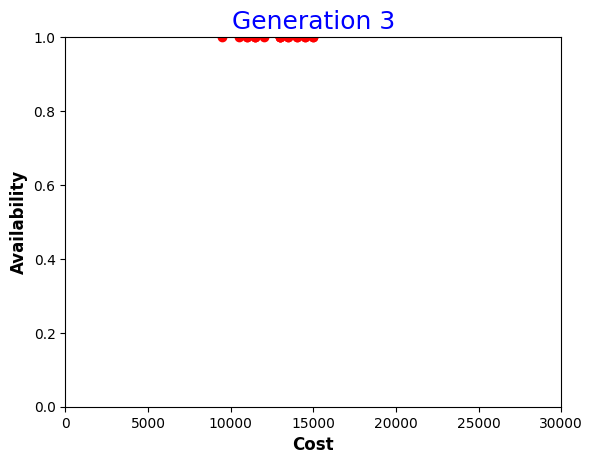

[0]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [2, 4, 3, 1, 4, 3, 4] [4, 1, 4, 0, 2, 4, 4]
Cross from gene: 3

   Child 1 [2, 4, 3, 0, 2, 4, 4]
   Child 2 [4, 1, 4, 1, 4, 3, 4] 

Parents [1, 3, 3, 2, 3, 4, 4] [1, 4, 3, 2, 0, 3, 4]
Cross from gene: 4

   Child 1 [1, 3, 3, 2, 0, 3, 4]
   Child 2 [1, 4, 3, 2, 3, 4, 4] 

Parents [3, 3, 3, 2, 2, 4, 4] [4, 3, 3, 2, 2, 4, 4]
Cross from gene: 6

   Child 1 [3, 3, 3, 2, 2, 4, 4]
   Child 2 [4, 3, 3, 2, 2, 4, 4] 

Parents [1, 3, 3, 1, 3, 4, 4] [1, 3, 3, 1, 4, 3, 4]
Cross from gene: 3

   Child 1 [1, 3, 3, 1, 4, 3, 4]
   Child 2 [1, 3, 3, 1, 3, 4, 4] 

Parents [1, 3, 3, 1, 3, 4, 4] [1, 3, 3, 1, 4, 3, 4]
Cross from gene: 2

   Child 1 [1, 3, 3, 1, 4, 3, 4]
   Child 2 [1, 3, 3, 1, 3, 4, 4] 

Parents [1, 3, 3, 1, 3, 4, 4] [4, 3, 3, 2, 2, 4, 4]
Cross from gene: 4

   Child 1 [1, 3, 3, 1, 2, 4, 4]

   Child 2 does not comply with the constraints

Parents [4, 1, 4, 0, 2, 4, 4] [1, 3, 3, 2, 3, 4, 4]
Cross from gene: 2

   Child 1 does not

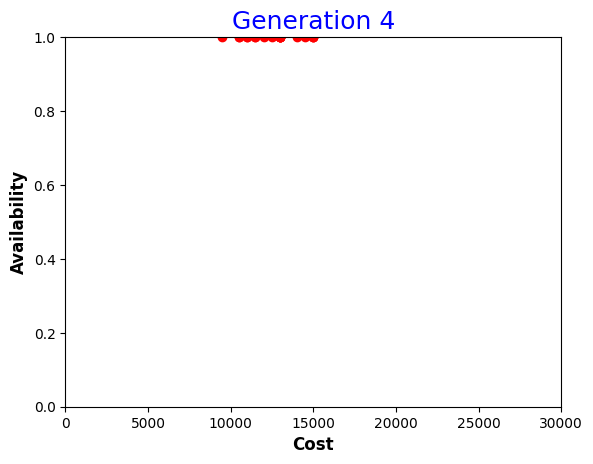

[0]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 3, 3, 1, 3, 4, 4] [1, 3, 2, 4, 2, 3, 4]
Cross from gene: 3

   Child 1 [1, 3, 3, 4, 2, 3, 4]
   Child 2 [1, 3, 2, 1, 3, 4, 4] 

Parents [1, 4, 2, 0, 2, 4, 4] [1, 3, 3, 2, 1, 3, 4]
Cross from gene: 2

   Child 1 [1, 4, 3, 2, 1, 3, 4]

   Child 2 does not comply with the constraints

Parents [3, 3, 4, 0, 4, 3, 4] [1, 3, 3, 1, 3, 4, 4]
Cross from gene: 2

   Child 1 [3, 3, 3, 1, 3, 4, 4]
   Child 2 [1, 3, 4, 0, 4, 3, 4] 

Parents [1, 4, 2, 0, 1, 4, 4] [1, 3, 2, 2, 3, 3, 4]
Cross from gene: 5

   Child 1 [1, 4, 2, 0, 1, 3, 4]
   Child 2 [1, 3, 2, 2, 3, 4, 4] 

Parents [1, 3, 3, 1, 4, 3, 4] [4, 1, 4, 1, 4, 3, 4]
Cross from gene: 3

   Child 1 [1, 3, 3, 1, 4, 3, 4]
   Child 2 [4, 1, 4, 1, 4, 3, 4] 

Parents [2, 4, 3, 0, 2, 4, 4] [1, 3, 3, 1, 2, 4, 4]
Cross from gene: 1

   Child 1 [2, 3, 3, 1, 2, 4, 4]
   Child 2 [1, 4, 3, 0, 2, 4, 4] 

Parents [1, 3, 3, 1, 3, 4, 4] [1, 4, 3, 2, 3, 4, 4]
Cross from gene: 6

   Child 1 [1, 3, 3

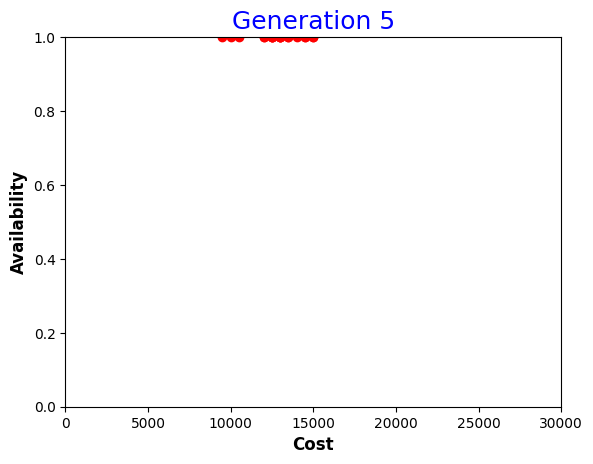

[0]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 4, 3, 0, 2, 4, 4] [1, 3, 3, 1, 3, 4, 4]
Cross from gene: 5

   Child 1 [1, 4, 3, 0, 2, 4, 4]
   Child 2 [1, 3, 3, 1, 3, 4, 4] 

Parents [1, 3, 3, 1, 3, 4, 4] [3, 3, 3, 2, 2, 4, 4]
Cross from gene: 2

   Child 1 [1, 3, 3, 2, 2, 4, 4]
   Child 2 [3, 3, 3, 1, 3, 4, 4] 

Parents [1, 4, 3, 2, 1, 3, 4] [1, 4, 3, 2, 3, 4, 4]
Cross from gene: 4

   Child 1 [1, 4, 3, 2, 3, 4, 4]
   Child 2 [1, 4, 3, 2, 1, 3, 4] 

Parents [1, 3, 2, 1, 3, 4, 4] [1, 4, 2, 0, 1, 3, 4]
Cross from gene: 3

   Child 1 does not comply with the constraints

   Child 2 [1, 4, 2, 1, 3, 4, 4] 

Parents [1, 3, 2, 2, 3, 4, 4] [1, 3, 3, 1, 3, 4, 4]
Cross from gene: 1

   Child 1 [1, 3, 3, 1, 3, 4, 4]
   Child 2 [1, 3, 2, 2, 3, 4, 4] 

Parents [1, 3, 4, 0, 4, 3, 4] [1, 4, 3, 2, 3, 4, 4]
Cross from gene: 3

   Child 1 [1, 3, 4, 2, 3, 4, 4]
   Child 2 [1, 4, 3, 0, 4, 3, 4] 

Parents [1, 3, 3, 4, 2, 3, 4] [2, 4, 3, 0, 2, 4, 4]
Cross from gene: 3

   Child 1 [1, 3, 

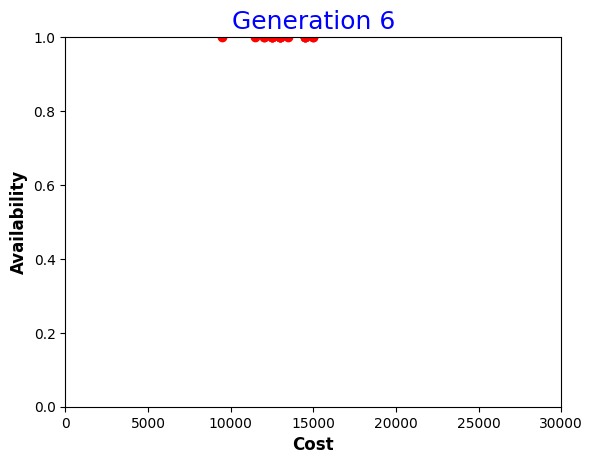

[0]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 3, 2, 1, 3, 4, 4] [1, 3, 2, 2, 3, 4, 4]
Cross from gene: 6

   Child 1 [1, 3, 2, 1, 3, 4, 4]
   Child 2 [1, 3, 2, 2, 3, 4, 4] 

Parents [1, 4, 3, 0, 4, 3, 4] [1, 4, 2, 1, 3, 4, 4]
Cross from gene: 4

   Child 1 [1, 4, 3, 0, 3, 4, 4]
   Child 2 [1, 4, 2, 1, 4, 3, 4] 

Parents [2, 4, 3, 0, 2, 4, 4] [1, 4, 3, 0, 2, 4, 4]
Cross from gene: 1

   Child 1 [2, 4, 3, 0, 2, 4, 4]
   Child 2 [1, 4, 3, 0, 2, 4, 4] 

Parents [1, 4, 3, 0, 2, 4, 4] [1, 4, 2, 1, 3, 4, 4]
Cross from gene: 3

   Child 1 [1, 4, 3, 1, 3, 4, 4]
   Child 2 [1, 4, 2, 0, 2, 4, 4] 

Parents [1, 3, 4, 2, 3, 4, 4] [1, 3, 3, 0, 2, 4, 4]
Cross from gene: 1

   Child 1 [1, 3, 3, 0, 2, 4, 4]
   Child 2 [1, 3, 4, 2, 3, 4, 4] 

Parents [1, 4, 3, 2, 3, 4, 4] [1, 3, 3, 1, 3, 4, 4]
Cross from gene: 3

   Child 1 [1, 4, 3, 1, 3, 4, 4]
   Child 2 [1, 3, 3, 2, 3, 4, 4] 

Parents [1, 4, 3, 2, 3, 4, 4] [2, 4, 3, 0, 2, 4, 4]
Cross from gene: 1

   Child 1 [1, 4, 3, 0, 2, 4, 4]
 

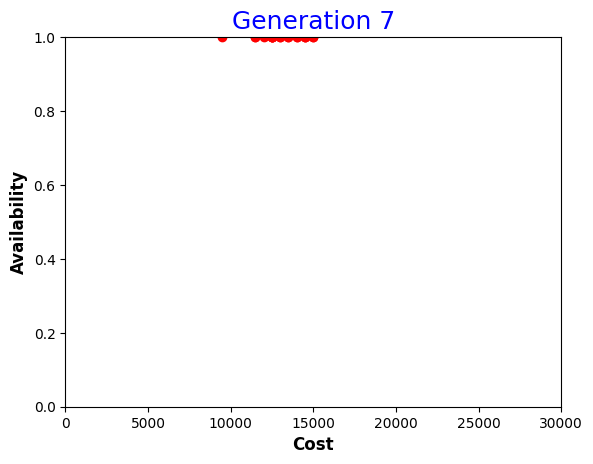

[0]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [2, 4, 3, 0, 2, 4, 4] [1, 4, 3, 1, 3, 4, 4]
Cross from gene: 3

   Child 1 [2, 4, 3, 1, 3, 4, 4]
   Child 2 [1, 4, 3, 0, 2, 4, 4] 

Parents [3, 3, 3, 1, 3, 4, 4] [3, 3, 3, 1, 3, 4, 4]
Cross from gene: 4

   Child 1 [3, 3, 3, 1, 3, 4, 4]
   Child 2 [3, 3, 3, 1, 3, 4, 4] 

Parents [3, 3, 3, 1, 3, 4, 4] [1, 4, 3, 0, 2, 4, 4]
Cross from gene: 6

   Child 1 [3, 3, 3, 1, 3, 4, 4]
   Child 2 [1, 4, 3, 0, 2, 4, 4] 

Parents [1, 4, 3, 1, 3, 4, 4] [1, 4, 3, 0, 2, 4, 4]
Cross from gene: 5

   Child 1 [1, 4, 3, 1, 3, 4, 4]
   Child 2 [1, 4, 3, 0, 2, 4, 4] 

Parents [1, 3, 2, 2, 3, 4, 4] [1, 4, 3, 1, 3, 4, 4]
Cross from gene: 3

   Child 1 [1, 3, 2, 1, 3, 4, 4]
   Child 2 [1, 4, 3, 2, 3, 4, 4] 

Parents [1, 3, 3, 2, 2, 4, 4] [2, 4, 3, 2, 3, 4, 4]
Cross from gene: 5

   Child 1 [1, 3, 3, 2, 2, 4, 4]
   Child 2 [2, 4, 3, 2, 3, 4, 4] 

Parents [4, 1, 4, 1, 4, 3, 4] [1, 4, 3, 1, 3, 4, 4]
Cross from gene: 3

   Child 1 [4, 1, 4, 1, 3, 4, 4]
 

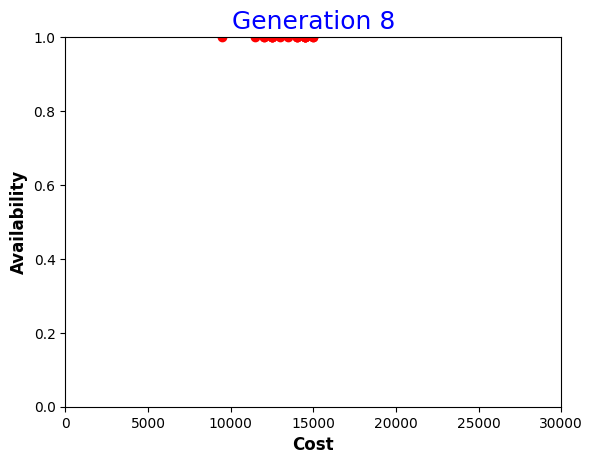

[0]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 4, 2, 1, 4, 3, 4] [1, 4, 3, 0, 2, 4, 4]
Cross from gene: 2

   Child 1 [1, 4, 3, 0, 2, 4, 4]
   Child 2 [1, 4, 2, 1, 4, 3, 4] 

Parents [1, 4, 3, 1, 3, 4, 4] [2, 4, 3, 1, 3, 4, 4]
Cross from gene: 6

   Child 1 [1, 4, 3, 1, 3, 4, 4]
   Child 2 [2, 4, 3, 1, 3, 4, 4] 

Parents [1, 3, 3, 2, 2, 4, 4] [1, 4, 3, 0, 2, 4, 4]
Cross from gene: 2

   Child 1 [1, 3, 3, 0, 2, 4, 4]
   Child 2 [1, 4, 3, 2, 2, 4, 4] 

Parents [1, 4, 3, 0, 2, 4, 4] [1, 4, 3, 0, 2, 4, 4]
Cross from gene: 2

   Child 1 [1, 4, 3, 0, 2, 4, 4]
   Child 2 [1, 4, 3, 0, 2, 4, 4] 

Parents [1, 4, 3, 0, 2, 4, 4] [1, 3, 3, 2, 2, 4, 4]
Cross from gene: 6

   Child 1 [1, 4, 3, 0, 2, 4, 4]
   Child 2 [1, 3, 3, 2, 2, 4, 4] 

Parents [1, 4, 4, 0, 3, 4, 4] [1, 4, 2, 0, 2, 4, 4]
Cross from gene: 1

   Child 1 [1, 4, 2, 0, 2, 4, 4]
   Child 2 [1, 4, 4, 0, 3, 4, 4] 

Parents [3, 3, 3, 1, 3, 4, 4] [1, 4, 3, 1, 4, 3, 4]
Cross from gene: 2

   Child 1 [3, 3, 3, 1, 4, 3, 4]
 

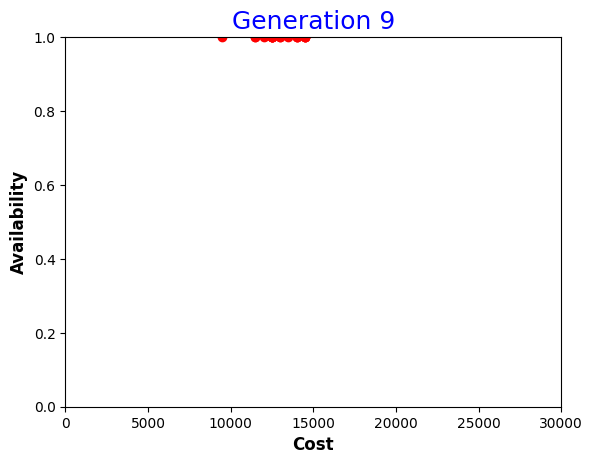

[0]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 3, 3, 2, 2, 4, 4] [1, 4, 3, 0, 2, 4, 4]
Cross from gene: 6

   Child 1 [1, 3, 3, 2, 2, 4, 4]
   Child 2 [1, 4, 3, 0, 2, 4, 4] 

Parents [3, 3, 3, 1, 4, 3, 4] [1, 4, 3, 0, 2, 4, 4]
Cross from gene: 1

   Child 1 [3, 4, 3, 0, 2, 4, 4]
   Child 2 [1, 3, 3, 1, 4, 3, 4] 

Parents [3, 3, 3, 1, 3, 4, 4] [3, 3, 3, 1, 4, 3, 4]
Cross from gene: 4

   Child 1 [3, 3, 3, 1, 4, 3, 4]
   Child 2 [3, 3, 3, 1, 3, 4, 4] 

Parents [2, 4, 3, 1, 3, 4, 4] [1, 4, 2, 1, 4, 3, 4]
Cross from gene: 4

   Child 1 [2, 4, 3, 1, 4, 3, 4]
   Child 2 [1, 4, 2, 1, 3, 4, 4] 

Parents [1, 4, 4, 0, 3, 4, 4] [1, 4, 3, 0, 2, 4, 4]
Cross from gene: 6

   Child 1 [1, 4, 4, 0, 3, 4, 4]
   Child 2 [1, 4, 3, 0, 2, 4, 4] 

Parents [1, 3, 3, 1, 3, 4, 4] [1, 4, 3, 0, 2, 4, 4]
Cross from gene: 1

   Child 1 [1, 4, 3, 0, 2, 4, 4]
   Child 2 [1, 3, 3, 1, 3, 4, 4] 

Parents [1, 3, 2, 1, 3, 4, 4] [1, 4, 3, 0, 2, 4, 4]
Cross from gene: 3

   Child 1 does not comply with th

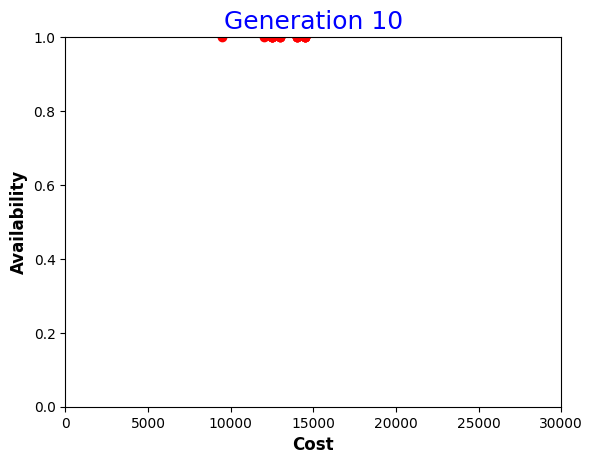

[0]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [3, 3, 3, 1, 3, 4, 4] [1, 3, 3, 1, 3, 4, 4]
Cross from gene: 6

   Child 1 [3, 3, 3, 1, 3, 4, 4]
   Child 2 [1, 3, 3, 1, 3, 4, 4] 

Parents [3, 3, 3, 1, 3, 4, 4] [1, 3, 3, 1, 4, 3, 4]
Cross from gene: 2

   Child 1 [3, 3, 3, 1, 4, 3, 4]
   Child 2 [1, 3, 3, 1, 3, 4, 4] 

Parents [1, 3, 3, 2, 2, 4, 4] [1, 4, 3, 0, 2, 4, 4]
Cross from gene: 6

   Child 1 [1, 3, 3, 2, 2, 4, 4]
   Child 2 [1, 4, 3, 0, 2, 4, 4] 

Parents [1, 4, 3, 0, 2, 4, 4] [1, 3, 2, 1, 3, 4, 4]
Cross from gene: 3

   Child 1 [1, 4, 3, 1, 3, 4, 4]

   Child 2 does not comply with the constraints

Parents [3, 3, 3, 1, 4, 3, 4] [1, 4, 3, 1, 3, 4, 4]
Cross from gene: 1

   Child 1 does not comply with the constraints

   Child 2 [1, 3, 3, 1, 4, 3, 4] 

Parents [1, 4, 3, 0, 2, 4, 4] [1, 4, 3, 0, 2, 4, 4]
Cross from gene: 4

   Child 1 [1, 4, 3, 0, 2, 4, 4]
   Child 2 [1, 4, 3, 0, 2, 4, 4] 

Parents [1, 3, 2, 1, 3, 4, 4] [1, 3, 3, 1, 4, 3, 4]
Cross from gene: 6

   

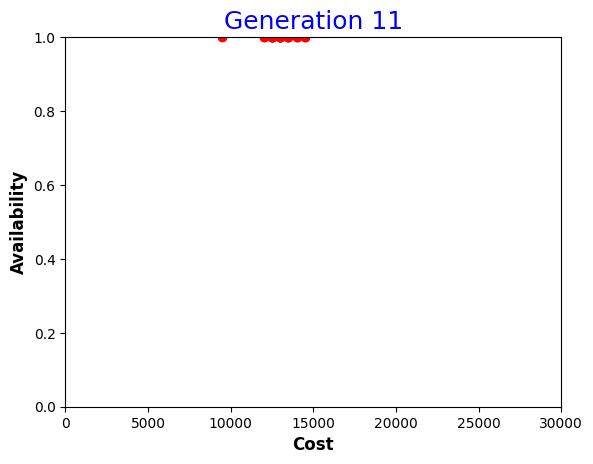

[0]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 4, 3, 1, 3, 4, 4] [1, 3, 3, 1, 4, 3, 4]
Cross from gene: 2

   Child 1 [1, 4, 3, 1, 4, 3, 4]
   Child 2 [1, 3, 3, 1, 3, 4, 4] 

Parents [1, 3, 3, 1, 4, 3, 4] [1, 4, 3, 2, 2, 4, 4]
Cross from gene: 5

   Child 1 [1, 3, 3, 1, 4, 4, 4]
   Child 2 [1, 4, 3, 2, 2, 3, 4] 

Parents [3, 3, 3, 1, 4, 3, 4] [1, 3, 3, 1, 4, 3, 4]
Cross from gene: 4

   Child 1 [3, 3, 3, 1, 4, 3, 4]
   Child 2 [1, 3, 3, 1, 4, 3, 4] 

Parents [1, 3, 2, 1, 3, 4, 4] [3, 4, 3, 0, 2, 4, 4]
Cross from gene: 4

   Child 1 [1, 3, 2, 1, 2, 4, 4]
   Child 2 [3, 4, 3, 0, 3, 4, 4] 

Parents [1, 3, 3, 1, 3, 4, 4] [1, 3, 2, 1, 3, 4, 4]
Cross from gene: 3

   Child 1 [1, 3, 3, 1, 3, 4, 4]
   Child 2 [1, 3, 2, 1, 3, 4, 4] 

Parents [1, 3, 3, 1, 4, 3, 4] [1, 4, 3, 2, 2, 4, 4]
Cross from gene: 3

   Child 1 [1, 3, 3, 2, 2, 4, 4]
   Child 2 [1, 4, 3, 1, 4, 3, 4] 

Parents [1, 3, 3, 1, 3, 4, 4] [1, 3, 3, 2, 2, 4, 4]
Cross from gene: 3

   Child 1 [1, 3, 3, 2, 2, 4, 4]
 

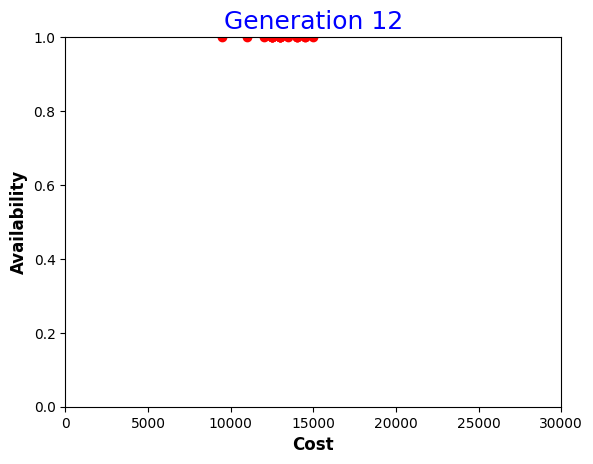

[0]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 3, 2, 1, 2, 4, 4] [1, 3, 3, 2, 2, 4, 4]
Cross from gene: 5

   Child 1 [1, 3, 2, 1, 2, 4, 4]
   Child 2 [1, 3, 3, 2, 2, 4, 4] 

Parents [1, 4, 3, 1, 3, 4, 4] [1, 4, 3, 1, 4, 3, 4]
Cross from gene: 2

   Child 1 [1, 4, 3, 1, 4, 3, 4]
   Child 2 [1, 4, 3, 1, 3, 4, 4] 

Parents [1, 3, 3, 1, 3, 4, 4] [1, 3, 3, 2, 2, 4, 4]
Cross from gene: 3

   Child 1 [1, 3, 3, 2, 2, 4, 4]
   Child 2 [1, 3, 3, 1, 3, 4, 4] 

Parents [1, 4, 3, 2, 2, 3, 4] [1, 3, 2, 1, 3, 4, 4]
Cross from gene: 2

   Child 1 [1, 4, 2, 1, 3, 4, 4]
   Child 2 [1, 3, 3, 2, 2, 3, 4] 

Parents [1, 3, 3, 1, 4, 3, 4] [1, 4, 3, 1, 4, 3, 4]
Cross from gene: 1

   Child 1 [1, 4, 3, 1, 4, 3, 4]
   Child 2 [1, 3, 3, 1, 4, 3, 4] 

Parents [1, 4, 3, 0, 2, 4, 4] [1, 3, 3, 2, 2, 4, 4]
Cross from gene: 3

   Child 1 [1, 4, 3, 2, 2, 4, 4]
   Child 2 [1, 3, 3, 0, 2, 4, 4] 

Parents [1, 4, 3, 1, 4, 3, 4] [1, 3, 3, 2, 2, 4, 4]
Cross from gene: 3

   Child 1 [1, 4, 3, 2, 2, 4, 4]
 

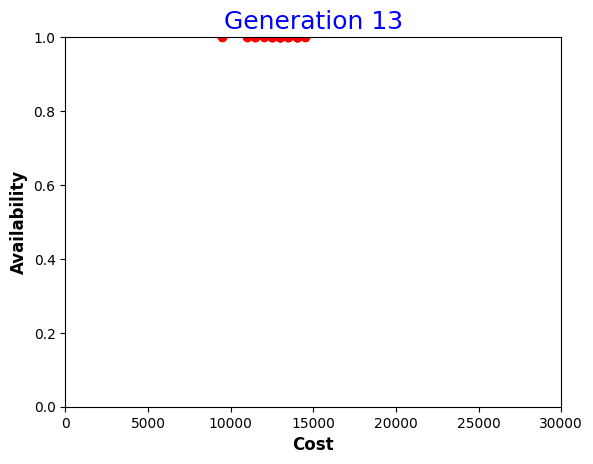

[0]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 4, 3, 2, 2, 4, 4] [1, 3, 3, 0, 2, 4, 4]
Cross from gene: 6

   Child 1 [1, 4, 3, 2, 2, 4, 4]
   Child 2 [1, 3, 3, 0, 2, 4, 4] 

Parents [1, 3, 3, 1, 4, 4, 4] [1, 3, 3, 2, 2, 4, 4]
Cross from gene: 4

   Child 1 [1, 3, 3, 1, 2, 4, 4]
   Child 2 [1, 3, 3, 2, 4, 4, 4] 

Parents [1, 3, 3, 2, 2, 3, 4] [1, 3, 3, 2, 2, 4, 4]
Cross from gene: 6

   Child 1 [1, 3, 3, 2, 2, 3, 4]
   Child 2 [1, 3, 3, 2, 2, 4, 4] 

Parents [1, 3, 3, 2, 2, 4, 4] [1, 4, 3, 2, 2, 4, 4]
Cross from gene: 6

   Child 1 [1, 3, 3, 2, 2, 4, 4]
   Child 2 [1, 4, 3, 2, 2, 4, 4] 

Parents [1, 4, 2, 1, 3, 4, 4] [1, 4, 3, 1, 4, 3, 4]
Cross from gene: 4

   Child 1 [1, 4, 2, 1, 4, 3, 4]
   Child 2 [1, 4, 3, 1, 3, 4, 4] 

Parents [1, 3, 3, 2, 2, 4, 4] [1, 4, 3, 1, 3, 4, 4]
Cross from gene: 5

   Child 1 [1, 3, 3, 2, 2, 4, 4]
   Child 2 [1, 4, 3, 1, 3, 4, 4] 

Parents [1, 3, 3, 2, 2, 4, 4] [1, 4, 3, 1, 4, 3, 4]
Cross from gene: 4

   Child 1 [1, 3, 3, 2, 4, 3, 4]
 

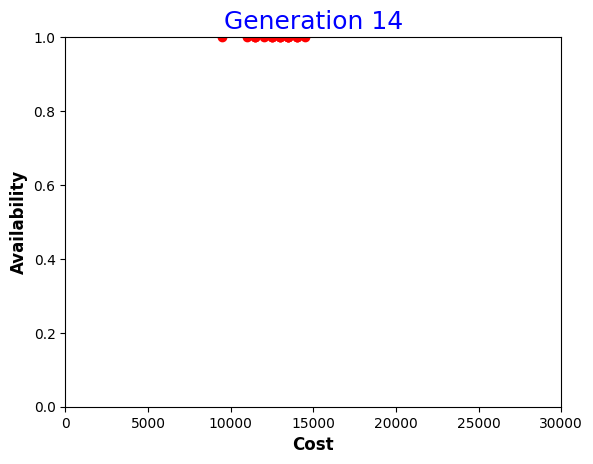

[0]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 3, 3, 2, 4, 3, 4] [1, 3, 2, 1, 2, 4, 4]
Cross from gene: 6

   Child 1 [1, 3, 3, 2, 4, 3, 4]
   Child 2 [1, 3, 2, 1, 2, 4, 4] 

Parents [1, 4, 3, 2, 2, 4, 4] [1, 3, 3, 2, 2, 4, 4]
Cross from gene: 3

   Child 1 [1, 4, 3, 2, 2, 4, 4]
   Child 2 [1, 3, 3, 2, 2, 4, 4] 

Parents [1, 3, 3, 0, 2, 4, 4] [1, 3, 3, 1, 4, 3, 4]
Cross from gene: 4

   Child 1 [1, 3, 3, 0, 4, 3, 4]
   Child 2 [1, 3, 3, 1, 2, 4, 4] 

Parents [1, 3, 3, 0, 2, 4, 4] [1, 4, 3, 2, 2, 4, 4]
Cross from gene: 5

   Child 1 [1, 3, 3, 0, 2, 4, 4]
   Child 2 [1, 4, 3, 2, 2, 4, 4] 

Parents [1, 3, 3, 0, 2, 4, 4] [1, 3, 3, 2, 4, 3, 4]
Cross from gene: 4

   Child 1 [1, 3, 3, 0, 4, 3, 4]
   Child 2 [1, 3, 3, 2, 2, 4, 4] 

Parents [1, 4, 3, 2, 2, 4, 4] [1, 3, 3, 2, 2, 3, 4]
Cross from gene: 3

   Child 1 [1, 4, 3, 2, 2, 3, 4]
   Child 2 [1, 3, 3, 2, 2, 4, 4] 

Parents [1, 3, 3, 1, 4, 4, 4] [1, 3, 2, 1, 2, 4, 4]
Cross from gene: 4

   Child 1 [1, 3, 3, 1, 2, 4, 4]
 

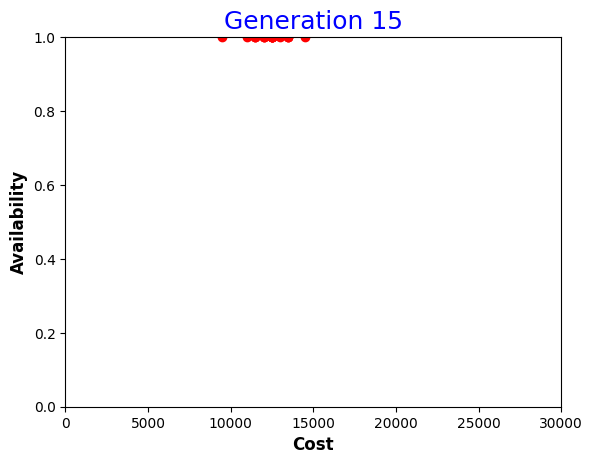

[0]


In [37]:
if __name__ == '__main__':
    main()

In [38]:
# Maximum cost of the solution
CostLimit = 10000

# Minimum availability of the solution
AvLimit = 0.5


GENERATION: 1 

Individual: [3, 1, 2, 3, 2, 1, 3] Cost: 9000.0 Availability: 0.75
Individual: [0, 1, 2, 1, 2, 1, 3] Cost: 5500.0 Availability: 0.5
Individual: [2, 2, 3, 1, 1, 3, 2] Cost: 8000.0 Availability: 0.5
Individual: [2, 2, 3, 1, 0, 4, 1] Cost: 8000.0 Availability: 0.5
Individual: [3, 0, 4, 2, 0, 4, 0] Cost: 9000.0 Availability: 0.5
Individual: [1, 3, 2, 0, 2, 2, 0] Cost: 5500.0 Availability: 0.5
Individual: [1, 0, 3, 2, 3, 2, 3] Cost: 8500.0 Availability: 0.5
Individual: [2, 2, 3, 4, 3, 0, 2] Cost: 10000.0 Availability: 0.5
Individual: [1, 2, 2, 3, 1, 0, 4] Cost: 8000.0 Availability: 0.5
Individual: [4, 3, 3, 1, 3, 0, 0] Cost: 9500.0 Availability: 0.5
Individual: [0, 2, 2, 1, 2, 0, 1] Cost: 4000.0 Availability: 0.5
Individual: [1, 3, 2, 1, 4, 0, 2] Cost: 8000.0 Availability: 0.5
Individual: [1, 0, 3, 2, 2, 1, 1] Cost: 5500.0 Availability: 0.5
Individual: [1, 4, 3, 3, 0, 3, 1] Cost: 10000.0 Availability: 0.75
Individual: [2, 0, 4, 0, 2, 2, 4] Cost: 9000.0 Availability: 0.5
Indi

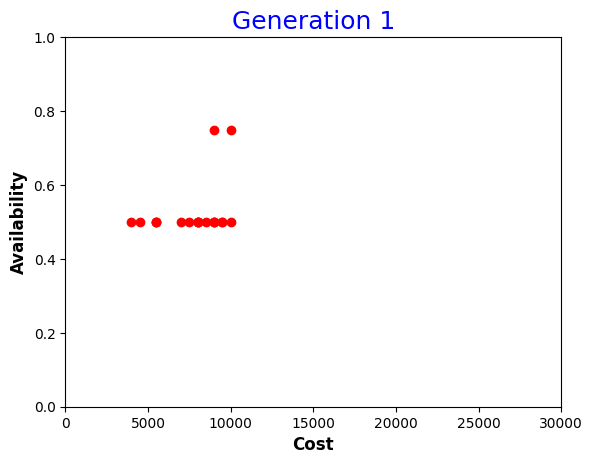



 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 0, 3, 2, 2, 1, 1] [1, 3, 2, 0, 2, 2, 0]
Cross from gene: 3

   Child 1 [1, 0, 3, 0, 2, 2, 0]
   Child 2 [1, 3, 2, 2, 2, 1, 1] 

Parents [1, 3, 2, 0, 2, 2, 0] [2, 2, 3, 4, 3, 0, 2]
Cross from gene: 5

   Child 1 [1, 3, 2, 0, 2, 0, 2]
   Child 2 [2, 2, 3, 4, 3, 2, 0] 

Parents [2, 2, 3, 4, 3, 0, 2] [2, 0, 2, 1, 3, 0, 0]
Cross from gene: 4

   Child 1 [2, 2, 3, 4, 3, 0, 0]
   Child 2 [2, 0, 2, 1, 3, 0, 2] 

Parents [1, 2, 2, 3, 1, 0, 4] [1, 3, 2, 0, 2, 2, 0]
Cross from gene: 1

   Child 1 [1, 3, 2, 0, 2, 2, 0]
   Child 2 [1, 2, 2, 3, 1, 0, 4] 

Parents [1, 3, 2, 0, 2, 2, 0] [1, 2, 2, 3, 1, 0, 4]
Cross from gene: 6

   Child 1 [1, 3, 2, 0, 2, 2, 4]
   Child 2 [1, 2, 2, 3, 1, 0, 0] 

Parents [1, 2, 2, 3, 1, 0, 4] [2, 2, 3, 1, 1, 3, 2]
Cross from gene: 6

   Child 1 [1, 2, 2, 3, 1, 0, 2]
   Child 2 [2, 2, 3, 1, 1, 3, 4] 


Number of Crossover Children: 12 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [0, 1, 2, 1, 2

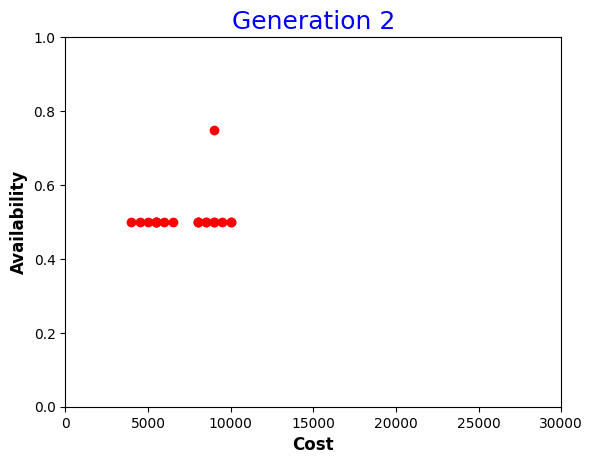

[0, 10]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 0, 3, 2, 3, 2, 3] [1, 0, 3, 0, 2, 2, 0]
Cross from gene: 5

   Child 1 [1, 0, 3, 2, 3, 2, 0]
   Child 2 [1, 0, 3, 0, 2, 2, 3] 

Parents [2, 2, 3, 4, 3, 0, 0] [1, 0, 3, 0, 2, 2, 0]
Cross from gene: 2

   Child 1 [2, 2, 3, 0, 2, 2, 0]
   Child 2 [1, 0, 3, 4, 3, 0, 0] 

Parents [2, 2, 3, 1, 0, 4, 1] [1, 2, 2, 3, 1, 0, 4]
Cross from gene: 3

   Child 1 [2, 2, 3, 3, 1, 0, 4]
   Child 2 [1, 2, 2, 1, 0, 4, 1] 

Parents [3, 0, 4, 2, 0, 4, 0] [2, 2, 3, 4, 3, 2, 0]
Cross from gene: 6

   Child 1 [3, 0, 4, 2, 0, 4, 0]
   Child 2 [2, 2, 3, 4, 3, 2, 0] 

Parents [1, 2, 2, 3, 1, 0, 2] [1, 2, 2, 3, 1, 0, 4]
Cross from gene: 6

   Child 1 [1, 2, 2, 3, 1, 0, 4]
   Child 2 [1, 2, 2, 3, 1, 0, 2] 

Parents [2, 0, 2, 1, 3, 0, 2] [1, 3, 2, 1, 4, 0, 2]
Cross from gene: 5

   Child 1 [2, 0, 2, 1, 3, 0, 2]
   Child 2 [1, 3, 2, 1, 4, 0, 2] 

Parents [1, 3, 2, 0, 2, 0, 2] [1, 0, 3, 2, 3, 2, 3]
Cross from gene: 4

   Child 1 [1, 3, 2, 0, 3, 2, 

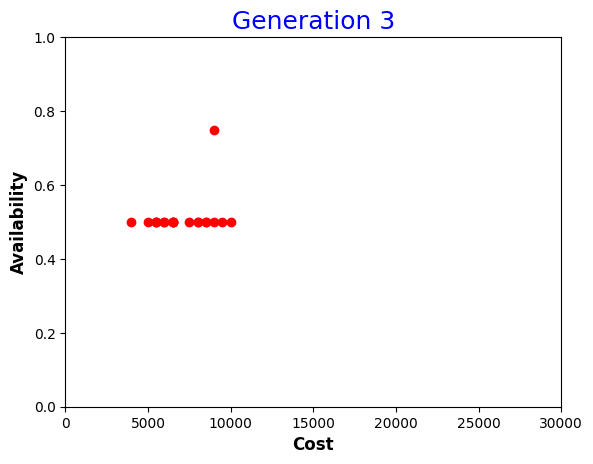

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 2, 2, 3, 1, 0, 0] [1, 0, 3, 2, 2, 0, 2]
Cross from gene: 3

   Child 1 [1, 2, 2, 2, 2, 0, 2]
   Child 2 [1, 0, 3, 3, 1, 0, 0] 

Parents [2, 2, 3, 3, 1, 0, 4] [1, 3, 2, 0, 2, 2, 0]
Cross from gene: 5

   Child 1 [2, 2, 3, 3, 1, 2, 0]
   Child 2 [1, 3, 2, 0, 2, 0, 4] 

Parents [2, 2, 3, 3, 1, 0, 4] [1, 2, 2, 3, 1, 0, 0]
Cross from gene: 6

   Child 1 [2, 2, 3, 3, 1, 0, 0]
   Child 2 [1, 2, 2, 3, 1, 0, 4] 

Parents [1, 2, 2, 3, 1, 0, 2] [2, 2, 3, 4, 3, 2, 0]
Cross from gene: 1

   Child 1 [1, 2, 3, 4, 3, 2, 0]
   Child 2 [2, 2, 2, 3, 1, 0, 2] 

Parents [1, 2, 2, 3, 1, 0, 4] [1, 3, 2, 1, 4, 0, 2]
Cross from gene: 4

   Child 1 [1, 2, 2, 3, 4, 0, 2]
   Child 2 [1, 3, 2, 1, 1, 0, 4] 

Parents [1, 0, 3, 0, 2, 2, 3] [1, 3, 2, 1, 4, 0, 2]
Cross from gene: 2

   Child 1 [1, 0, 2, 1, 4, 0, 2]
   Child 2 [1, 3, 3, 0, 2, 2, 3] 


Number of Crossover Children: 12 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [1, 0, 

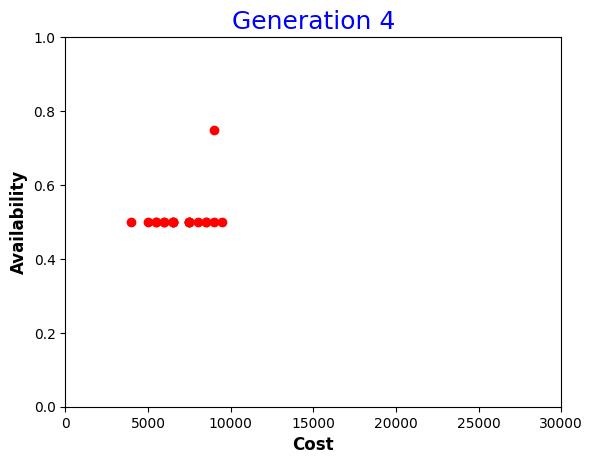

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 2, 2, 3, 4, 0, 2] [1, 2, 2, 3, 1, 0, 4]
Cross from gene: 5

   Child 1 does not comply with the constraints

   Child 2 [1, 2, 2, 3, 1, 0, 2] 

Parents [1, 0, 3, 2, 3, 2, 0] [1, 2, 2, 2, 2, 0, 2]
Cross from gene: 6

   Child 1 [1, 0, 3, 2, 3, 2, 2]
   Child 2 [1, 2, 2, 2, 2, 0, 0] 

Parents [1, 2, 3, 4, 3, 2, 0] [1, 0, 3, 4, 3, 0, 0]
Cross from gene: 4

   Child 1 [1, 2, 3, 4, 3, 0, 0]
   Child 2 [1, 0, 3, 4, 3, 2, 0] 

Parents [2, 2, 3, 3, 1, 0, 0] [2, 2, 2, 3, 1, 0, 2]
Cross from gene: 5

   Child 1 [2, 2, 3, 3, 1, 0, 2]
   Child 2 [2, 2, 2, 3, 1, 0, 0] 

Parents [1, 0, 2, 1, 4, 0, 2] [1, 3, 2, 1, 1, 0, 4]
Cross from gene: 4

   Child 1 [1, 0, 2, 1, 1, 0, 4]
   Child 2 [1, 3, 2, 1, 4, 0, 2] 

Parents [2, 2, 3, 0, 2, 2, 0] [1, 2, 3, 4, 3, 2, 0]
Cross from gene: 2

   Child 1 [2, 2, 3, 4, 3, 2, 0]
   Child 2 [1, 2, 3, 0, 2, 2, 0] 

Parents [1, 3, 2, 1, 1, 0, 4] [2, 2, 3, 3, 1, 0, 0]
Cross from gene: 3

   Child 1 [1, 

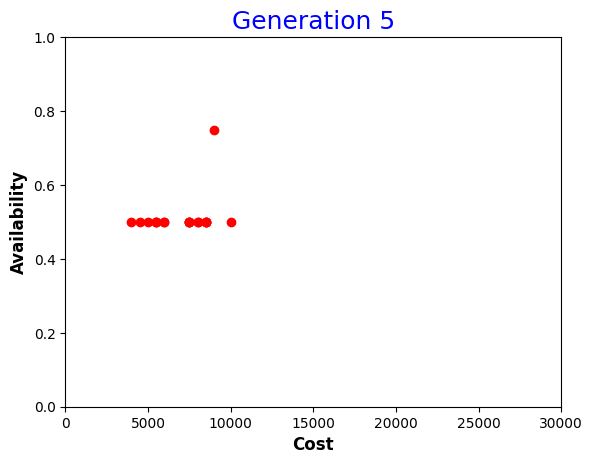

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 2, 2, 2, 2, 0, 0] [2, 2, 3, 3, 1, 0, 2]
Cross from gene: 6

   Child 1 [1, 2, 2, 2, 2, 0, 2]
   Child 2 [2, 2, 3, 3, 1, 0, 0] 

Parents [1, 2, 3, 4, 3, 0, 0] [2, 2, 3, 1, 1, 0, 4]
Cross from gene: 2

   Child 1 [1, 2, 3, 1, 1, 0, 4]
   Child 2 [2, 2, 3, 4, 3, 0, 0] 

Parents [2, 2, 2, 3, 1, 0, 0] [1, 0, 2, 1, 1, 0, 4]
Cross from gene: 5

   Child 1 [2, 2, 2, 3, 1, 0, 4]
   Child 2 [1, 0, 2, 1, 1, 0, 0] 

Parents [2, 2, 2, 3, 1, 0, 0] [1, 2, 2, 2, 2, 0, 0]
Cross from gene: 3

   Child 1 [2, 2, 2, 2, 2, 0, 0]
   Child 2 [1, 2, 2, 3, 1, 0, 0] 

Parents [1, 3, 2, 1, 4, 0, 2] [2, 2, 3, 3, 1, 0, 2]
Cross from gene: 2

   Child 1 [1, 3, 3, 3, 1, 0, 2]
   Child 2 [2, 2, 2, 1, 4, 0, 2] 

Parents [1, 2, 2, 3, 4, 0, 2] [1, 2, 3, 4, 3, 0, 0]
Cross from gene: 4

   Child 1 [1, 2, 2, 3, 3, 0, 0]

   Child 2 does not comply with the constraints


Number of Crossover Children: 11 



 >>>> MUTATION PHASE (with probability 0.1 )


ind

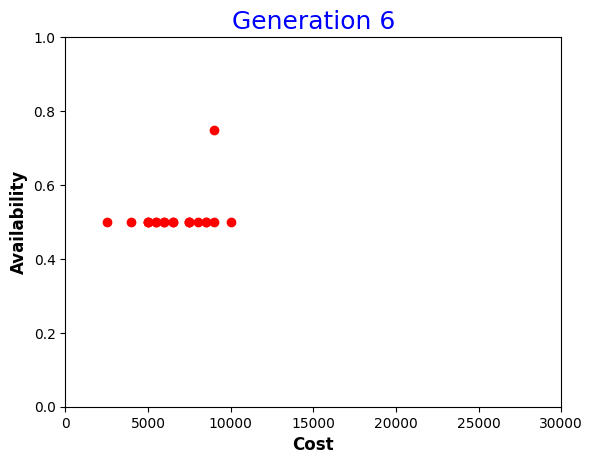

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [0, 2, 2, 1, 2, 0, 1] [1, 2, 2, 2, 2, 0, 2]
Cross from gene: 5

   Child 1 [0, 2, 2, 1, 2, 0, 2]
   Child 2 [1, 2, 2, 2, 2, 0, 1] 

Parents [2, 2, 3, 3, 1, 0, 0] [1, 3, 3, 3, 1, 0, 2]
Cross from gene: 4

   Child 1 [2, 2, 3, 3, 1, 0, 2]
   Child 2 [1, 3, 3, 3, 1, 0, 0] 

Parents [1, 0, 3, 3, 1, 0, 0] [2, 2, 3, 4, 3, 2, 0]
Cross from gene: 4

   Child 1 [1, 0, 3, 3, 3, 2, 0]
   Child 2 [2, 2, 3, 4, 1, 0, 0] 

Parents [0, 2, 2, 1, 2, 0, 1] [1, 0, 3, 2, 3, 2, 2]
Cross from gene: 5

   Child 1 [0, 2, 2, 1, 2, 2, 2]
   Child 2 [1, 0, 3, 2, 3, 0, 1] 

Parents [2, 2, 3, 4, 3, 0, 0] [2, 2, 3, 4, 3, 2, 0]
Cross from gene: 5

   Child 1 [2, 2, 3, 4, 3, 2, 0]
   Child 2 [2, 2, 3, 4, 3, 0, 0] 

Parents [1, 2, 3, 1, 1, 0, 4] [1, 3, 2, 3, 1, 0, 0]
Cross from gene: 1

   Child 1 [1, 3, 2, 3, 1, 0, 0]
   Child 2 [1, 2, 3, 1, 1, 0, 4] 


Number of Crossover Children: 12 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [2, 2, 

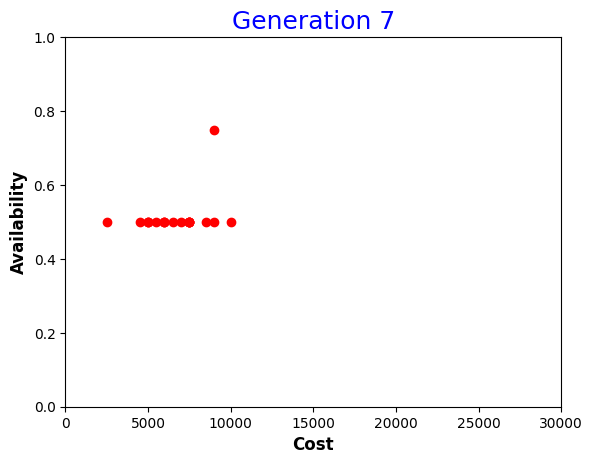

[0, 7]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [2, 2, 2, 1, 4, 0, 2] [2, 2, 3, 3, 1, 0, 2]
Cross from gene: 6

   Child 1 [2, 2, 2, 1, 4, 0, 2]
   Child 2 [2, 2, 3, 3, 1, 0, 2] 

Parents [2, 2, 3, 4, 1, 0, 0] [2, 2, 2, 3, 1, 0, 4]
Cross from gene: 1

   Child 1 [2, 2, 2, 3, 1, 0, 4]
   Child 2 [2, 2, 3, 4, 1, 0, 0] 

Parents [1, 2, 2, 3, 1, 0, 2] [0, 2, 2, 1, 2, 0, 2]
Cross from gene: 4

   Child 1 [1, 2, 2, 3, 2, 0, 2]
   Child 2 [0, 2, 2, 1, 1, 0, 2] 

Parents [2, 2, 2, 1, 4, 0, 2] [0, 2, 2, 1, 2, 0, 2]
Cross from gene: 1

   Child 1 [2, 2, 2, 1, 2, 0, 2]
   Child 2 [0, 2, 2, 1, 4, 0, 2] 

Parents [1, 2, 2, 2, 2, 0, 1] [2, 2, 3, 4, 3, 2, 0]
Cross from gene: 3

   Child 1 [1, 2, 2, 4, 3, 2, 0]
   Child 2 [2, 2, 3, 2, 2, 0, 1] 


Number of Crossover Children: 10 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [1, 3, 3, 3, 1, 0, 0] not mutated
individual [1, 0, 3, 3, 3, 2, 0] not mutated
individual [0, 2, 2, 1, 2, 2, 2] not mutated
individual [1, 0, 3, 2,

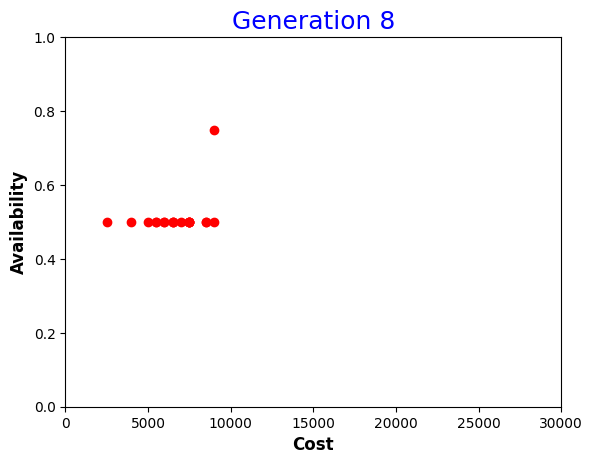

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [0, 2, 2, 1, 1, 0, 2] [1, 2, 2, 4, 3, 2, 0]
Cross from gene: 1

   Child 1 [0, 2, 2, 4, 3, 2, 0]
   Child 2 [1, 2, 2, 1, 1, 0, 2] 

Parents [1, 2, 2, 3, 2, 0, 2] [2, 2, 2, 1, 4, 0, 2]
Cross from gene: 6

   Child 1 [1, 2, 2, 3, 2, 0, 2]
   Child 2 [2, 2, 2, 1, 4, 0, 2] 

Parents [1, 3, 2, 0, 1, 2, 0] [1, 2, 3, 1, 1, 0, 4]
Cross from gene: 5

   Child 1 [1, 3, 2, 0, 1, 0, 4]
   Child 2 [1, 2, 3, 1, 1, 2, 0] 

Parents [2, 2, 3, 4, 3, 0, 0] [2, 2, 3, 2, 2, 0, 1]
Cross from gene: 3

   Child 1 [2, 2, 3, 2, 2, 0, 1]
   Child 2 [2, 2, 3, 4, 3, 0, 0] 

Parents [0, 2, 2, 1, 4, 0, 2] [2, 2, 3, 2, 2, 0, 1]
Cross from gene: 6

   Child 1 [0, 2, 2, 1, 4, 0, 1]
   Child 2 [2, 2, 3, 2, 2, 0, 2] 

Parents [1, 0, 3, 3, 3, 2, 0] [2, 2, 3, 4, 3, 0, 0]
Cross from gene: 6

   Child 1 [1, 0, 3, 3, 3, 2, 0]
   Child 2 [2, 2, 3, 4, 3, 0, 0] 

Parents [1, 3, 3, 3, 1, 0, 0] [1, 2, 3, 1, 1, 0, 4]
Cross from gene: 3

   Child 1 [1, 3, 3, 1, 1, 0, 4

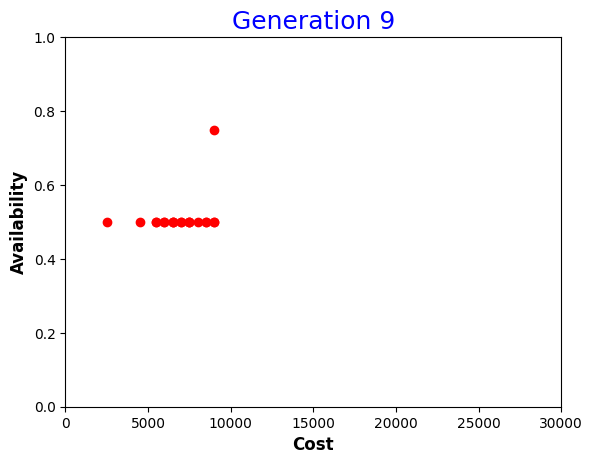

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [2, 2, 2, 1, 4, 0, 2] [1, 2, 2, 1, 1, 0, 2]
Cross from gene: 3

   Child 1 [2, 2, 2, 1, 1, 0, 2]
   Child 2 [1, 2, 2, 1, 4, 0, 2] 

Parents [2, 2, 3, 2, 2, 0, 2] [1, 0, 3, 3, 3, 2, 0]
Cross from gene: 4

   Child 1 [2, 2, 3, 2, 3, 2, 0]
   Child 2 [1, 0, 3, 3, 2, 0, 2] 

Parents [2, 2, 2, 1, 2, 0, 2] [2, 2, 2, 3, 1, 0, 4]
Cross from gene: 2

   Child 1 [2, 2, 2, 3, 1, 0, 4]
   Child 2 [2, 2, 2, 1, 2, 0, 2] 

Parents [1, 2, 2, 3, 2, 0, 2] [2, 2, 2, 1, 2, 0, 2]
Cross from gene: 3

   Child 1 [1, 2, 2, 1, 2, 0, 2]
   Child 2 [2, 2, 2, 3, 2, 0, 2] 

Parents [2, 2, 3, 3, 1, 0, 2] [0, 2, 2, 4, 3, 2, 0]
Cross from gene: 1

   Child 1 [2, 2, 2, 4, 3, 2, 0]
   Child 2 [0, 2, 3, 3, 1, 0, 2] 

Parents [2, 2, 3, 4, 3, 0, 0] [1, 3, 3, 1, 1, 0, 4]
Cross from gene: 5

   Child 1 does not comply with the constraints

   Child 2 [1, 3, 3, 1, 1, 0, 0] 

Parents [2, 2, 3, 3, 1, 0, 2] [1, 0, 3, 3, 3, 2, 0]
Cross from gene: 6

   Child 1 [2, 

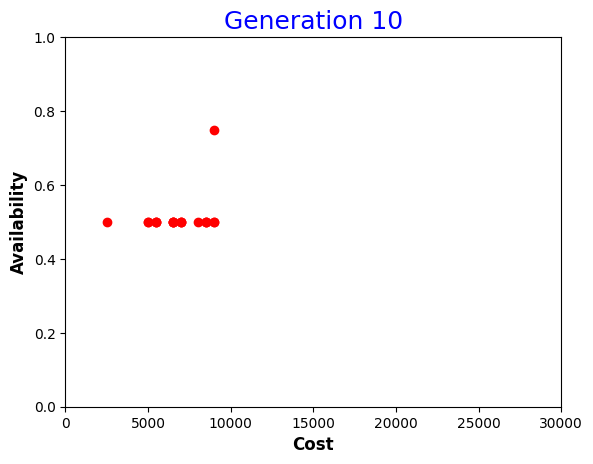

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [2, 2, 2, 3, 2, 0, 2] [2, 2, 2, 1, 1, 0, 2]
Cross from gene: 1

   Child 1 [2, 2, 2, 1, 1, 0, 2]
   Child 2 [2, 2, 2, 3, 2, 0, 2] 

Parents [2, 2, 2, 3, 1, 0, 0] [1, 2, 3, 1, 1, 2, 4]
Cross from gene: 3

   Child 1 [2, 2, 2, 1, 1, 2, 4]
   Child 2 [1, 2, 3, 3, 1, 0, 0] 

Parents [2, 2, 2, 1, 2, 0, 2] [2, 2, 3, 2, 2, 0, 1]
Cross from gene: 4

   Child 1 [2, 2, 2, 1, 2, 0, 1]
   Child 2 [2, 2, 3, 2, 2, 0, 2] 

Parents [2, 2, 2, 3, 1, 0, 4] [1, 3, 2, 0, 1, 0, 4]
Cross from gene: 6

   Child 1 [2, 2, 2, 3, 1, 0, 4]
   Child 2 [1, 3, 2, 0, 1, 0, 4] 

Parents [0, 2, 3, 3, 1, 0, 2] [2, 2, 3, 2, 3, 2, 0]
Cross from gene: 2

   Child 1 [0, 2, 3, 2, 3, 2, 0]
   Child 2 [2, 2, 3, 3, 1, 0, 2] 

Parents [2, 2, 3, 3, 1, 0, 0] [2, 2, 3, 2, 2, 0, 1]
Cross from gene: 5

   Child 1 [2, 2, 3, 3, 1, 0, 1]
   Child 2 [2, 2, 3, 2, 2, 0, 0] 

Parents [1, 2, 2, 1, 2, 0, 2] [1, 2, 3, 1, 1, 2, 4]
Cross from gene: 1

   Child 1 [1, 2, 3, 1, 1, 2, 4

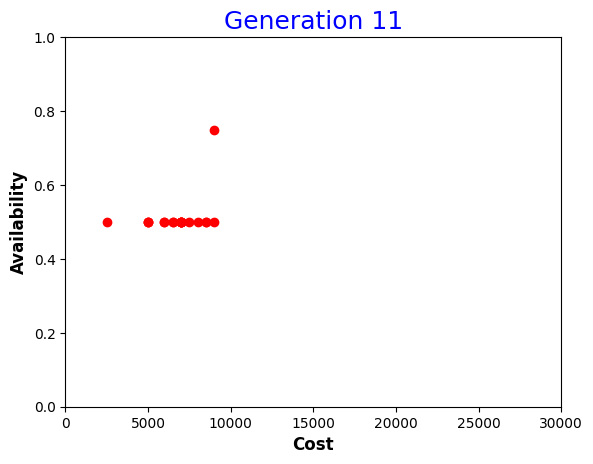

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [2, 2, 3, 2, 2, 0, 0] [0, 2, 3, 2, 3, 2, 0]
Cross from gene: 6

   Child 1 [2, 2, 3, 2, 2, 0, 0]
   Child 2 [0, 2, 3, 2, 3, 2, 0] 

Parents [2, 2, 3, 3, 1, 0, 2] [2, 2, 3, 2, 2, 0, 2]
Cross from gene: 1

   Child 1 [2, 2, 3, 2, 2, 0, 2]
   Child 2 [2, 2, 3, 3, 1, 0, 2] 

Parents [2, 2, 3, 3, 1, 0, 2] [2, 2, 2, 1, 2, 0, 1]
Cross from gene: 4

   Child 1 [2, 2, 3, 3, 2, 0, 1]
   Child 2 [2, 2, 2, 1, 1, 0, 2] 

Parents [2, 2, 2, 3, 1, 0, 4] [1, 2, 2, 1, 2, 0, 2]
Cross from gene: 2

   Child 1 [2, 2, 2, 1, 2, 0, 2]
   Child 2 [1, 2, 2, 3, 1, 0, 4] 

Parents [2, 2, 3, 2, 2, 0, 1] [2, 2, 3, 2, 2, 0, 0]
Cross from gene: 1

   Child 1 [2, 2, 3, 2, 2, 0, 0]
   Child 2 [2, 2, 3, 2, 2, 0, 1] 

Parents [2, 2, 3, 2, 2, 0, 2] [2, 2, 3, 3, 1, 0, 1]
Cross from gene: 3

   Child 1 [2, 2, 3, 3, 1, 0, 1]
   Child 2 [2, 2, 3, 2, 2, 0, 2] 

Parents [2, 2, 3, 4, 3, 0, 0] [2, 2, 3, 3, 1, 0, 2]
Cross from gene: 4

   Child 1 [2, 2, 3, 4, 1, 0, 2

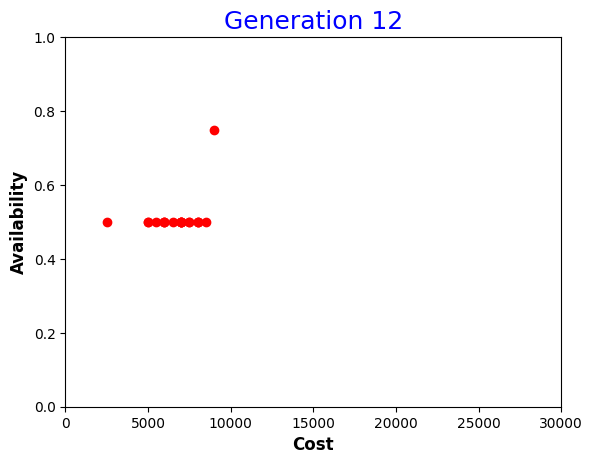

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [1, 2, 3, 3, 0, 1, 0] [2, 2, 3, 2, 2, 0, 2]
Cross from gene: 6

   Child 1 [1, 2, 3, 3, 0, 1, 2]
   Child 2 [2, 2, 3, 2, 2, 0, 0] 

Parents [2, 2, 2, 1, 1, 0, 2] [2, 2, 3, 2, 2, 0, 0]
Cross from gene: 1

   Child 1 [2, 2, 3, 2, 2, 0, 0]
   Child 2 [2, 2, 2, 1, 1, 0, 2] 

Parents [2, 2, 2, 1, 1, 2, 4] [2, 2, 3, 3, 2, 0, 1]
Cross from gene: 3

   Child 1 [2, 2, 2, 3, 2, 0, 1]
   Child 2 [2, 2, 3, 1, 1, 2, 4] 

Parents [2, 2, 3, 2, 2, 0, 0] [2, 2, 3, 2, 2, 0, 1]
Cross from gene: 3

   Child 1 [2, 2, 3, 2, 2, 0, 1]
   Child 2 [2, 2, 3, 2, 2, 0, 0] 

Parents [2, 2, 2, 1, 1, 0, 2] [2, 2, 3, 4, 1, 0, 2]
Cross from gene: 6

   Child 1 [2, 2, 2, 1, 1, 0, 2]
   Child 2 [2, 2, 3, 4, 1, 0, 2] 

Parents [2, 2, 2, 1, 1, 0, 2] [2, 2, 3, 2, 2, 0, 0]
Cross from gene: 5

   Child 1 [2, 2, 2, 1, 1, 0, 0]
   Child 2 [2, 2, 3, 2, 2, 0, 2] 

Parents [2, 2, 3, 3, 1, 0, 1] [2, 2, 3, 3, 2, 0, 1]
Cross from gene: 2

   Child 1 [2, 2, 3, 3, 2, 0, 1

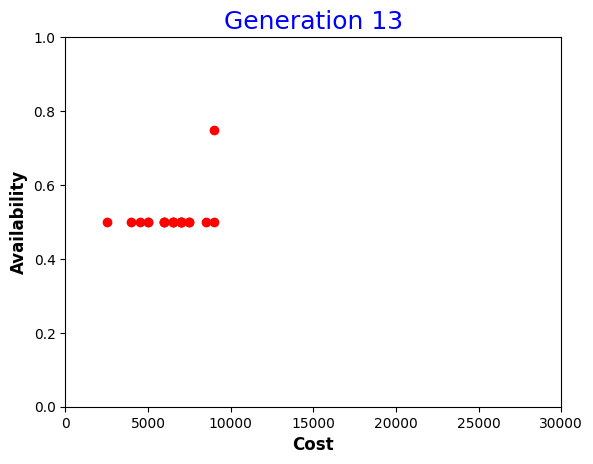

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [2, 2, 2, 1, 1, 0, 2] [1, 2, 3, 3, 0, 1, 2]
Cross from gene: 3

   Child 1 [2, 2, 2, 3, 0, 1, 2]
   Child 2 [1, 2, 3, 1, 1, 0, 2] 

Parents [0, 2, 3, 2, 3, 2, 0] [2, 2, 3, 4, 1, 0, 2]
Cross from gene: 2

   Child 1 [0, 2, 3, 4, 1, 0, 2]
   Child 2 [2, 2, 3, 2, 3, 2, 0] 

Parents [2, 2, 2, 1, 2, 0, 0] [2, 2, 3, 3, 2, 0, 1]
Cross from gene: 6

   Child 1 [2, 2, 2, 1, 2, 0, 1]
   Child 2 [2, 2, 3, 3, 2, 0, 0] 

Parents [2, 2, 2, 3, 2, 0, 1] [2, 2, 3, 4, 1, 0, 2]
Cross from gene: 1

   Child 1 [2, 2, 3, 4, 1, 0, 2]
   Child 2 [2, 2, 2, 3, 2, 0, 1] 


Number of Crossover Children: 8 



 >>>> MUTATION PHASE (with probability 0.1 )


individual [2, 2, 3, 2, 2, 0, 0] not mutated
individual [2, 2, 3, 2, 2, 0, 0] not mutated
individual [2, 2, 2, 1, 1, 0, 2] not mutated
individual [2, 2, 3, 1, 1, 2, 4] not mutated
individual [2, 2, 3, 2, 2, 0, 1] not mutated
individual [2, 2, 3, 2, 2, 0, 0] not mutated
individual [2, 2, 2, 1, 1, 0,

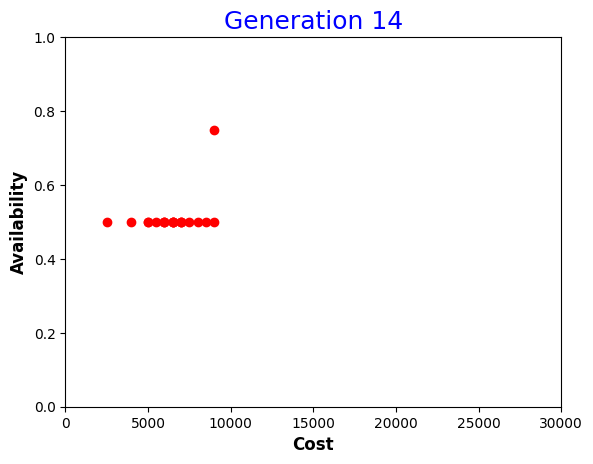

[0, 1]


 >>>> CROSSOVER PHASE (with probability 0.8 )


Parents [2, 2, 3, 2, 2, 0, 2] [2, 2, 3, 2, 3, 2, 0]
Cross from gene: 2

   Child 1 [2, 2, 3, 2, 3, 2, 0]
   Child 2 [2, 2, 3, 2, 2, 0, 2] 

Parents [2, 2, 3, 3, 1, 0, 1] [2, 2, 2, 1, 1, 0, 2]
Cross from gene: 4

   Child 1 [2, 2, 3, 3, 1, 0, 2]
   Child 2 [2, 2, 2, 1, 1, 0, 1] 

Parents [2, 2, 3, 2, 2, 0, 0] [2, 2, 2, 3, 0, 1, 2]
Cross from gene: 3

   Child 1 [2, 2, 3, 3, 0, 1, 2]
   Child 2 [2, 2, 2, 2, 2, 0, 0] 

Parents [2, 2, 2, 1, 1, 0, 0] [2, 2, 3, 3, 2, 0, 0]
Cross from gene: 6

   Child 1 [2, 2, 2, 1, 1, 0, 0]
   Child 2 [2, 2, 3, 3, 2, 0, 0] 

Parents [2, 2, 3, 3, 2, 0, 0] [2, 2, 3, 2, 2, 0, 0]
Cross from gene: 1

   Child 1 [2, 2, 3, 2, 2, 0, 0]
   Child 2 [2, 2, 3, 3, 2, 0, 0] 

Parents [2, 2, 3, 2, 3, 2, 0] [2, 2, 2, 1, 2, 0, 1]
Cross from gene: 3

   Child 1 [2, 2, 3, 1, 2, 0, 1]
   Child 2 [2, 2, 2, 2, 3, 2, 0] 

Parents [2, 2, 3, 2, 3, 2, 0] [2, 2, 3, 2, 2, 0, 0]
Cross from gene: 3

   Child 1 [2, 2, 3, 2, 2, 0, 0

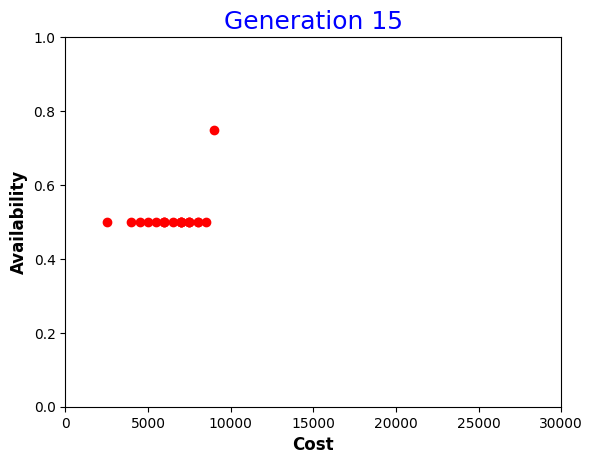

[0, 1]


In [39]:
if __name__ == '__main__':
    main()